## Final testing for all candidate models (One Day Testing)

#### Imports

In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
import torch
from statsmodels.graphics.tsaplots import plot_acf

plt.rcParams["font.family"] = "serif"

pd.set_option('display.max_columns', None)
np.set_printoptions(suppress=True)

### Dataset Creation

Dataset is generated from gross resturaunt sales over a period of three years. 

The dataset is not perfectly continuous. There are some days that are missing from the record. 
Also, the data is highly noisy. Part of this is due to holidays such as Christmas causing no sales in a day.
Partly, the noise is generated by features not easily captured in future forecasting such as the weather.

Our data is from 9/11/2016 to 12/5/2019 - about three years of data. <br>
In total, we are missing 70 full days of sales data. One big continuous chunk of 63 days from 12/31/2017-3/4/2018. Also, 7 additional days from 5/31/19 to 6/8/19. Originally only 58 and 5 days were missing respectively, but we ensure that the gaps do not harm the weekly structure of our time series by increasing the missing window to encapsulate full weeks. This means each day in our series is preceeded and superceeded by the proper weekday. 

Some small adjustments must be made to a dataset to be within the specifics of certain models. As such, we define a few datasets below.

In total, we have <b>1104</b> days of sales to create a dataset with since we need to throw out 7 days of sales.  

#### Actual Dataset

We use 80% of the data for training and 20% for testing metrics. 
Specifically, 883 days for training and 221 for testing.

In [80]:
train_time=883
time = np.arange(1104, dtype="float32")

In [81]:
data = pd.read_csv('Data/RestaurantDataVets_All_2to5.csv')
data=data.drop([x for x in range(7)]) ##Removing data with holes in beginning
data

Index  Group        DMY  MissingPrevDays  Year  Day  January  February  \
7         8      0  9/18/2016                0  2016   18        0         0   
8         9      0  9/19/2016                0  2016   19        0         0   
9        10      0  9/20/2016                0  2016   20        0         0   
10       11      0  9/21/2016                0  2016   21        0         0   
11       12      0  9/22/2016                0  2016   22        0         0   
...     ...    ...        ...              ...   ...  ...      ...       ...   
1106   1107      0  12/1/2019                0  2019    1        0         0   
1107   1108      0  12/2/2019                0  2019    2        0         0   
1108   1109      0  12/3/2019                0  2019    3        0         0   
1109   1110      0  12/4/2019                0  2019    4        0         0   
1110   1111      0  12/5/2019                0  2019    5        0         0   

      March  April  May  June  July  August  September  October  November  \
7         0      0    0     0     0       0          1        0         0   
8         0      0    0     0     0       0          1        0         0   
9         0      0    0     0     0       0          1        0         0   
10        0      0    0     0     0       0          1        0         0   
11        0      0    0     0     0       0          1        0         0   
...     ...    ...  ...   ...   ...     ...        ...      ...       ...   
1106      0      0    0     0     0       0          0        0         0   
1107      0      0    0     0     0       0          0        0         0   
1108      0      0    0     0     0       0          0        0         0   
1109      0      0    0     0     0       0          0        0         0   
1110      0      0    0     0     0       0          0        0         0   

      December  Sunday  Monday  Tuesday  Wednesday  Thursday  Friday  \
7            0       1       0        0          0         0       0   
8            0       0       1        0          0         0       0   
9            0       0       0        1          0         0       0   
10           0       0       0        0          1         0       0   
11           0       0       0        0          0         1       0   
...        ...     ...     ...      ...        ...       ...     ...   
1106         1       1       0        0          0         0       0   
1107         1       0       1        0          0         0       0   
1108         1       0       0        1          0         0       0   
1109         1       0       0        0          1         0       0   
1110         1       0       0        0          0         1       0   

      Saturday  Holiday  Carnival  LentFasting  Ramadan  ChristmasSeason  \
7            0        0         0            0        0                0   
8            0        0         0            0        0                0   
9            0        0         0            0        0                0   
10           0        0         0            0        0                0   
11           0        0         0            0        0                0   
...        ...      ...       ...          ...      ...              ...   
1106         0        0         0            0        0                1   
1107         0        0         0            0        0                1   
1108         0        0         0            0        0                1   
1109         0        0         0            0        0                1   
1110         0        0         0            0        0                1   

         DailyAvg    WeeklyAvg MinSales MaxSales DailyBusyness WeeklyBusyness  \
7     532.2928571       666.45   320.54   862.04     0.3910487      0.6387996   
8       583.62375       475.49   320.54   942.94     0.4226924      0.2489557   
9     566.2822222       320.54   320.54   942.94       0.39483              0   
10         547.49 

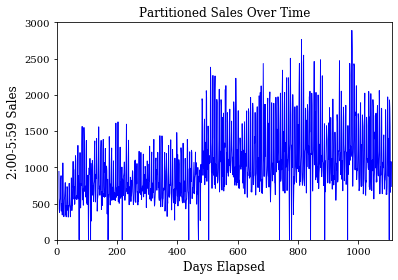

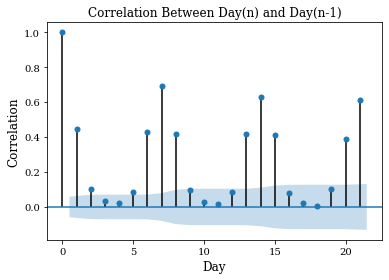

In [82]:
plt.plot(data['2to5'], "b", linewidth=.9)
plt.title("Partitioned Sales Over Time")
plt.xlabel("Days Elapsed", fontsize=12)
plt.ylabel("2:00-5:59 Sales", fontsize=12)
plt.axis([0,1111,0,3000])
plt.savefig(fname='Charts/2to5SalesActual.png',dpi=150)
plt.show();


plot_acf(data['2to5'], lags=21)
plt.title("Correlation Between Day(n) and Day(n-1)")
plt.xlabel("Day", fontsize=12)
plt.ylabel("Correlation", fontsize=12)
plt.savefig(fname='Charts/2to5AFCActual.png',dpi=150)
plt.show();

#### Differenced Dataset

To find remove trend me may difference daily. To remove weekly seasonality, we difference weekly. We must remove 14 days in order to properly difference and aquire statistical information, but we will only lose 7 more days than usual. 

In [83]:
diff_data = pd.read_csv('Data/RestaurantDataVets_All_2to5_Differenced.csv')
diff_data=diff_data.drop([x for x in range(14)])
diff_data["WeeklyDifference"] = diff_data.WeeklyDifference.astype(float)
diff_data["DailyDifference"] = diff_data.DailyDifference.astype(float)
diff_data["AvgWeeklyDiff"] = diff_data.AvgWeeklyDiff.astype(float)

diff_data

Index  Group        DMY  MissingPrevDays  Year  Day  January  February  \
14       15      0  9/25/2016                0  2016   25        0         0   
15       16      0  9/26/2016                0  2016   26        0         0   
16       17      0  9/27/2016                0  2016   27        0         0   
17       18      0  9/28/2016                0  2016   28        0         0   
18       19      0  9/29/2016                0  2016   29        0         0   
...     ...    ...        ...              ...   ...  ...      ...       ...   
1106   1107      0  12/1/2019                0  2019    1        0         0   
1107   1108      0  12/2/2019                0  2019    2        0         0   
1108   1109      0  12/3/2019                0  2019    3        0         0   
1109   1110      0  12/4/2019                0  2019    4        0         0   
1110   1111      0  12/5/2019                0  2019    5        0         0   

      March  April  May  June  July  August  September  October  November  \
14        0      0    0     0     0       0          1        0         0   
15        0      0    0     0     0       0          1        0         0   
16        0      0    0     0     0       0          1        0         0   
17        0      0    0     0     0       0          1        0         0   
18        0      0    0     0     0       0          1        0         0   
...     ...    ...  ...   ...   ...     ...        ...      ...       ...   
1106      0      0    0     0     0       0          0        0         0   
1107      0      0    0     0     0       0          0        0         0   
1108      0      0    0     0     0       0          0        0         0   
1109      0      0    0     0     0       0          0        0         0   
1110      0      0    0     0     0       0          0        0         0   

      December  Sunday  Monday  Tuesday  Wednesday  Thursday  Friday  \
14           0       1       0        0          0         0       0   
15           0       0       1        0          0         0       0   
16           0       0       0        1          0         0       0   
17           0       0       0        0          1         0       0   
18           0       0       0        0          0         1       0   
...        ...     ...     ...      ...        ...       ...     ...   
1106         1       1       0        0          0         0       0   
1107         1       0       1        0          0         0       0   
1108         1       0       0        1          0         0       0   
1109         1       0       0        0          1         0       0   
1110         1       0       0        0          0         1       0   

      Saturday  Holiday  Carnival  LentFasting  Ramadan  ChristmasSeason  \
14           0        0         0            0        0                0   
15           0        0         0            0        0                0   
16           0        0         0            0        0                0   
17           0        0         0            0        0                0   
18           0        0         0            0        0                0   
...        ...      ...       ...          ...      ...              ...   
1106         0        0         0            0        0                1   
1107         0        0         0            0        0                1   
1108         0        0         0            0        0                1   
1109         0        0         0            0        0                1   
1110         0        0         0            0        0                1   

        DailyAvg   WeeklyAvg MinSales MaxSales DailyBusyness WeeklyBusyness  \
14     559.68143     804.695   320.54   942.94       0.38422        0.77788   
15       581.336      451.52   320.54   942.94       0.41902        0.21044   
16     569.84563      349.45   320.54   942.94       0.40056        0.04645   
17     565.71176     393.2

<b>Daily difference shape.

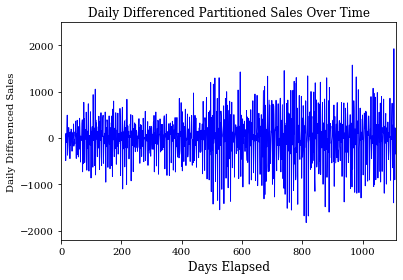

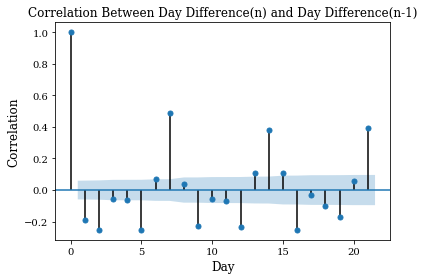

In [84]:
plt.plot(diff_data['DailyDifference'], "b", linewidth=.9)
plt.title("Daily Differenced Partitioned Sales Over Time")
plt.xlabel("Days Elapsed", fontsize=12)
plt.ylabel("Daily Differenced Sales", fontsize=10)
plt.axis([0,1111,-2200,2500])
plt.savefig(fname='Charts/2to5DailyDiff.png',dpi=150)
plt.show();

plot_acf(diff_data['DailyDifference'], lags=21)
plt.title("Correlation Between Day Difference(n) and Day Difference(n-1)")
plt.xlabel("Day", fontsize=12)
plt.ylabel("Correlation", fontsize=12)
plt.savefig(fname='Charts/2to5AFCDailyDiff.png',dpi=150)
plt.show();

<b> Weekly difference shape.

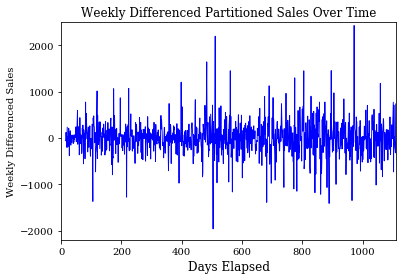

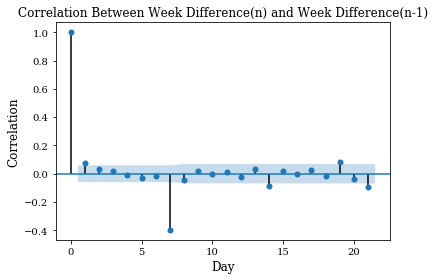

In [85]:
plt.plot(diff_data['WeeklyDifference'], "b", linewidth=.9)
plt.title("Weekly Differenced Partitioned Sales Over Time")
plt.xlabel("Days Elapsed", fontsize=12)
plt.ylabel("Weekly Differenced Sales", fontsize=10)
plt.axis([0,1111,-2200,2500])
plt.savefig(fname='Charts/2to5WeeklyDiff.png',dpi=150)
plt.show()


plot_acf(diff_data['WeeklyDifference'], lags=21)
plt.title("Correlation Between Week Difference(n) and Week Difference(n-1)")
plt.xlabel("Day", fontsize=12)
plt.ylabel("Correlation", fontsize=12)
plt.savefig(fname='Charts/2to5AFCWeeklyDiff.png',dpi=150)
plt.show();

## One Day Forecast Window

In [86]:
def plot_series(time, series, label, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end],label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

### Baselines

#### Predicting Actual

In [87]:
data['WeeklyAvg']=data['WeeklyAvg'].astype(float)

price_series = data['2to5'].squeeze().to_numpy()
week_avg_series = data['WeeklyAvg'].squeeze().to_numpy()

price_test=price_series[train_time:]

time = np.arange(1104, dtype="float32")
time_series = time[train_time:]

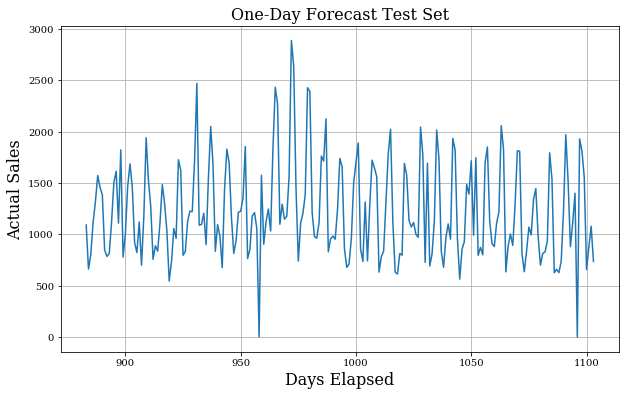

In [95]:
plt.figure(figsize=(10, 6))
plot_series(time[train_time:], price_test,label="Actual")
plt.title("One-Day Forecast Test Set",fontsize=16)
plt.xlabel("Days Elapsed", fontsize=16)
plt.ylabel("Actual Sales", fontsize=16)
plt.savefig(fname='Charts/TestShapeActual.png',dpi=150)
plt.show()

<b>First solution.</b> Predict today with last week's values.

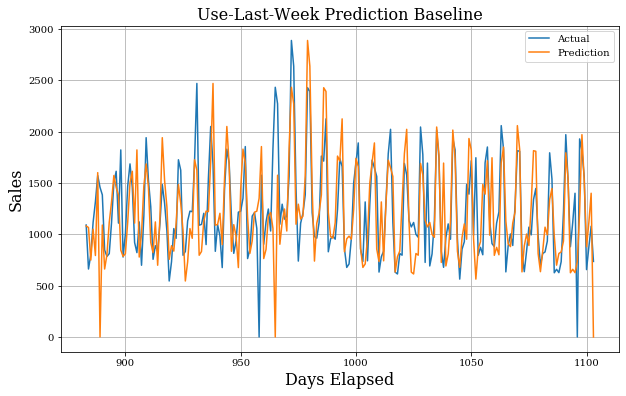

157401.3608963801
278.49135746606333


In [106]:
price_test=price_series[train_time:]
naive_forecast1 = price_series[train_time - 7:-7]

plt.figure(figsize=(10, 6))
plot_series(time[train_time:], price_test,label="Actual")
plot_series(time[train_time:], naive_forecast1,label="Prediction")
plt.title("Use-Last-Week Prediction Baseline",fontsize=16)
plt.xlabel("Days Elapsed", fontsize=16)
plt.ylabel("Sales", fontsize=16)
plt.legend(loc="upper right")
plt.savefig(fname='Charts/UseLastWeekPredictonActual.png',dpi=150)
plt.show()

print(keras.metrics.mean_squared_error(price_test, naive_forecast1).numpy())
print(keras.metrics.mean_absolute_error(price_test, naive_forecast1).numpy())

<b>Second solution.</b> The mean weekday value averaged with last weeks sales. 403

We are testing 221 days to get a baseline.


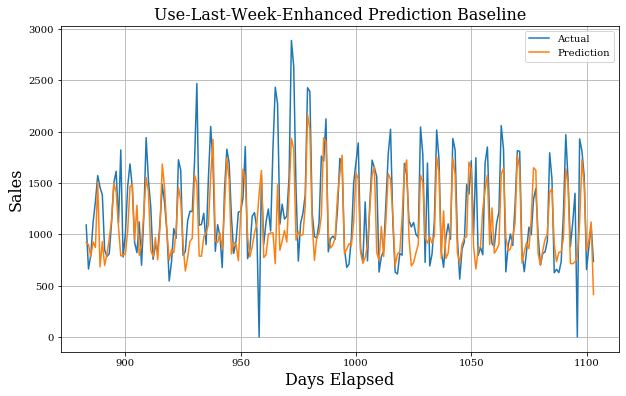

115220.87136327871
239.755661809276


In [90]:
print("We are testing " + str(len(price_test)) + " days to get a baseline.")

naive_forecast2 = (price_series[train_time - 7:-7]+week_avg_series[train_time:])/2


plt.figure(figsize=(10, 6))
plot_series(time_series, price_test, label='Actual')
plot_series(time_series, naive_forecast2, label='Prediction')
plt.title("Use-Last-Week-Enhanced Prediction Baseline",fontsize=16)
plt.xlabel("Days Elapsed", fontsize=16)
plt.ylabel("Sales", fontsize=16)
plt.legend(loc="upper right")
plt.savefig(fname='Charts/MeanWithLastWeekPredictonActual.png',dpi=150)
plt.show()
print(keras.metrics.mean_squared_error(price_test, naive_forecast2).numpy())
print(keras.metrics.mean_absolute_error(price_test, naive_forecast2).numpy())

#### Predicting Difference

Here we explore additional baselines that aim to predict the difference directly. It is of note that the error on finding the difference will be the same once the difference has been added back to the original series. As such, we find that these baselines are worse than the previous ones and may be disregarded. 

<b>First solution.</b> Predict today difference with last week's difference.

In [91]:

diff_series = diff_data['DailyDifference']
diff_time = np.arange(1097, dtype="float32")

diff_naive_forecast1 = diff_series[train_time - 7:-7]

diff_test=diff_series[train_time:].to_numpy()

diff_time_series = diff_time[train_time:]

print("We are testing " + str(len(diff_test)) + " days to get a baseline.")


We are testing 214 days to get a baseline.


C:\Users\Austin\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\Austin\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


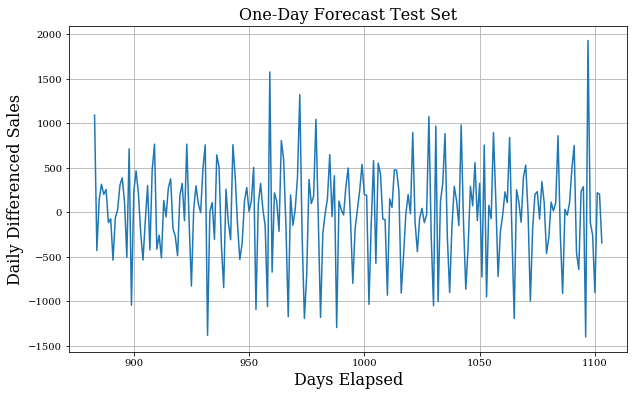

In [92]:
diff_series = diff_data['DailyDifference']
plt.figure(figsize=(10, 6))

plot_series(time[train_time:], diff_series[train_time-7:], label='Actual')
plt.title("One-Day Forecast Test Set",fontsize=16)
plt.xlabel("Days Elapsed", fontsize=16)
plt.ylabel("Daily Differenced Sales", fontsize=16)
plt.savefig(fname='Charts/TestShapeDailyDiff.png',dpi=150)
plt.show()

In [93]:
plt.figure(figsize=(10, 6))
plot_series(diff_time_series, diff_test)
plot_series(diff_time_series, diff_naive_forecast1)
plt.savefig(fname='Charts/LastWeekPredictonDailyDiff.png',dpi=150)
plt.show()

TypeError: plot_series() missing 1 required positional argument: 'label'

<Figure size 720x432 with 0 Axes>

In [94]:
print(keras.metrics.mean_squared_error(diff_test, diff_naive_forecast1).numpy())
print(keras.metrics.mean_absolute_error(diff_test, diff_naive_forecast1).numpy())

279119.34944626165
392.65939252336443


### Scikit Learn Models

#### Imports

In [61]:
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import ExtraTreesRegressor 
from sklearn.ensemble import RandomForestRegressor

from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from mlxtend.regressor import StackingCVRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor 
from sklearn.kernel_ridge import KernelRidge

from xgboost.sklearn import XGBRegressor

from sklearn import preprocessing

from sklearn.model_selection import train_test_split

from sklearn.feature_selection import f_regression, SelectKBest

from sklearn.metrics import  max_error, mean_absolute_error, mean_squared_error

In [62]:
#We apply one hot encoding for the Holiday feature to help linear models 
def onehotholiday(select):
    X_2 = select[['Holiday']]
    enc = preprocessing.OneHotEncoder(sparse=False)
    enc.fit(X_2)
    onehotlabels = enc.transform(X_2)
    # creating a list of column names 
    column_values = []
    for i in range(np.shape(onehotlabels)[1]):
            column_values.append('A'+str(i))

    onehotholiday = pd.DataFrame(data = onehotlabels,columns = column_values)
    dataset = select.drop(columns=['Holiday'])
    dataset = select.join(onehotholiday)
    df1 = dataset.pop('2to5')
    dataset['2to5']=df1 # add b series as a 'new' column
    dataset2=dataset
    dataset2 = dataset2.drop(columns=['Holiday'])
    dataset2.to_csv('umm.csv')
    return dataset2

    
def onehotholidaydiff(select, col):
    X_2 = select[['Holiday']]
    # TODO: create a OneHotEncoder object, and fit it to all of X
    # 1. INSTANTIATE
    enc = preprocessing.OneHotEncoder(sparse=False)
    
    # 2. FIT
    enc.fit(X_2)
    
    # 3. Transform
    onehotlabels = enc.transform(X_2)
    # creating a list of column names 
    column_values = []
    for i in range(np.shape(onehotlabels)[1]):
            column_values.append('A'+str(i))

    # creating the dataframe 
    onehotholiday = pd.DataFrame(data = onehotlabels,columns = column_values)

    dataset = select.drop(columns=['Holiday'])
    dataset = select.join(onehotholiday)
    df1 = dataset.pop(col)
    dataset[col]=df1 # add b series as a 'new' column
    dataset2=dataset
    dataset2 = dataset2.drop(columns=['Holiday'])
    return dataset2
    
def diff_add_lookback(dataset, look_back, df, col):
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back)][col]
        a = a.values
        for j in range(len(a)):
            df[j][i]= a[j]
    return df

def add_lookback(dataset, look_back, df):
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back)]['2to5']
        a = a.values
        for j in range(len(a)):
            df[j][i]= a[j]
    return df


#### Predicting Actual

In testing one day forecasting, we found 6 Scikit learn candidate models that performed well. We train using an optimal number of features for the model on the described training set and then display the test results.

Each model will follow the following pipeline: <br>
1) Apply 14 days of lookback for training. <br>
2) Hot encoding on Holiday feature. <br>
3) Scaling from sklearn RobustScaler. <br>
4) Find k-best features where k was determined in earlier testing for each model. <br>
5) The model is fit on training data. <br> 
6) Find accuracy metrics using the testing data. <br> 

First, we conduct our first three preprocessing steps once since this step will be the same for all Scikit models.

In [63]:
# fix random seed for reproducibility
np.random.seed(42)
# load the dataset
dataframe = pd.read_csv('Data/RestaurantDataVets_All_2to5.csv')
data = dataframe.drop(columns=['Index','DMY','MissingPrevDays'])

lookback=14
dataframe_removed_lookback = data.drop([x for x in range(lookback)])

for i in range(lookback):
    dataframe_removed_lookback[i] = 1.0
    
df = dataframe_removed_lookback[['Year', 'Day', 'January','February',
                         'March','April','May','June','July',
                         'August', 'September', 'October', 'November',
                         'December','Sunday', 'Monday', 'Tuesday',
                         'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Holiday', 'Carnival', 
                         'LentFasting','Ramadan','ChristmasSeason',
                         0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                         'DailyAvg','WeeklyAvg','MinSales','MaxSales','DailyBusyness',
                         'WeeklyBusyness','2to5']]
df = df.reset_index(drop=True)

#Objects need to be converted to float due to missing values at load time.
df["DailyAvg"] = df.DailyAvg.astype(float)
df["WeeklyAvg"] = df.WeeklyAvg.astype(float)
df["MinSales"] = df.MinSales.astype(float)
df["MaxSales"] = df.MaxSales.astype(float)
df["DailyBusyness"] = df.DailyBusyness.astype(float)
df["WeeklyBusyness"] = df.WeeklyBusyness.astype(float)

lb_data = add_lookback(data, lookback, df)
lb_data = lb_data.reset_index(drop=True)
hotdata = onehotholiday(lb_data)

numcols = len(hotdata.columns)
dataset = hotdata.values

print("train_df Shape:" ,lb_data.shape)
print("After encoding:", hotdata.shape)

X=dataset[:, 0:numcols-1]
y=dataset[:, numcols-1]

scaler = preprocessing.RobustScaler()
X = scaler.fit_transform(X,y)


C:\Users\Austin\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


train_df Shape: (1097, 47)
After encoding: (1097, 74)


In [64]:
hotdata

Year  Day  January  February  March  April  May  June  July  August  \
0     2016   25        0         0      0      0    0     0     0       0   
1     2016   26        0         0      0      0    0     0     0       0   
2     2016   27        0         0      0      0    0     0     0       0   
3     2016   28        0         0      0      0    0     0     0       0   
4     2016   29        0         0      0      0    0     0     0       0   
...    ...  ...      ...       ...    ...    ...  ...   ...   ...     ...   
1092  2019    1        0         0      0      0    0     0     0       0   
1093  2019    2        0         0      0      0    0     0     0       0   
1094  2019    3        0         0      0      0    0     0     0       0   
1095  2019    4        0         0      0      0    0     0     0       0   
1096  2019    5        0         0      0      0    0     0     0       0   

      September  October  November  December  Sunday  Monday  Tuesday  \
0             1        0         0         0       1       0        0   
1             1        0         0         0       0       1        0   
2             1        0         0         0       0       0        1   
3             1        0         0         0       0       0        0   
4             1        0         0         0       0       0        0   
...         ...      ...       ...       ...     ...     ...      ...   
1092          0        0         0         1       1       0        0   
1093          0        0         0         1       0       1        0   
1094          0        0         0         1       0       0        1   
1095          0        0         0         1       0       0        0   
1096          0        0         0         1       0       0        0   

      Wednesday  Thursday  Friday  Saturday  Carnival  LentFasting  Ramadan  \
0             0         0       0         0         0            0        0   
1             0         0       0         0         0            0        0   
2             0         0       0         0         0            0        0   
3             1         0       0         0         0            0        0   
4             0         1       0         0         0            0        0   
...         ...       ...     ...       ...       ...          ...      ...   
1092          0         0       0         0         0            0        0   
1093          0         0       0         0         0            0        0   
1094          0         0       0         0         0            0        0   
1095          1         0       0         0         0            0        0   
1096          0         1       0         0         0            0        0   

      ChristmasSeason        0        1        2        3        4        5  \
0                   0   666.45   475.49   320.54   365.61   494.99   540.93   
1                   0   475.49   320.54   365.61   494.99   540.93   862.04   
2                   0   320.54   365.61   494.99   540.93   862.04   942.94   
3                   0   365.61   494.99   540.93   862.04   942.94   427.55   
4                   0   494.99   540.93   862.04   942.94   427.55   378.36   
...               ...      ...      ...      ...      ...      ...      ...   
1092                1  1538.60   625.75   659.24   626.92   733.80  1219.97   
1093                1   625.75   659.24   626.92   733.80  1219.97  1971.24   
1094                1   659.24   626.92   733.80  1219.97  1971.24  1522.05   
1095                1   626.92   733.80  1219.97  1971.24  1522.05   879.36   
1096                1   733.80  1219.97  1971.24  1522.05   879.36  1113.01   

            6        7        8        9       10       11       12       13  \
0      862.04   942.94   427.55   378.36   420.98   541.16   574.29   824.21   
1      942.94   427.55   378.36   420.98   541.16   574.29   824.21   884.50   
2      427.55   378.36   420.98   541.16   574.29   824.21   884.5

<b>Linear Regression

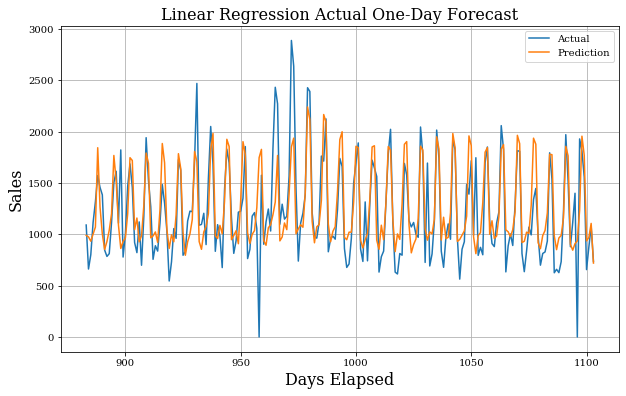

96371.55441790514
221.80825690536494


In [68]:
lr = LinearRegression()

feat_reduction = SelectKBest(f_regression, k=3) 
X_new = feat_reduction.fit_transform(X,y)

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=221, random_state=42, shuffle=False)

lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

plt.figure(figsize=(10, 6))
plot_series(time_series, y_test,label='Actual')
plot_series(time_series, y_pred,label='Prediction')
plt.title("Linear Regression Actual One-Day Forecast",fontsize=16)
plt.xlabel("Days Elapsed", fontsize=16)
plt.ylabel("Sales", fontsize=16)
plt.legend(loc="upper right")
plt.savefig(fname='Charts/LinearRegPredictonActual.png',dpi=150)
plt.show()
print(keras.metrics.mean_squared_error(y_test, y_pred).numpy())
print(keras.metrics.mean_absolute_error(y_test, y_pred).numpy())

<b>Stochastic Gradient Decent Regression

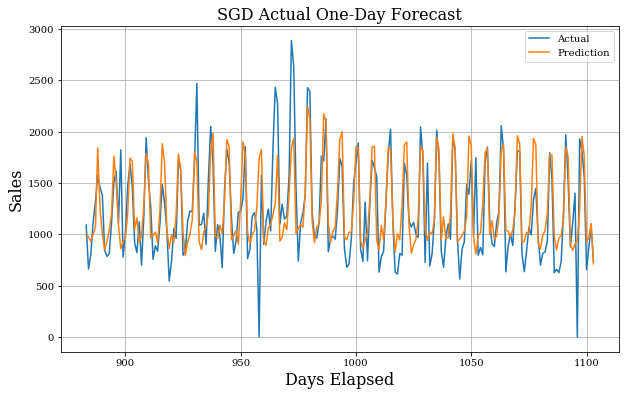

96606.37368711023
221.82251514492603


In [69]:
sgd = SGDRegressor()

feat_reduction = SelectKBest(f_regression, k=3) 
X_new = feat_reduction.fit_transform(X,y)

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=221, random_state=42, shuffle=False)

sgd.fit(X_train, y_train)
y_pred = sgd.predict(X_test)

plt.figure(figsize=(10, 6))
plot_series(time_series, y_test,label='Actual')
plot_series(time_series, y_pred,label='Prediction')
plt.title("SGD Actual One-Day Forecast",fontsize=16)
plt.xlabel("Days Elapsed", fontsize=16)
plt.ylabel("Sales", fontsize=16)
plt.legend(loc="upper right")
plt.savefig(fname='Charts/SGDPredictonActual.png',dpi=150)
plt.show()
print(keras.metrics.mean_squared_error(y_test, y_pred).numpy())
print(keras.metrics.mean_absolute_error(y_test, y_pred).numpy())

<b>Ridge Regression

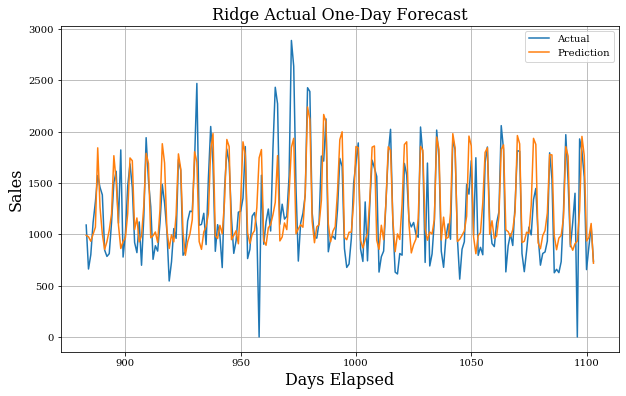

96394.02366992872
221.71914185822573


In [70]:
ridge = Ridge(alpha=1.0)

feat_reduction = SelectKBest(f_regression, k=3) 
X_new = feat_reduction.fit_transform(X,y)

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=221, random_state=42, shuffle=False)

ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)

plt.figure(figsize=(10, 6))
plot_series(time_series, y_test,label='Actual')
plot_series(time_series, y_pred,label='Prediction')
plt.title("Ridge Actual One-Day Forecast",fontsize=16)
plt.xlabel("Days Elapsed", fontsize=16)
plt.ylabel("Sales", fontsize=16)
plt.legend(loc="upper right")
plt.savefig(fname='Charts/RidgePredictonActual.png',dpi=150)
plt.show()
print(keras.metrics.mean_squared_error(y_test, y_pred).numpy())
print(keras.metrics.mean_absolute_error(y_test, y_pred).numpy())

<b> Lasso CV

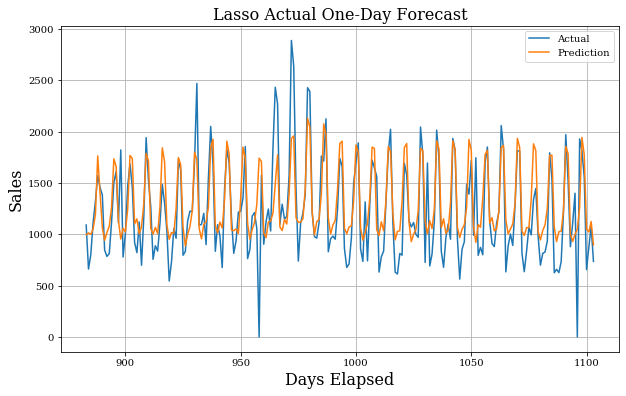

95559.00548090784
226.7576644110481


In [71]:
Lcv = LassoCV(cv=5, random_state=0)

feat_reduction = SelectKBest(f_regression, k=16) 
X_new = feat_reduction.fit_transform(X,y)

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=221, random_state=42, shuffle=False)

Lcv.fit(X_train, y_train)
y_pred = Lcv.predict(X_test)

plt.figure(figsize=(10, 6))
plot_series(time_series, y_test,label='Actual')
plot_series(time_series, y_pred,label='Prediction')
plt.title("Lasso Actual One-Day Forecast",fontsize=16)
plt.xlabel("Days Elapsed", fontsize=16)
plt.ylabel("Sales", fontsize=16)
plt.legend(loc="upper right")
plt.savefig(fname='Charts/LassoPredictonActual.png',dpi=150)
plt.show()
print(keras.metrics.mean_squared_error(y_test, y_pred).numpy())
print(keras.metrics.mean_absolute_error(y_test, y_pred).numpy())

<b>Bayesian Ridge Regression

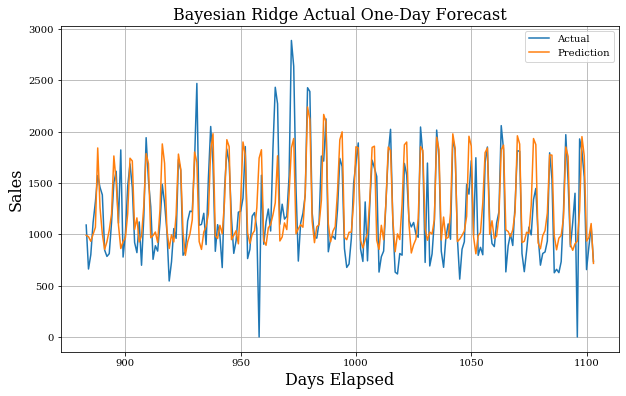

96420.05677007914
221.62526734606604


In [96]:
bridge = BayesianRidge()

feat_reduction = SelectKBest(f_regression, k=3) 
X_new = feat_reduction.fit_transform(X,y)

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=221, random_state=42, shuffle=False)

bridge.fit(X_train, y_train)
y_pred = bridge.predict(X_test)

plt.figure(figsize=(10, 6))
plot_series(time_series, y_test,label='Actual')
plot_series(time_series, y_pred,label='Prediction')
plt.title("Bayesian Ridge Actual One-Day Forecast",fontsize=16)
plt.xlabel("Days Elapsed", fontsize=16)
plt.ylabel("Sales", fontsize=16)
plt.legend(loc="upper right")
plt.savefig(fname='Charts/BRidgePredictonActual.png',dpi=150)
plt.show()
print(keras.metrics.mean_squared_error(y_test, y_pred).numpy())
print(keras.metrics.mean_absolute_error(y_test, y_pred).numpy())

<b>Extra Trees Regression

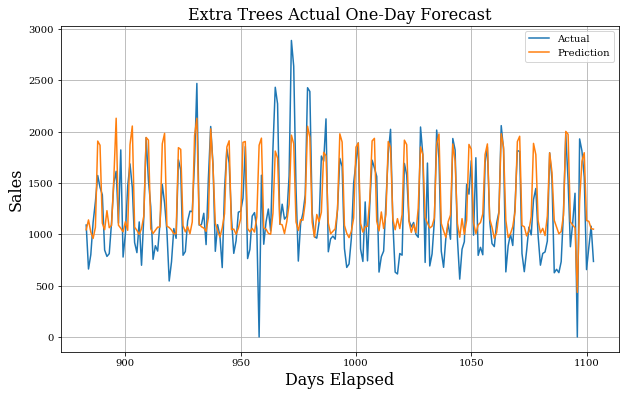

97820.21711259933
231.53655506787277


In [97]:
et  = ExtraTreesRegressor(n_estimators=1000, random_state=0,n_jobs=5)

feat_reduction = SelectKBest(f_regression, k=29) 
X_new = feat_reduction.fit_transform(X,y)

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=221, random_state=42, shuffle=False)

et.fit(X_train, y_train)
y_pred = et.predict(X_test)

plt.figure(figsize=(10, 6))
plot_series(time_series, y_test,label='Actual')
plot_series(time_series, y_pred,label='Prediction')
plt.title("Extra Trees Actual One-Day Forecast",fontsize=16)
plt.xlabel("Days Elapsed", fontsize=16)
plt.ylabel("Sales", fontsize=16)
plt.legend(loc="upper right")
plt.savefig(fname='Charts/ETPredictonActual.png',dpi=150)
plt.show()
print(keras.metrics.mean_squared_error(y_test, y_pred).numpy())
print(keras.metrics.mean_absolute_error(y_test, y_pred).numpy())

<b> K Neighbor Regression

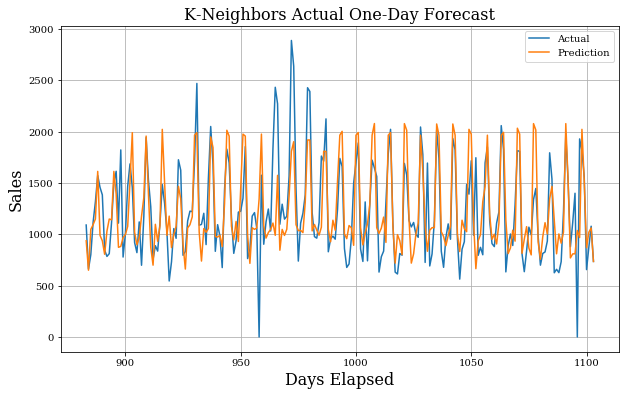

116752.76098415366
248.72599870717517


In [98]:
neigh = KNeighborsRegressor(n_neighbors=7)

feat_reduction = SelectKBest(f_regression, k=2) 
X_new = feat_reduction.fit_transform(X,y)

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=221, random_state=42, shuffle=False)

neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)

plt.figure(figsize=(10, 6))
plot_series(time_series, y_test,label='Actual')
plot_series(time_series, y_pred,label='Prediction')
plt.title("K-Neighbors Actual One-Day Forecast",fontsize=16)
plt.xlabel("Days Elapsed", fontsize=16)
plt.ylabel("Sales", fontsize=16)
plt.legend(loc="upper right")
plt.savefig(fname='Charts/KNeighPredictonActual.png',dpi=150)
plt.show()
print(keras.metrics.mean_squared_error(y_test, y_pred).numpy())
print(keras.metrics.mean_absolute_error(y_test, y_pred).numpy())

<b>Stacking Regression</b> <br>
Voting party includes: Linear Regressor, K-Nearest Regressor, MLP Regressor, Ridge Regressor, Extra Trees Regressor

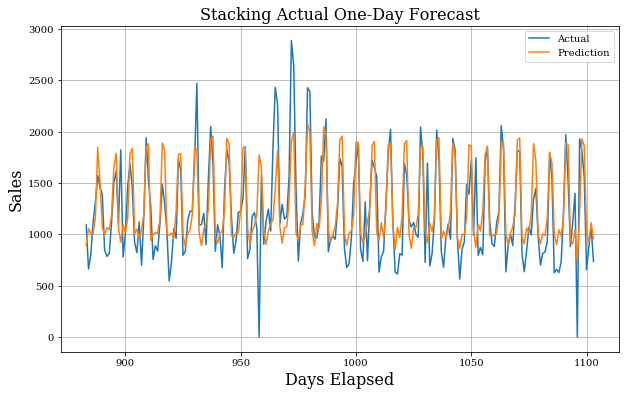

91774.75765060406
220.18582996726235


In [99]:
stack_neigh = KNeighborsRegressor(n_neighbors=7)
LR = LinearRegression()
rid = Ridge(alpha=1.0)
et = ExtraTreesRegressor(n_estimators=1000, random_state=0)

stack = StackingCVRegressor(regressors=(LR, rid, et, stack_neigh),
                            meta_regressor=rid, 
                            random_state=42,
                            use_features_in_secondary=True)

feat_reduction = SelectKBest(f_regression, k=25) 
X_new = feat_reduction.fit_transform(X,y)

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=221, random_state=42, shuffle=False)

stack.fit(X_train, y_train)
y_pred = stack.predict(X_test)

plt.figure(figsize=(10, 6))
plot_series(time_series, y_test,label='Actual')
plot_series(time_series, y_pred,label='Prediction')
plt.title("Stacking Actual One-Day Forecast",fontsize=16)
plt.xlabel("Days Elapsed", fontsize=16)
plt.ylabel("Sales", fontsize=16)
plt.legend(loc="upper right")
plt.savefig(fname='Charts/StackingPredictonActual.png',dpi=150)
plt.show()
print(keras.metrics.mean_squared_error(y_test, y_pred).numpy())
print(keras.metrics.mean_absolute_error(y_test, y_pred).numpy())

#### Predicting Difference

Similarly to the above, we feature the top five models tested with the optimal number of features available to acheive the best result.

We create both a daily differenced dataset and a weekly differenced dataset.

In [100]:
# fix random seed for reproducibility
np.random.seed(8)
# load the dataset
dataframe = pd.read_csv('Data/RestaurantDataVets_All_2to5_Differenced.csv')
data = dataframe.drop(columns=['Index','DMY','MissingPrevDays','DiffDifference','2to5'])

lookback=14
dataframe_removed_lookback = data.drop([x for x in range(lookback)])
for i in range(lookback):
    dataframe_removed_lookback[i] = 1.0


df = dataframe_removed_lookback[['Year', 'Day', 'January','February',
                         'March','April','May','June','July',
                         'August', 'September', 'October', 'November',
                         'December','Sunday', 'Monday', 'Tuesday',
                         'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Holiday', 'Carnival', 
                         'LentFasting','Ramadan','ChristmasSeason', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 
                         'DailyAvg','WeeklyAvg','MinSales','MaxSales','DailyBusyness',
                          'WeeklyBusyness','AvgDailyDiff','AvgWeeklyDiff','MinDailyDiff',
                         'MaxDailyDiff', 'WeeklyDifference',
                        'DailyDifference']]

df = df.reset_index(drop=True)

#Objects need to be converted to float due to missing values at load time.
df["DailyAvg"] = df.DailyAvg.astype(float)
df["WeeklyAvg"] = df.WeeklyAvg.astype(float)
df["MinSales"] = df.MinSales.astype(float)
df["MaxSales"] = df.MaxSales.astype(float)
df["DailyBusyness"] = df.DailyBusyness.astype(float)
df["WeeklyBusyness"] = df.WeeklyBusyness.astype(float)


df["AvgDailyDiff"] = df.AvgDailyDiff.astype(float)
df["AvgWeeklyDiff"] = df.AvgWeeklyDiff.astype(float)
df["MaxDailyDiff"] = df.MaxDailyDiff.astype(float)
df["MinDailyDiff"] = df.MinDailyDiff.astype(float)
df["DailyDifference"] = df.DailyDifference.astype(float)
df["WeeklyDifference"] = df.WeeklyDifference.astype(float)

df2 = df.copy()
data2 = data.copy()
diff_add_lookback(data, lookback, df,'WeeklyDifference')
diff_add_lookback(data2, lookback, df2,'DailyDifference')

hotdata_week = onehotholidaydiff(df, 'WeeklyDifference')
hotdata_day = onehotholidaydiff(df2, 'DailyDifference')

hotdata_week = hotdata_week.drop([x for x in range(7)])
hotdata_week = hotdata_week.reset_index(drop=True)

hotdata_day = hotdata_day.drop([x for x in range(1)])
hotdata_day= hotdata_day.reset_index(drop=True)


cols = hotdata_week.columns[hotdata_week.dtypes.eq('object')]
hotdata_week[cols] = hotdata_week[cols].apply(pd.to_numeric, errors='coerce', axis=1)

cols2 = hotdata_day.columns[hotdata_day.dtypes.eq('object')]
hotdata_day[cols2] = hotdata_day[cols2].apply(pd.to_numeric, errors='coerce', axis=1)

numcols = len(hotdata_week.columns)-1

print("train_df Shape:" ,data.shape)
print("After encoding:", hotdata_week.shape)

weekly_difference_data = hotdata_week.drop(columns=['DailyDifference'])
weekly_difference_data = weekly_difference_data.values

daily_difference_data = hotdata_day.drop(columns=['WeeklyDifference'])
daily_difference_data = daily_difference_data.values

C:\Users\Austin\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Austin\Anaconda3\lib\site-packages\pandas\core\indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


train_df Shape: (1111, 39)
After encoding: (1090, 79)


In [101]:
hotdata_week

Year  Day  January  February  March  April  May  June  July  August  \
0     2016    2        0         0      0      0    0     0     0       0   
1     2016    3        0         0      0      0    0     0     0       0   
2     2016    4        0         0      0      0    0     0     0       0   
3     2016    5        0         0      0      0    0     0     0       0   
4     2016    6        0         0      0      0    0     0     0       0   
...    ...  ...      ...       ...    ...    ...  ...   ...   ...     ...   
1085  2019    1        0         0      0      0    0     0     0       0   
1086  2019    2        0         0      0      0    0     0     0       0   
1087  2019    3        0         0      0      0    0     0     0       0   
1088  2019    4        0         0      0      0    0     0     0       0   
1089  2019    5        0         0      0      0    0     0     0       0   

      September  October  November  December  Sunday  Monday  Tuesday  \
0             0        1         0         0       1       0        0   
1             0        1         0         0       0       1        0   
2             0        1         0         0       0       0        1   
3             0        1         0         0       0       0        0   
4             0        1         0         0       0       0        0   
...         ...      ...       ...       ...     ...     ...      ...   
1085          0        0         0         1       1       0        0   
1086          0        0         0         1       0       1        0   
1087          0        0         0         1       0       0        1   
1088          0        0         0         1       0       0        0   
1089          0        0         0         1       0       0        0   

      Wednesday  Thursday  Friday  Saturday  Carnival  LentFasting  Ramadan  \
0             0         0       0         0         0            0        0   
1             0         0       0         0         0            0        0   
2             0         0       0         0         0            0        0   
3             1         0       0         0         0            0        0   
4             0         1       0         0         0            0        0   
...         ...       ...     ...       ...       ...          ...      ...   
1085          0         0       0         0         0            0        0   
1086          0         0       0         0         0            0        0   
1087          0         0       0         0         0            0        0   
1088          1         0       0         0         0            0        0   
1089          0         1       0         0         0            0        0   

      ChristmasSeason       0       1       2       3       4       5       6  \
0                   0  276.49  -47.94   57.82   55.37   46.17   33.36  -37.83   
1                   0  -47.94   57.82   55.37   46.17   33.36  -37.83  -58.44   
2                   0   57.82   55.37   46.17   33.36  -37.83  -58.44  -30.06   
3                   0   55.37   46.17   33.36  -37.83  -58.44  -30.06  121.21   
4                   0   46.17   33.36  -37.83  -58.44  -30.06  121.21   12.58   
...               ...     ...     ...     ...     ...     ...     ...     ...   
1085                1   91.84 -358.63  -40.42 -186.77  -94.58  285.25  176.63   
1086                1 -358.63  -40.42 -186.77  -94.58  285.25  176.63  -16.55   
1087                1  -40.42 -186.77  -94.58  285.25  176.63  -16.55  253.61   
1088                1 -186.77  -94.58  285.25  176.63  -16.55  253.61  453.77   
1089                1  -94.58  285.25  176.63  -16.55  253.61  453.77  773.58   

           7       8       9      10      11      12      13    DailyAvg  \
0     -58.44  -30.06  121.21   12.58 -198.79   -8.30  235.90   572.33952   
1     -30.06  121.21   12.58 -198.79   -8.30  235.90 -197.85   577.53545   
2     121.21   12.58 -198.79   -8.30  235.90 -197.85  

<b> Daily Difference

Scaling Daily Differenced dataset. Prediction target is the difference of one day.

In [102]:
X=daily_difference_data[:, 0:numcols-1]
y=daily_difference_data[:, numcols-1]

scaler = preprocessing.RobustScaler()
X = scaler.fit_transform(X,y)

<b> Linear Regression

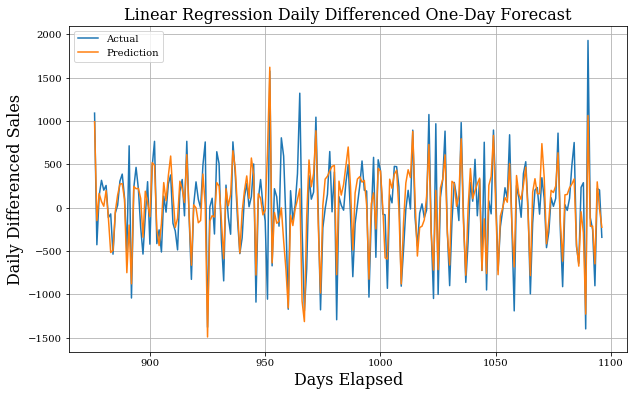

93666.68563487614
219.58711223189985


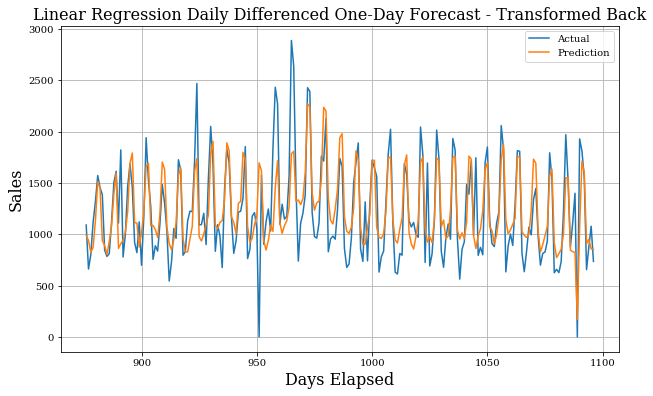

93666.68563487614
219.58711223189985


In [109]:
lr = LinearRegression()

feat_reduction = SelectKBest(f_regression, k=41) 
X_new = feat_reduction.fit_transform(X,y)

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=221, random_state=42, shuffle=False)

lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

plt.figure(figsize=(10, 6))
plt.title('Difference Forecast')
plot_series(diff_time[-221:], y_test,label='Actual')
plot_series(diff_time[-221:], y_pred,label='Prediction')
plt.title("Linear Regression Daily Differenced One-Day Forecast",fontsize=16)
plt.xlabel("Days Elapsed", fontsize=16)
plt.ylabel("Daily Differenced Sales", fontsize=16)
plt.legend(loc="best")
plt.savefig(fname='Charts/LinearRegPredictonDailyDiff.png',dpi=150)
plt.show()
print(keras.metrics.mean_squared_error(y_test, y_pred).numpy())
print(keras.metrics.mean_absolute_error(y_test, y_pred).numpy())

#Adding predicted difference to get final results.
added_back = price_series[-222:-1] + y_pred
y_true = price_series[-221:] 
plt.figure(figsize=(10, 6))
plt.title('Transformed To Actual')
plot_series(diff_time[-221:], y_true,label='Actual')
plot_series(diff_time[-221:], added_back,label='Prediction')
plt.title("Linear Regression Daily Differenced One-Day Forecast - Transformed Back",fontsize=16)
plt.xlabel("Days Elapsed", fontsize=16)
plt.ylabel("Sales", fontsize=16)
plt.legend(loc="upper right")
plt.savefig(fname='Charts/LinearRegPredictonDailyDiffAB.png',dpi=150)
plt.show()
print(keras.metrics.mean_squared_error(y_true, added_back).numpy())
print(keras.metrics.mean_absolute_error(y_true, added_back).numpy())

<b> Lasso CV

96715.85682149808
223.04327909198142


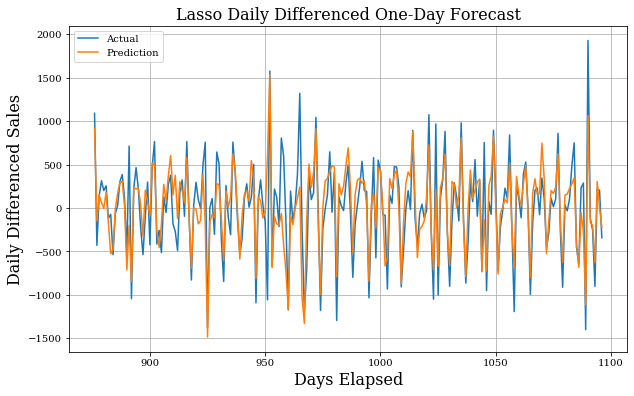

96715.85682149808
223.04327909198142


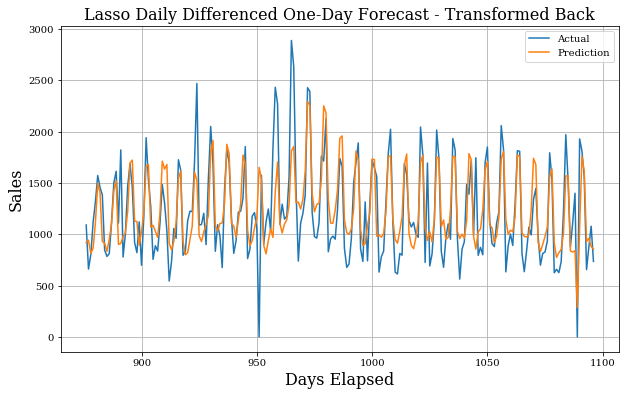

96715.8568214981
223.04327909198142


In [110]:
lasso = LassoCV()

feat_reduction = SelectKBest(f_regression, k=49) 
X_new = feat_reduction.fit_transform(X,y)

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=221, random_state=42, shuffle=False)

lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)

print(keras.metrics.mean_squared_error(y_test, y_pred).numpy())
print(keras.metrics.mean_absolute_error(y_test, y_pred).numpy())

plt.figure(figsize=(10, 6))
plt.title('Difference Forecast')
plot_series(diff_time[-221:], y_test,label='Actual')
plot_series(diff_time[-221:], y_pred,label='Prediction')
plt.title("Lasso Daily Differenced One-Day Forecast",fontsize=16)
plt.xlabel("Days Elapsed", fontsize=16)
plt.ylabel("Daily Differenced Sales", fontsize=16)
plt.legend(loc="best")
plt.savefig(fname='Charts/LassoPredictonDailyDiff.png',dpi=150)
plt.show()
print(keras.metrics.mean_squared_error(y_test, y_pred).numpy())
print(keras.metrics.mean_absolute_error(y_test, y_pred).numpy())

#Adding predicted difference to get final results.
added_back = price_series[-222:-1] + y_pred
y_true = price_series[-221:] 
plt.figure(figsize=(10, 6))
plt.title('Transformed To Actual')
plot_series(diff_time[-221:], y_true,label='Actual')
plot_series(diff_time[-221:], added_back,label='Prediction')
plt.title("Lasso Daily Differenced One-Day Forecast - Transformed Back",fontsize=16)
plt.xlabel("Days Elapsed", fontsize=16)
plt.ylabel("Sales", fontsize=16)
plt.legend(loc="upper right")
plt.savefig(fname='Charts/LassoPredictonDailyDiffAB.png',dpi=150)
plt.show()
print(keras.metrics.mean_squared_error(y_true, added_back).numpy())
print(keras.metrics.mean_absolute_error(y_true, added_back).numpy())

<b> Ridge Regression

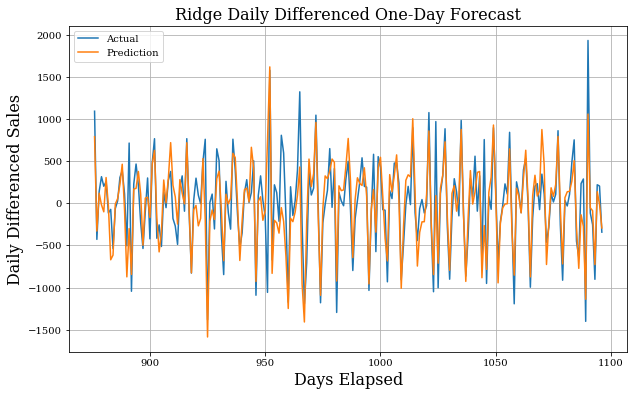

92815.37139727004
216.16277194829814


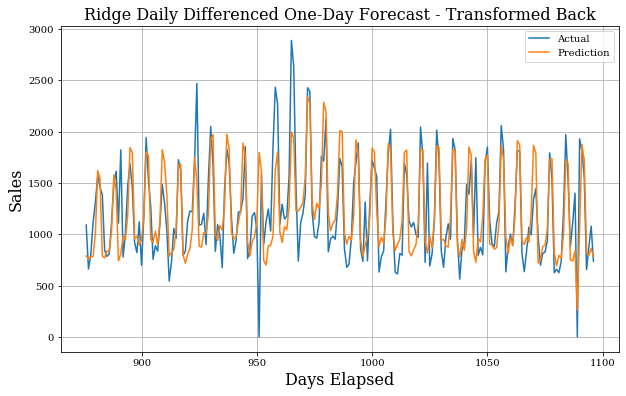

92815.37139727006
216.16277194829823


In [111]:
ridge = Ridge(alpha=1.0)

feat_reduction = SelectKBest(f_regression, k=65) 
X_new = feat_reduction.fit_transform(X,y)

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=221, random_state=42, shuffle=False)

ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)

plt.figure(figsize=(10, 6))
plt.title('Difference Forecast')
plot_series(diff_time[-221:], y_test,label='Actual')
plot_series(diff_time[-221:], y_pred,label='Prediction')
plt.title("Ridge Daily Differenced One-Day Forecast",fontsize=16)
plt.xlabel("Days Elapsed", fontsize=16)
plt.ylabel("Daily Differenced Sales", fontsize=16)
plt.legend(loc="best")
plt.savefig(fname='Charts/RidgePredictonDailyDiff.png',dpi=150)
plt.show()
print(keras.metrics.mean_squared_error(y_test, y_pred).numpy())
print(keras.metrics.mean_absolute_error(y_test, y_pred).numpy())

#Adding predicted difference to get final results.
added_back = price_series[-222:-1] + y_pred
y_true = price_series[-221:] 
plt.figure(figsize=(10, 6))
plt.title('Transformed To Actual')
plot_series(diff_time[-221:], y_true,label='Actual')
plot_series(diff_time[-221:], added_back,label='Prediction')
plt.title("Ridge Daily Differenced One-Day Forecast - Transformed Back",fontsize=16)
plt.xlabel("Days Elapsed", fontsize=16)
plt.ylabel("Sales", fontsize=16)
plt.legend(loc="upper right")
plt.savefig(fname='Charts/RidgePredictonDailyDiffAB.png',dpi=150)
plt.show()
print(keras.metrics.mean_squared_error(y_true, added_back).numpy())
print(keras.metrics.mean_absolute_error(y_true, added_back).numpy())

<b> Kernal Ridge Regression

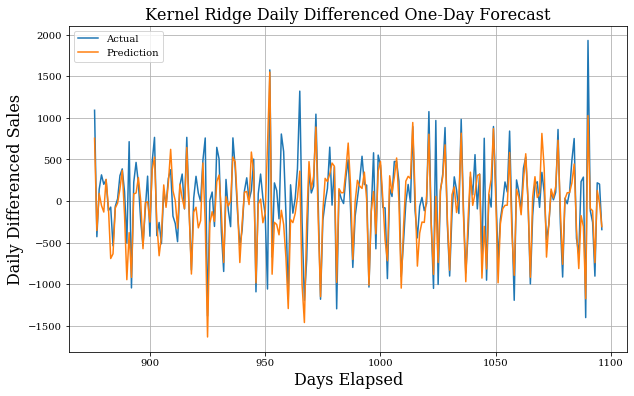

96314.88317194191
214.23015436624868


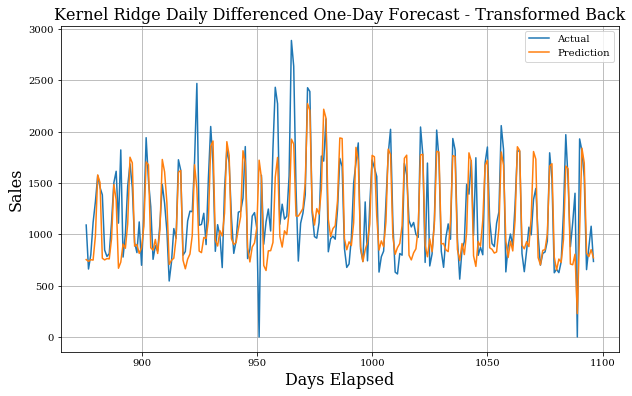

96314.88317194194
214.23015436624868


In [112]:
kridge = KernelRidge()

feat_reduction = SelectKBest(f_regression, k=72) 
X_new = feat_reduction.fit_transform(X,y)

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=221, random_state=42, shuffle=False)

kridge.fit(X_train, y_train)
y_pred = kridge.predict(X_test)

plt.figure(figsize=(10, 6))
plt.title('Difference Forecast')
plot_series(diff_time[-221:], y_test,label='Actual')
plot_series(diff_time[-221:], y_pred,label='Prediction')
plt.title("Kernel Ridge Daily Differenced One-Day Forecast",fontsize=16)
plt.xlabel("Days Elapsed", fontsize=16)
plt.ylabel("Daily Differenced Sales", fontsize=16)
plt.legend(loc="best")
plt.savefig(fname='Charts/KridgePredictonDailyDiff.png',dpi=150)
plt.show()
print(keras.metrics.mean_squared_error(y_test, y_pred).numpy())
print(keras.metrics.mean_absolute_error(y_test, y_pred).numpy())

#Adding predicted difference to get final results.
added_back = price_series[-222:-1] + y_pred
y_true = price_series[-221:] 
plt.figure(figsize=(10, 6))
plt.title('Transformed To Actual')
plot_series(diff_time[-221:], y_true,label='Actual')
plot_series(diff_time[-221:], added_back,label='Prediction')
plt.title("Kernel Ridge Daily Differenced One-Day Forecast - Transformed Back",fontsize=16)
plt.xlabel("Days Elapsed", fontsize=16)
plt.ylabel("Sales", fontsize=16)
plt.legend(loc="upper right")
plt.savefig(fname='Charts/KridgePredictonDailyDiffAB.png',dpi=150)
plt.show()
print(keras.metrics.mean_squared_error(y_true, added_back).numpy())
print(keras.metrics.mean_absolute_error(y_true, added_back).numpy())

<b> Bayesian Ridge Regression

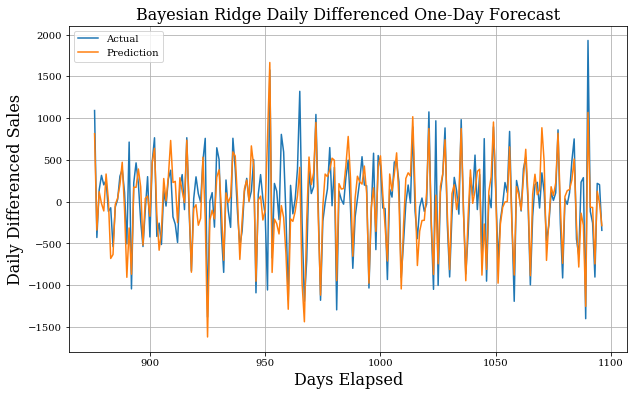

94613.8790726338
217.8957233955731


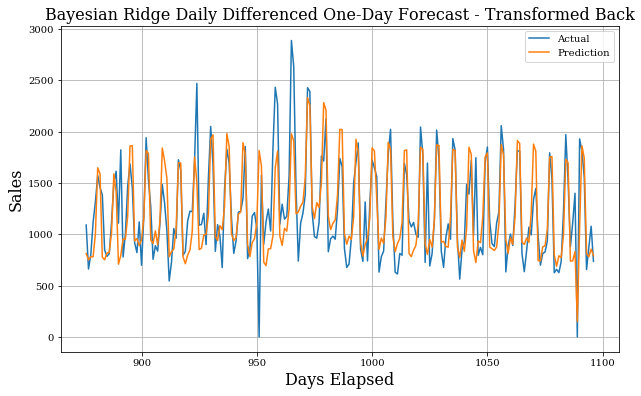

94613.8790726338
217.8957233955731


In [113]:
bridge = BayesianRidge()

feat_reduction = SelectKBest(f_regression, k=62) 
X_new = feat_reduction.fit_transform(X,y)

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=221, random_state=42, shuffle=False)

bridge.fit(X_train, y_train)
y_pred = bridge.predict(X_test)

plt.figure(figsize=(10, 6))
plt.title('Difference Forecast')
plot_series(diff_time[-221:], y_test,label='Actual')
plot_series(diff_time[-221:], y_pred,label='Prediction')
plt.title("Bayesian Ridge Daily Differenced One-Day Forecast",fontsize=16)
plt.xlabel("Days Elapsed", fontsize=16)
plt.ylabel("Daily Differenced Sales", fontsize=16)
plt.legend(loc="best")
plt.savefig(fname='Charts/BridgePredictonDailyDiff.png',dpi=150)
plt.show()
print(keras.metrics.mean_squared_error(y_test, y_pred).numpy())
print(keras.metrics.mean_absolute_error(y_test, y_pred).numpy())

#Adding predicted difference to get final results.
added_back = price_series[-222:-1] + y_pred
y_true = price_series[-221:] 
plt.figure(figsize=(10, 6))
plt.title('Transformed To Actual')
plot_series(diff_time[-221:], y_true,label='Actual')
plot_series(diff_time[-221:], added_back,label='Prediction')
plt.title("Bayesian Ridge Daily Differenced One-Day Forecast - Transformed Back",fontsize=16)
plt.xlabel("Days Elapsed", fontsize=16)
plt.ylabel("Sales", fontsize=16)
plt.legend(loc="upper right")
plt.savefig(fname='Charts/BridgePredictonDailyDiffAB.png',dpi=150)
plt.show()
print(keras.metrics.mean_squared_error(y_true, added_back).numpy())
print(keras.metrics.mean_absolute_error(y_true, added_back).numpy())

<b> Extra Trees Regression

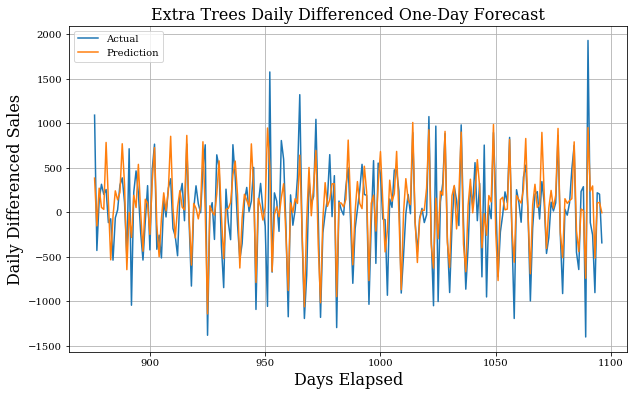

116800.27408322605
253.2142650226244


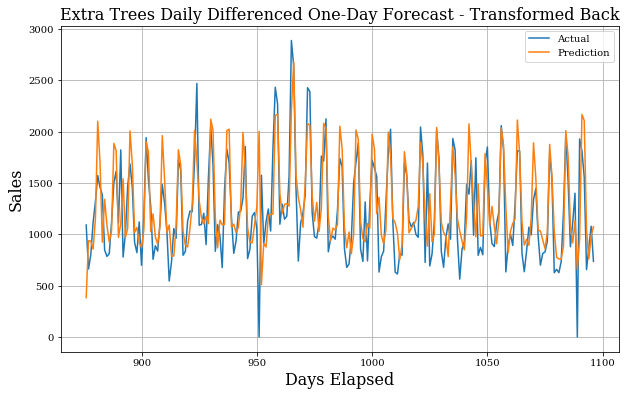

116800.27408322605
253.2142650226244


In [114]:
et  = ExtraTreesRegressor(n_estimators=1000, random_state=0,n_jobs=5)

feat_reduction = SelectKBest(f_regression, k=36) 
X_new = feat_reduction.fit_transform(X,y)

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=221, random_state=42, shuffle=False)

et.fit(X_train, y_train)
y_pred = et.predict(X_test)

plt.figure(figsize=(10, 6))
plt.title('Difference Forecast')
plot_series(diff_time[-221:], y_test,label='Actual')
plot_series(diff_time[-221:], y_pred,label='Prediction')
plt.title("Extra Trees Daily Differenced One-Day Forecast",fontsize=16)
plt.xlabel("Days Elapsed", fontsize=16)
plt.ylabel("Daily Differenced Sales", fontsize=16)
plt.legend(loc="best")
plt.savefig(fname='Charts/ETPredictonDailyDiff.png',dpi=150)
plt.show()
print(keras.metrics.mean_squared_error(y_test, y_pred).numpy())
print(keras.metrics.mean_absolute_error(y_test, y_pred).numpy())

#Adding predicted difference to get final results.
added_back = price_series[-222:-1] + y_pred
y_true = price_series[-221:] 
plt.figure(figsize=(10, 6))
plt.title('Transformed To Actual')
plot_series(diff_time[-221:], y_true,label='Actual')
plot_series(diff_time[-221:], added_back,label='Prediction')
plt.title("Extra Trees Daily Differenced One-Day Forecast - Transformed Back",fontsize=16)
plt.xlabel("Days Elapsed", fontsize=16)
plt.ylabel("Sales", fontsize=16)
plt.legend(loc="upper right")
plt.savefig(fname='Charts/ETPredictonDailyDiffAB.png',dpi=150)
plt.show()
print(keras.metrics.mean_squared_error(y_true, added_back).numpy())
print(keras.metrics.mean_absolute_error(y_true, added_back).numpy())

<b> Stacking Regression

Voting party includes: Ridge Regressor, Nearest Neighbor Regressor, Linear Regressor, Extra Trees Regressor and MLP Regressor

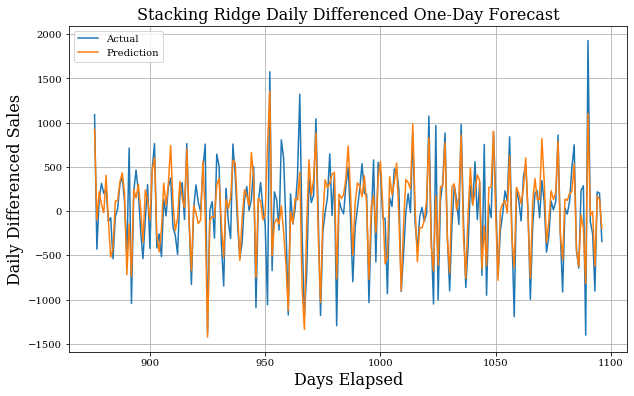

92686.83777480522
223.41149272392596


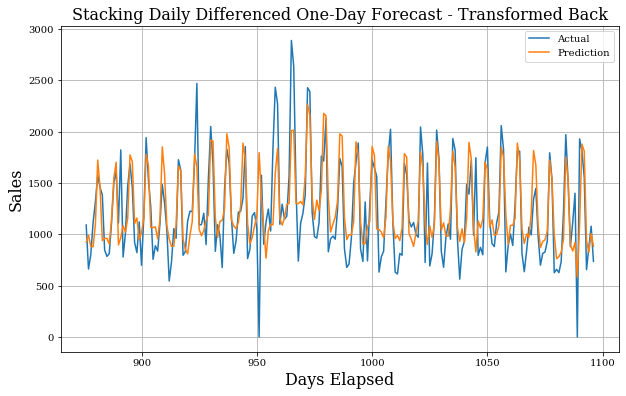

92686.83777480522
223.41149272392596


In [115]:
stack_neigh = KNeighborsRegressor(n_neighbors=7)
LR = LinearRegression()
rid = Ridge(alpha=1.0)
et = ExtraTreesRegressor(n_estimators=1000, random_state=0)

stack = StackingCVRegressor(regressors=(LR, rid, et, stack_neigh),
                            meta_regressor=rid, 
                            random_state=42,
                            use_features_in_secondary=True)

feat_reduction = SelectKBest(f_regression, k=41) 
X_new = feat_reduction.fit_transform(X,y)

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=221, random_state=42, shuffle=False)

stack.fit(X_train, y_train)
y_pred = stack.predict(X_test)

plt.figure(figsize=(10, 6))
plt.title('Difference Forecast')
plot_series(diff_time[-221:], y_test,label='Actual')
plot_series(diff_time[-221:], y_pred,label='Prediction')
plt.title("Stacking Ridge Daily Differenced One-Day Forecast",fontsize=16)
plt.xlabel("Days Elapsed", fontsize=16)
plt.ylabel("Daily Differenced Sales", fontsize=16)
plt.legend(loc="best")
plt.savefig(fname='Charts/StackingPredictonDailyDiff.png',dpi=150)
plt.show()
print(keras.metrics.mean_squared_error(y_test, y_pred).numpy())
print(keras.metrics.mean_absolute_error(y_test, y_pred).numpy())

#Adding predicted difference to get final results.
added_back = price_series[-222:-1] + y_pred
y_true = price_series[-221:] 
plt.figure(figsize=(10, 6))
plt.title('Transformed To Actual')
plot_series(diff_time[-221:], y_true,label='Actual')
plot_series(diff_time[-221:], added_back,label='Prediction')
plt.title("Stacking Daily Differenced One-Day Forecast - Transformed Back",fontsize=16)
plt.xlabel("Days Elapsed", fontsize=16)
plt.ylabel("Sales", fontsize=16)
plt.legend(loc="upper right")
plt.savefig(fname='Charts/StackingPredictonDailyDiffAB.png',dpi=150)
plt.show()
print(keras.metrics.mean_squared_error(y_true, added_back).numpy())
print(keras.metrics.mean_absolute_error(y_true, added_back).numpy())

<b> XGB Regression

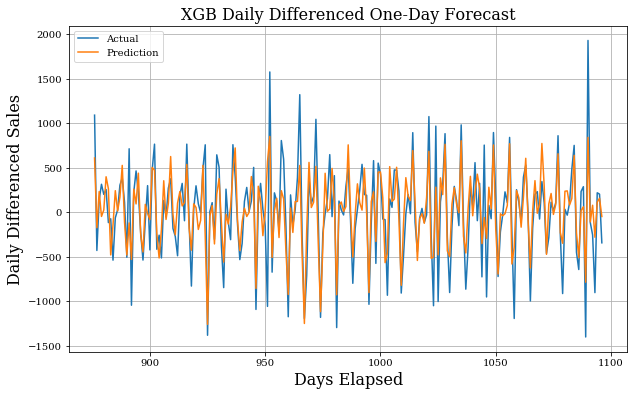

106565.81
245.65302


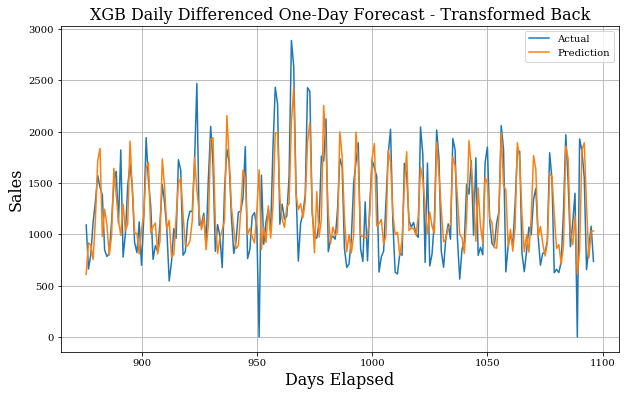

106565.81251569305
245.65300726113816
106565.81
245.65302


In [116]:
XGB = XGBRegressor(learning_rate =0.05,
 n_estimators=2000,
 max_depth=5,
 min_child_weight=1,
 gamma=0.1,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'reg:squarederror',
 nthread=5,
 scale_pos_weight=1,
 seed=21,
 eval_metric = ['mae'])

feat_reduction = SelectKBest(f_regression, k=67) 
X_new = feat_reduction.fit_transform(X,y)

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=221, random_state=42, shuffle=False)

XGB.fit(X_train, y_train)
y_pred = XGB.predict(X_test)

plt.figure(figsize=(10, 6))
plt.title('Difference Forecast')
plot_series(diff_time[-221:], y_test,label='Actual')
plot_series(diff_time[-221:], y_pred,label='Prediction')
plt.title("XGB Daily Differenced One-Day Forecast",fontsize=16)
plt.xlabel("Days Elapsed", fontsize=16)
plt.ylabel("Daily Differenced Sales", fontsize=16)
plt.legend(loc="best")
plt.savefig(fname='Charts/XGBPredictonDailyDiff.png',dpi=150)
plt.show()
print(keras.metrics.mean_squared_error(y_test, y_pred).numpy())
print(keras.metrics.mean_absolute_error(y_test, y_pred).numpy())

#Adding predicted difference to get final results.
added_back = price_series[-222:-1] + y_pred
y_true = price_series[-221:] 
plt.figure(figsize=(10, 6))
plt.title('Transformed To Actual')
plot_series(diff_time[-221:], y_true,label='Actual')
plot_series(diff_time[-221:], added_back,label='Prediction')
plt.title("XGB Daily Differenced One-Day Forecast - Transformed Back",fontsize=16)
plt.xlabel("Days Elapsed", fontsize=16)
plt.ylabel("Sales", fontsize=16)
plt.legend(loc="upper right")
plt.savefig(fname='Charts/XGBPredictonDailyDiffAB.png',dpi=150)
plt.show()
print(keras.metrics.mean_squared_error(y_true, added_back).numpy())
print(keras.metrics.mean_absolute_error(y_true, added_back).numpy())

print(keras.metrics.mean_squared_error(y_test, y_pred).numpy())
print(keras.metrics.mean_absolute_error(y_test, y_pred).numpy())

<b> Weekly Difference

Scaling Weekly Differenced dataset. Prediction target is the difference of the last week day.

In [117]:
X=weekly_difference_data[:, 0:numcols-1]
y=weekly_difference_data[:, numcols-1]

scaler = preprocessing.RobustScaler()
X = scaler.fit_transform(X,y)

<b> Linear Regression

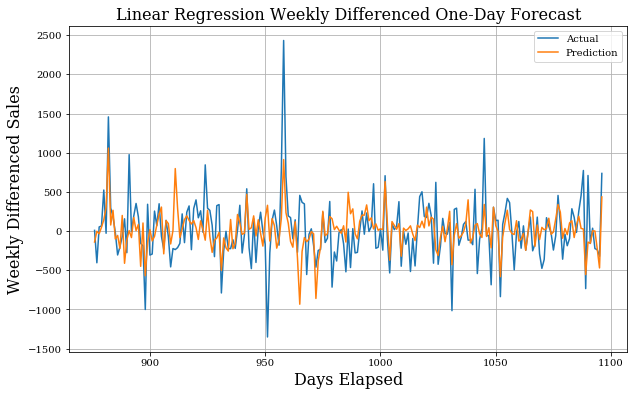

124197.67362677804
245.5737553388984


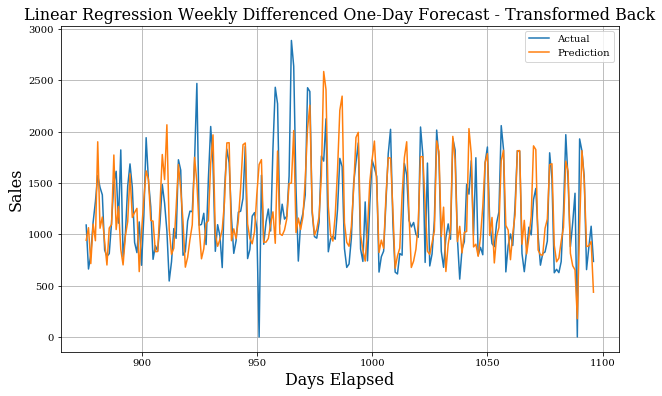

124197.67362677804
245.5737553388984


In [119]:
lr = LinearRegression()

feat_reduction = SelectKBest(f_regression, k=14) 
X_new = feat_reduction.fit_transform(X,y)

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=221, random_state=42, shuffle=False)

lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

plt.figure(figsize=(10, 6))
plot_series(diff_time[-221:], y_test,label='Actual')
plot_series(diff_time[-221:], y_pred,label='Prediction')
plt.title("Linear Regression Weekly Differenced One-Day Forecast",fontsize=16)
plt.xlabel("Days Elapsed", fontsize=16)
plt.ylabel("Weekly Differenced Sales", fontsize=16)
plt.legend(loc="best")
plt.savefig(fname='Charts/LinearRegPredictonWeeklyDiff.png',dpi=150)
plt.show()
print(keras.metrics.mean_squared_error(y_test, y_pred).numpy())
print(keras.metrics.mean_absolute_error(y_test, y_pred).numpy())

#Adding predicted difference to get final results.
added_back = price_series[-228:-7] + y_pred
y_true = price_series[-221:] 
plt.figure(figsize=(10, 6))
plot_series(diff_time[-221:], y_true,label='Actual')
plot_series(diff_time[-221:], added_back,label='Prediction')
plt.title("Linear Regression Weekly Differenced One-Day Forecast - Transformed Back",fontsize=16)
plt.xlabel("Days Elapsed", fontsize=16)
plt.ylabel("Sales", fontsize=16)
plt.legend(loc="upper right")
plt.savefig(fname='Charts/LinearRegPredictonWeeklyDiffAB.png',dpi=150)
plt.show()
print(keras.metrics.mean_squared_error(y_true, added_back).numpy())
print(keras.metrics.mean_absolute_error(y_true, added_back).numpy())

<b> Bayesian Ridge Regression

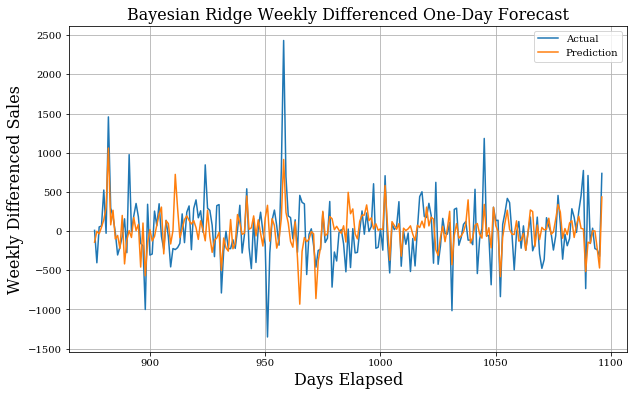

123774.98989456594
245.87052904585815


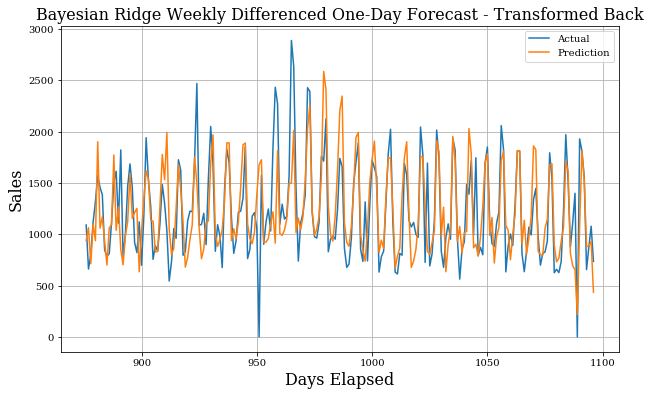

123774.98989456595
245.87052904585812


In [120]:
bridge = BayesianRidge()

feat_reduction = SelectKBest(f_regression, k=14) 
X_new = feat_reduction.fit_transform(X,y)

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=221, random_state=42, shuffle=False)

bridge.fit(X_train, y_train)
y_pred = bridge.predict(X_test)

plt.figure(figsize=(10, 6))
plot_series(diff_time[-221:], y_test,label='Actual')
plot_series(diff_time[-221:], y_pred,label='Prediction')
plt.title("Bayesian Ridge Weekly Differenced One-Day Forecast",fontsize=16)
plt.xlabel("Days Elapsed", fontsize=16)
plt.ylabel("Weekly Differenced Sales", fontsize=16)
plt.legend(loc="best")
plt.savefig(fname='Charts/BridgePredictonWeeklyDiff.png',dpi=150)
plt.show()
print(keras.metrics.mean_squared_error(y_test, y_pred).numpy())
print(keras.metrics.mean_absolute_error(y_test, y_pred).numpy())

#Adding predicted difference to get final results.
added_back = price_series[-228:-7] + y_pred
y_true = price_series[-221:] 
plt.figure(figsize=(10, 6))
plot_series(diff_time[-221:], y_true,label='Actual')
plot_series(diff_time[-221:], added_back,label='Prediction')
plt.title("Bayesian Ridge Weekly Differenced One-Day Forecast - Transformed Back",fontsize=16)
plt.xlabel("Days Elapsed", fontsize=16)
plt.ylabel("Sales", fontsize=16)
plt.legend(loc="upper right")
plt.savefig(fname='Charts/BridgePredictonWeeklyDiffAB.png',dpi=150)
plt.show()
print(keras.metrics.mean_squared_error(y_true, added_back).numpy())
print(keras.metrics.mean_absolute_error(y_true, added_back).numpy())

<b> Extra Trees Regressor

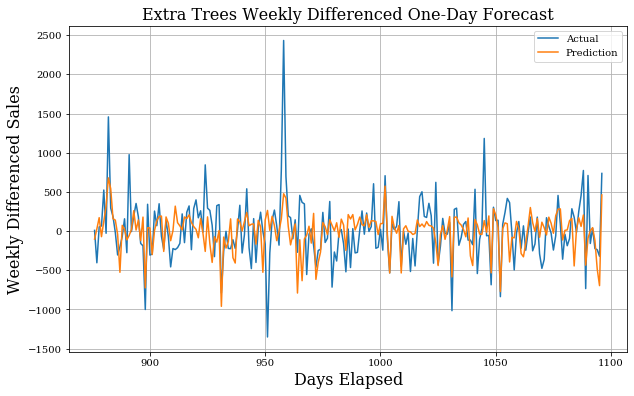

127860.67109916743
256.1814769230769


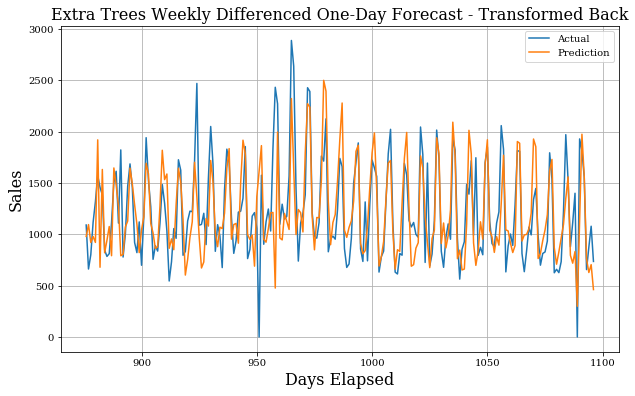

127860.67109916743
256.1814769230769


In [121]:
et = ExtraTreesRegressor()

feat_reduction = SelectKBest(f_regression, k=71) 
X_new = feat_reduction.fit_transform(X,y)

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=221, random_state=42, shuffle=False)

et.fit(X_train, y_train)
y_pred = et.predict(X_test)

plt.figure(figsize=(10, 6))
plot_series(diff_time[-221:], y_test,label='Actual')
plot_series(diff_time[-221:], y_pred,label='Prediction')
plt.title("Extra Trees Weekly Differenced One-Day Forecast",fontsize=16)
plt.xlabel("Days Elapsed", fontsize=16)
plt.ylabel("Weekly Differenced Sales", fontsize=16)
plt.legend(loc="best")
plt.savefig(fname='Charts/ETPredictonWeeklyDiff.png',dpi=150)
plt.show()
print(keras.metrics.mean_squared_error(y_test, y_pred).numpy())
print(keras.metrics.mean_absolute_error(y_test, y_pred).numpy())

#Adding predicted difference to get final results.
added_back = price_series[-228:-7] + y_pred
y_true = price_series[-221:] 
plt.figure(figsize=(10, 6))
plot_series(diff_time[-221:], y_true,label='Actual')
plot_series(diff_time[-221:], added_back,label='Prediction')
plt.title("Extra Trees Weekly Differenced One-Day Forecast - Transformed Back",fontsize=16)
plt.xlabel("Days Elapsed", fontsize=16)
plt.ylabel("Sales", fontsize=16)
plt.legend(loc="upper right")
plt.savefig(fname='Charts/ETPredictonWeeklyDiffAB.png',dpi=150)
plt.show()
print(keras.metrics.mean_squared_error(y_true, added_back).numpy())
print(keras.metrics.mean_absolute_error(y_true, added_back).numpy())

<b> Lasso CV Regressor

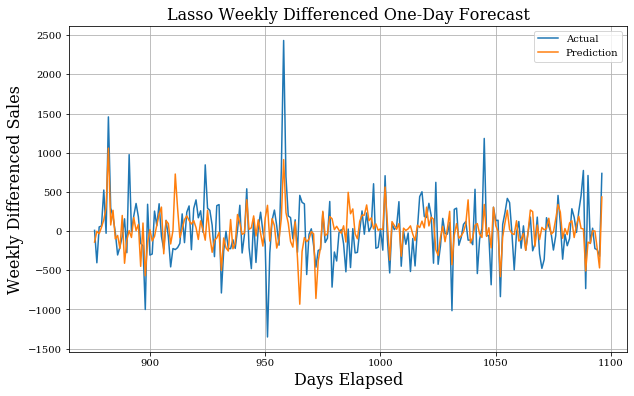

123741.94732512992
246.007493923559


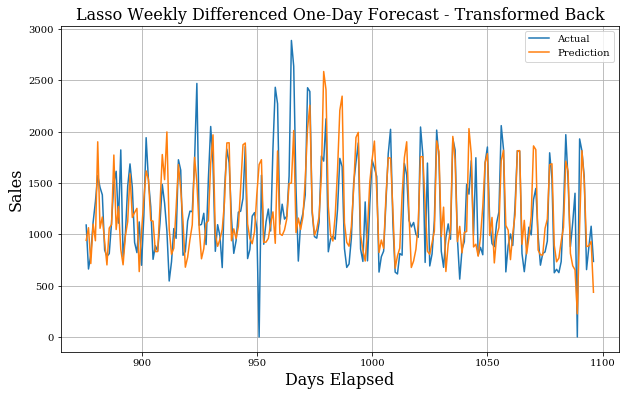

123741.9473251299
246.007493923559


In [122]:
lasso = LassoCV()

feat_reduction = SelectKBest(f_regression, k=14) 
X_new = feat_reduction.fit_transform(X,y)

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=221, random_state=42, shuffle=False)

lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)

plt.figure(figsize=(10, 6))
plot_series(diff_time[-221:], y_test,label='Actual')
plot_series(diff_time[-221:], y_pred,label='Prediction')
plt.title("Lasso Weekly Differenced One-Day Forecast",fontsize=16)
plt.xlabel("Days Elapsed", fontsize=16)
plt.ylabel("Weekly Differenced Sales", fontsize=16)
plt.legend(loc="best")
plt.savefig(fname='Charts/LassoPredictonWeeklyDiff.png',dpi=150)
plt.show()
print(keras.metrics.mean_squared_error(y_test, y_pred).numpy())
print(keras.metrics.mean_absolute_error(y_test, y_pred).numpy())

#Adding predicted difference to get final results.
added_back = price_series[-228:-7] + y_pred
y_true = price_series[-221:] 
plt.figure(figsize=(10, 6))
plot_series(diff_time[-221:], y_true,label='Actual')
plot_series(diff_time[-221:], added_back,label='Prediction')
plt.title("Lasso Weekly Differenced One-Day Forecast - Transformed Back",fontsize=16)
plt.xlabel("Days Elapsed", fontsize=16)
plt.ylabel("Sales", fontsize=16)
plt.legend(loc="upper right")
plt.savefig(fname='Charts/LassoPredictonWeeklyDiffAB.png',dpi=150)
plt.show()
print(keras.metrics.mean_squared_error(y_true, added_back).numpy())
print(keras.metrics.mean_absolute_error(y_true, added_back).numpy())

<b> Kernal Ridge Regressor

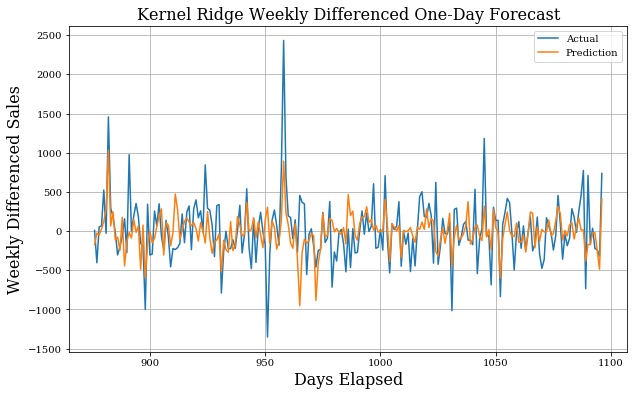

122866.29155869392
245.6859586088643


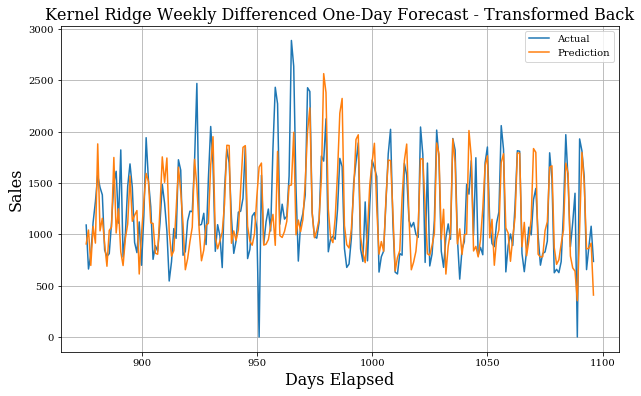

122866.29155869392
245.68595860886433


In [123]:
kridge = KernelRidge()

feat_reduction = SelectKBest(f_regression, k=14) 
X_new = feat_reduction.fit_transform(X,y)

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=221, random_state=42, shuffle=False)

kridge.fit(X_train, y_train)
y_pred = kridge.predict(X_test)

plt.figure(figsize=(10, 6))
plot_series(diff_time[-221:], y_test,label='Actual')
plot_series(diff_time[-221:], y_pred,label='Prediction')
plt.title("Kernel Ridge Weekly Differenced One-Day Forecast",fontsize=16)
plt.xlabel("Days Elapsed", fontsize=16)
plt.ylabel("Weekly Differenced Sales", fontsize=16)
plt.legend(loc="best")
plt.savefig(fname='Charts/KridgePredictonWeeklyDiff.png',dpi=150)
plt.show()
print(keras.metrics.mean_squared_error(y_test, y_pred).numpy())
print(keras.metrics.mean_absolute_error(y_test, y_pred).numpy())

#Adding predicted difference to get final results.
added_back = price_series[-228:-7] + y_pred
y_true = price_series[-221:] 
plt.figure(figsize=(10, 6))
plot_series(diff_time[-221:], y_true,label='Actual')
plot_series(diff_time[-221:], added_back,label='Prediction')
plt.title("Kernel Ridge Weekly Differenced One-Day Forecast - Transformed Back",fontsize=16)
plt.xlabel("Days Elapsed", fontsize=16)
plt.ylabel("Sales", fontsize=16)
plt.legend(loc="upper right")
plt.savefig(fname='Charts/KridgePredictonWeeklyDiffAB.png',dpi=150)
plt.show()
print(keras.metrics.mean_squared_error(y_true, added_back).numpy())
print(keras.metrics.mean_absolute_error(y_true, added_back).numpy())

<b> Ridge Regressor

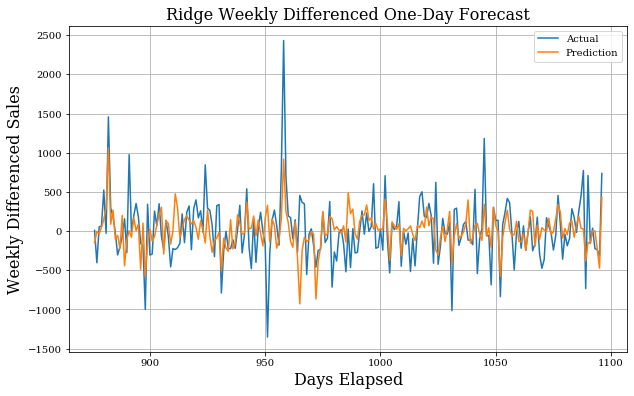

123063.74095228137
246.90105133387578


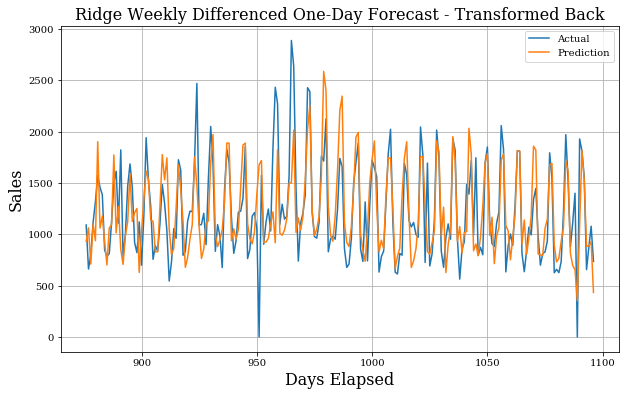

123063.74095228137
246.90105133387578


In [124]:
ridge = Ridge()

feat_reduction = SelectKBest(f_regression, k=14) 
X_new = feat_reduction.fit_transform(X,y)

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=221, random_state=42, shuffle=False)

ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)

plt.figure(figsize=(10, 6))
plot_series(diff_time[-221:], y_test,label='Actual')
plot_series(diff_time[-221:], y_pred,label='Prediction')
plt.title("Ridge Weekly Differenced One-Day Forecast",fontsize=16)
plt.xlabel("Days Elapsed", fontsize=16)
plt.ylabel("Weekly Differenced Sales", fontsize=16)
plt.legend(loc="best")
plt.savefig(fname='Charts/RidgePredictonWeeklyDiff.png',dpi=150)
plt.show()
print(keras.metrics.mean_squared_error(y_test, y_pred).numpy())
print(keras.metrics.mean_absolute_error(y_test, y_pred).numpy())

#Adding predicted difference to get final results.
added_back = price_series[-228:-7] + y_pred
y_true = price_series[-221:] 
plt.figure(figsize=(10, 6))
plot_series(diff_time[-221:], y_true,label='Actual')
plot_series(diff_time[-221:], added_back,label='Prediction')
plt.title("Ridge Weekly Differenced One-Day Forecast - Transformed Back",fontsize=16)
plt.xlabel("Days Elapsed", fontsize=16)
plt.ylabel("Sales", fontsize=16)
plt.legend(loc="upper right")
plt.savefig(fname='Charts/RidgePredictonWeeklyDiffAB.png',dpi=150)
plt.show()
print(keras.metrics.mean_squared_error(y_true, added_back).numpy())
print(keras.metrics.mean_absolute_error(y_true, added_back).numpy())

<b> Voting Regression

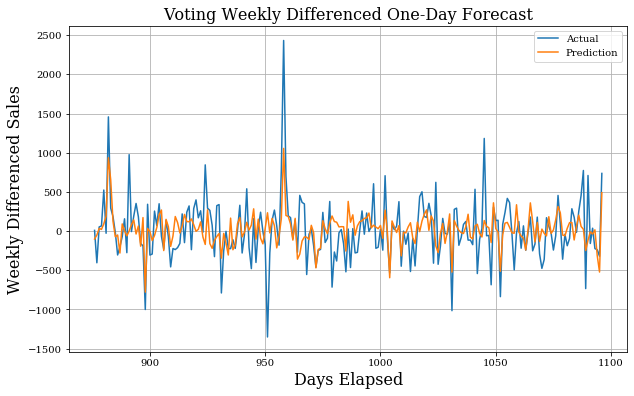

110704.68023750727
238.88859696428827


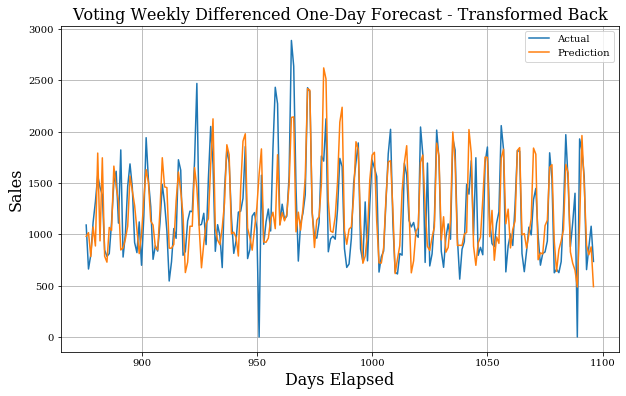

110704.68023750727
238.8885969642883


In [125]:
reg1 = GradientBoostingRegressor(random_state=1, n_estimators=10)
reg2 = RandomForestRegressor(random_state=1, n_estimators=10)
reg3 = LinearRegression()
reg4 = DecisionTreeRegressor(random_state=0,criterion="mae")
reg5 = SGDRegressor(max_iter=1000, tol=1e-3)

vr = VotingRegressor(estimators=[('gb', reg1), ('rf', reg2), ('lr', reg3), ('dt',reg4), ('sgd',reg5)])

feat_reduction = SelectKBest(f_regression, k=12) 
X_new = feat_reduction.fit_transform(X,y)

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=221, random_state=42, shuffle=False)

vr.fit(X_train, y_train)
y_pred = vr.predict(X_test)

plt.figure(figsize=(10, 6))
plot_series(diff_time[-221:], y_test,label='Actual')
plot_series(diff_time[-221:], y_pred,label='Prediction')
plt.title("Voting Weekly Differenced One-Day Forecast",fontsize=16)
plt.xlabel("Days Elapsed", fontsize=16)
plt.ylabel("Weekly Differenced Sales", fontsize=16)
plt.legend(loc="best")
plt.savefig(fname='Charts/VRPredictonWeeklyDiff.png',dpi=150)
plt.show()
print(keras.metrics.mean_squared_error(y_test, y_pred).numpy())
print(keras.metrics.mean_absolute_error(y_test, y_pred).numpy())

#Adding predicted difference to get final results.
added_back = price_series[-228:-7] + y_pred
y_true = price_series[-221:] 
plt.figure(figsize=(10, 6))
plot_series(diff_time[-221:], y_true,label='Actual')
plot_series(diff_time[-221:], added_back,label='Prediction')
plt.title("Voting Weekly Differenced One-Day Forecast - Transformed Back",fontsize=16)
plt.xlabel("Days Elapsed", fontsize=16)
plt.ylabel("Sales", fontsize=16)
plt.legend(loc="upper right")
plt.savefig(fname='Charts/VRPredictonWeeklyDiffAB.png',dpi=150)
plt.show()
print(keras.metrics.mean_squared_error(y_true, added_back).numpy())
print(keras.metrics.mean_absolute_error(y_true, added_back).numpy())

<b> Stacking Regression

Voting party includes: Ridge Regressor, Nearest Neighbor Regressor, Linear Regressor, Extra Trees Regressor and MLP Regressor

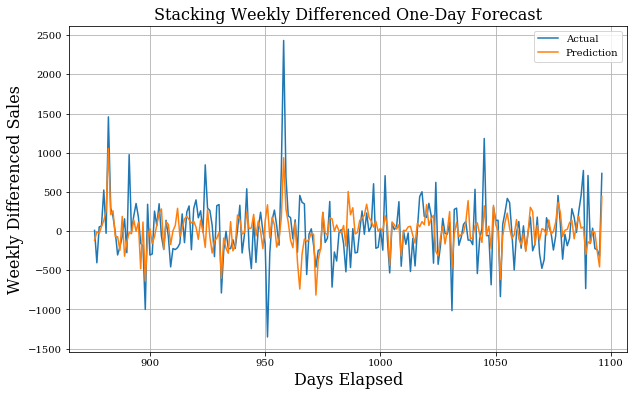

118613.2606163204
242.78825889126045


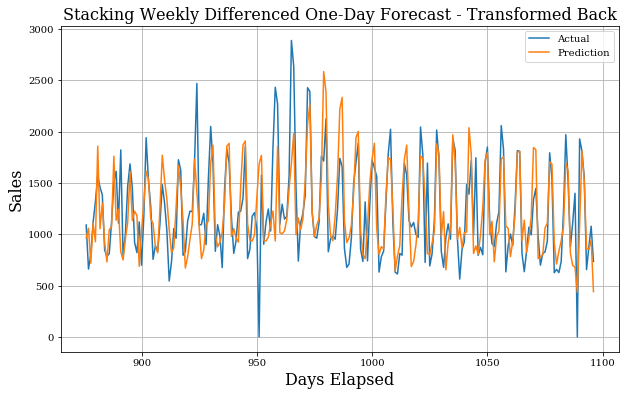

118613.26061632043
242.78825889126048


In [126]:
stack_neigh = KNeighborsRegressor(n_neighbors=7)
LR = LinearRegression()
rid = Ridge(alpha=1.0)
et = ExtraTreesRegressor(n_estimators=1000, random_state=0)

stack = StackingCVRegressor(regressors=(LR, rid, et, stack_neigh),
                            meta_regressor=rid, 
                            random_state=42,
                            use_features_in_secondary=True)

feat_reduction = SelectKBest(f_regression, k=17) 
X_new = feat_reduction.fit_transform(X,y)

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=221, random_state=42, shuffle=False)

stack.fit(X_train, y_train)
y_pred = stack.predict(X_test)

plt.figure(figsize=(10, 6))
plot_series(diff_time[-221:], y_test,label='Actual')
plot_series(diff_time[-221:], y_pred,label='Prediction')
plt.title("Stacking Weekly Differenced One-Day Forecast",fontsize=16)
plt.xlabel("Days Elapsed", fontsize=16)
plt.ylabel("Weekly Differenced Sales", fontsize=16)
plt.legend(loc="best")
plt.savefig(fname='Charts/StackingPredictonWeeklyDiff.png',dpi=150)
plt.show()
print(keras.metrics.mean_squared_error(y_test, y_pred).numpy())
print(keras.metrics.mean_absolute_error(y_test, y_pred).numpy())

#Adding predicted difference to get final results.
added_back = price_series[-228:-7] + y_pred
y_true = price_series[-221:] 
plt.figure(figsize=(10, 6))
plot_series(diff_time[-221:], y_true,label='Actual')
plot_series(diff_time[-221:], added_back,label='Prediction')
plt.title("Stacking Weekly Differenced One-Day Forecast - Transformed Back",fontsize=16)
plt.xlabel("Days Elapsed", fontsize=16)
plt.ylabel("Sales", fontsize=16)
plt.legend(loc="upper right")
plt.savefig(fname='Charts/StackingPredictonWeeklyDiffAB.png',dpi=150)
plt.show()
print(keras.metrics.mean_squared_error(y_true, added_back).numpy())
print(keras.metrics.mean_absolute_error(y_true, added_back).numpy())

### Keras Models

We create the dataset in exactly the same way for our Keras models. We will skip the removal of features in this stage.

In [127]:
# fix random seed for reproducibility
np.random.seed(8)
# load the dataset
dataframe = pd.read_csv('Data/RestaurantDataVets_All_2to5.csv')
data = dataframe.drop(columns=['Index','DMY','MissingPrevDays'])

lookback=14
dataframe_removed_lookback = data.drop([x for x in range(lookback)])

for i in range(lookback):
    dataframe_removed_lookback[i] = 1.0
    
df = dataframe_removed_lookback[['Year', 'Day', 'January','February',
                         'March','April','May','June','July',
                         'August', 'September', 'October', 'November',
                         'December','Sunday', 'Monday', 'Tuesday',
                         'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Holiday', 'Carnival', 
                         'LentFasting','Ramadan','ChristmasSeason',
                         0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                         'DailyAvg','WeeklyAvg','MinSales','MaxSales','DailyBusyness',
                         'WeeklyBusyness','2to5']]
df = df.reset_index(drop=True)

#Objects need to be converted to float due to missing values at load time.
df["DailyAvg"] = df.DailyAvg.astype(float)
df["WeeklyAvg"] = df.WeeklyAvg.astype(float)
df["MinSales"] = df.MinSales.astype(float)
df["MaxSales"] = df.MaxSales.astype(float)
df["DailyBusyness"] = df.DailyBusyness.astype(float)
df["WeeklyBusyness"] = df.WeeklyBusyness.astype(float)

lb_data = add_lookback(data, lookback, df)
lb_data = lb_data.reset_index(drop=True)
hotdata = onehotholiday(lb_data)

numcols = len(hotdata.columns)
dataset = hotdata.values

print("train_df Shape:" ,lb_data.shape)
print("After encoding:", hotdata.shape)

X=dataset[:, 0:numcols-1]
y=dataset[:, numcols-1]

scaler = preprocessing.RobustScaler()
X = scaler.fit_transform(X,y)


C:\Users\Austin\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


train_df Shape: (1097, 47)
After encoding: (1097, 74)


In [128]:
df

Year  Day  January  February  March  April  May  June  July  August  \
0     2016   25        0         0      0      0    0     0     0       0   
1     2016   26        0         0      0      0    0     0     0       0   
2     2016   27        0         0      0      0    0     0     0       0   
3     2016   28        0         0      0      0    0     0     0       0   
4     2016   29        0         0      0      0    0     0     0       0   
...    ...  ...      ...       ...    ...    ...  ...   ...   ...     ...   
1092  2019    1        0         0      0      0    0     0     0       0   
1093  2019    2        0         0      0      0    0     0     0       0   
1094  2019    3        0         0      0      0    0     0     0       0   
1095  2019    4        0         0      0      0    0     0     0       0   
1096  2019    5        0         0      0      0    0     0     0       0   

      September  October  November  December  Sunday  Monday  Tuesday  \
0             1        0         0         0       1       0        0   
1             1        0         0         0       0       1        0   
2             1        0         0         0       0       0        1   
3             1        0         0         0       0       0        0   
4             1        0         0         0       0       0        0   
...         ...      ...       ...       ...     ...     ...      ...   
1092          0        0         0         1       1       0        0   
1093          0        0         0         1       0       1        0   
1094          0        0         0         1       0       0        1   
1095          0        0         0         1       0       0        0   
1096          0        0         0         1       0       0        0   

      Wednesday  Thursday  Friday  Saturday  Holiday  Carnival  LentFasting  \
0             0         0       0         0        0         0            0   
1             0         0       0         0        0         0            0   
2             0         0       0         0        0         0            0   
3             1         0       0         0        0         0            0   
4             0         1       0         0        0         0            0   
...         ...       ...     ...       ...      ...       ...          ...   
1092          0         0       0         0        0         0            0   
1093          0         0       0         0        0         0            0   
1094          0         0       0         0        0         0            0   
1095          1         0       0         0        0         0            0   
1096          0         1       0         0        0         0            0   

      Ramadan  ChristmasSeason        0        1        2        3        4  \
0           0                0   666.45   475.49   320.54   365.61   494.99   
1           0                0   475.49   320.54   365.61   494.99   540.93   
2           0                0   320.54   365.61   494.99   540.93   862.04   
3           0                0   365.61   494.99   540.93   862.04   942.94   
4           0                0   494.99   540.93   862.04   942.94   427.55   
...       ...              ...      ...      ...      ...      ...      ...   
1092        0                1  1538.60   625.75   659.24   626.92   733.80   
1093        0                1   625.75   659.24   626.92   733.80  1219.97   
1094        0                1   659.24   626.92   733.80  1219.97  1971.24   
1095        0                1   626.92   733.80  1219.97  1971.24  1522.05   
1096        0                1   733.80  1219.97  1971.24  1522.05   879.36   

            5        6        7        8        9       10       11       12  \
0      540.93   862.04   942.94   427.55   378.36   420.98   541.16   574.29   
1      862.04   942.94   427.55   378.36   420.98   541.16   574.29   824.21   
2      942.94   427.55   378.36   420.98   541.16   574.29   824.2

#### Predicting Actual

<b> Simple Dense

In [143]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

feat_reduction = SelectKBest(f_regression, k=1) 
X_new = feat_reduction.fit_transform(X,y)
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=221, random_state=42, shuffle=False)

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    tf.keras.layers.Dense(32),
    keras.layers.Dropout(0.4),
    
    tf.keras.layers.Dense(16),
    keras.layers.Dropout(0.4),
    
    tf.keras.layers.Dense(1)
])


es_callback = keras.callbacks.EarlyStopping(monitor='loss', patience=8)

optimizer = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(X_train, y_train, epochs=200, callbacks=[es_callback])

forecast = []
for test in X_test:
    y_pred = model.predict(test)
    forecast.append(y_pred.mean())

Epoch 1/200
28/28 [==============================] - ETA: 0s - loss: 804.6941 - mae: 805.178 - 0s 928us/step - loss: 985.0517 - mae: 985.5486
Epoch 2/200
28/28 [==============================] - ETA: 0s - loss: 903.1697 - mae: 903.669 - 0s 928us/step - loss: 983.7817 - mae: 984.2815
Epoch 3/200
28/28 [==============================] - ETA: 0s - loss: 1068.2253 - mae: 1068.725 - 0s 964us/step - loss: 981.1279 - mae: 981.6279
Epoch 4/200
28/28 [==============================] - ETA: 0s - loss: 1002.5979 - mae: 1003.097 - 0s 999us/step - loss: 972.7275 - mae: 973.2275
Epoch 5/200
28/28 [==============================] - ETA: 0s - loss: 1029.2393 - mae: 1029.739 - 0s 928us/step - loss: 917.2775 - mae: 917.7775
Epoch 6/200
28/28 [==============================] - ETA: 0s - loss: 736.5564 - mae: 737.056 - 0s 892us/step - loss: 493.0551 - mae: 493.5547
Epoch 7/200
28/28 [==============================] - ETA: 0s - loss: 484.1063 - mae: 484.606 - 0s 857us/step - loss: 340.1798 - mae: 340.6798


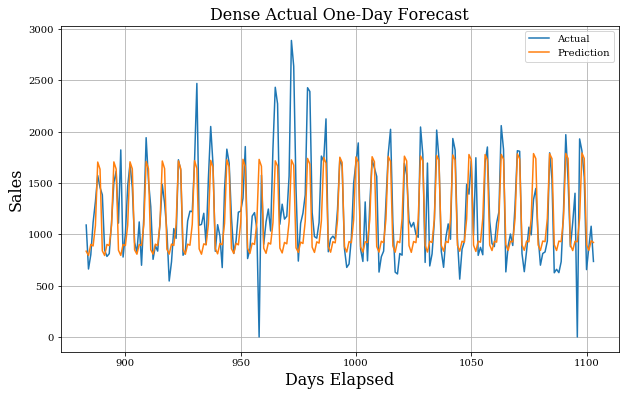

98966.36
215.60019


In [144]:
plt.figure(figsize=(10, 6))
plot_series(time_series, y_test,label='Actual')
plot_series(time_series, forecast,label='Prediction')
plt.title("Dense Actual One-Day Forecast",fontsize=16)
plt.xlabel("Days Elapsed", fontsize=16)
plt.ylabel("Sales", fontsize=16)
plt.legend(loc="upper right")
plt.savefig(fname='Charts/DensePredictonActual.png',dpi=150)
plt.show()
print(keras.metrics.mean_squared_error(y_test, forecast).numpy())
print(keras.metrics.mean_absolute_error(y_test, forecast).numpy())

<b> Simple RNN

In [156]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

feat_reduction = SelectKBest(f_regression, k=72 )
X_new = feat_reduction.fit_transform(X,y)
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=221, random_state=42, shuffle=False)

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    tf.keras.layers.SimpleRNN(8, return_sequences=True),
    keras.layers.Dropout(0.4),
    
    tf.keras.layers.SimpleRNN(4),
    keras.layers.Dropout(0.4),
    
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

es_callback = keras.callbacks.EarlyStopping(monitor='loss', patience=15)
optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(X_train, y_train, epochs=120, callbacks=[es_callback])

y_pred = model.predict(X_test)

Epoch 1/120
28/28 [==============================] - ETA: 0s - loss: 745.4116 - mae: 745.911 - ETA: 0s - loss: 827.8517 - mae: 828.351 - ETA: 0s - loss: 798.5859 - mae: 799.084 - ETA: 0s - loss: 775.4990 - mae: 775.998 - ETA: 0s - loss: 780.7183 - mae: 781.217 - ETA: 0s - loss: 790.6503 - mae: 791.149 - ETA: 0s - loss: 798.5820 - mae: 799.081 - 0s 13ms/step - loss: 795.7910 - mae: 796.2905
Epoch 2/120
28/28 [==============================] - ETA: 0s - loss: 692.5330 - mae: 693.033 - ETA: 0s - loss: 776.9028 - mae: 777.402 - ETA: 0s - loss: 771.3912 - mae: 771.891 - ETA: 0s - loss: 777.4678 - mae: 777.967 - ETA: 0s - loss: 768.0318 - mae: 768.531 - ETA: 0s - loss: 774.7764 - mae: 775.276 - ETA: 0s - loss: 776.9617 - mae: 777.461 - 0s 13ms/step - loss: 778.5734 - mae: 779.0734
Epoch 3/120
28/28 [==============================] - ETA: 0s - loss: 833.2170 - mae: 833.717 - ETA: 0s - loss: 802.2421 - mae: 802.742 - ETA: 0s - loss: 793.3552 - mae: 793.855 - ETA: 0s - loss: 778.5056 - mae: 779

28/28 [==============================] - ETA: 0s - loss: 409.2808 - mae: 409.780 - ETA: 0s - loss: 446.6866 - mae: 447.185 - ETA: 0s - loss: 452.6015 - mae: 453.101 - ETA: 0s - loss: 464.5417 - mae: 465.041 - ETA: 0s - loss: 464.0003 - mae: 464.500 - ETA: 0s - loss: 452.7123 - mae: 453.212 - ETA: 0s - loss: 448.7761 - mae: 449.275 - 0s 13ms/step - loss: 449.4858 - mae: 449.9857
Epoch 42/120
28/28 [==============================] - ETA: 0s - loss: 400.8391 - mae: 401.339 - ETA: 0s - loss: 455.6897 - mae: 456.189 - ETA: 0s - loss: 448.8257 - mae: 449.325 - ETA: 0s - loss: 456.9627 - mae: 457.462 - ETA: 0s - loss: 449.7784 - mae: 450.278 - ETA: 0s - loss: 446.6544 - mae: 447.154 - ETA: 0s - loss: 462.2176 - mae: 462.717 - ETA: 0s - loss: 467.7082 - mae: 468.207 - 0s 15ms/step - loss: 467.6657 - mae: 468.1655
Epoch 43/120
28/28 [==============================] - ETA: 0s - loss: 424.3042 - mae: 424.804 - ETA: 0s - loss: 452.9777 - mae: 453.477 - ETA: 0s - loss: 437.1889 - mae: 437.688 - ETA

28/28 [==============================] - ETA: 0s - loss: 394.1429 - mae: 394.642 - ETA: 0s - loss: 420.3214 - mae: 420.821 - ETA: 0s - loss: 438.4499 - mae: 438.949 - ETA: 0s - loss: 431.3065 - mae: 431.806 - ETA: 0s - loss: 440.7745 - mae: 441.274 - ETA: 0s - loss: 440.1121 - mae: 440.612 - ETA: 0s - loss: 437.8448 - mae: 438.344 - ETA: 0s - loss: 439.9545 - mae: 440.454 - 0s 14ms/step - loss: 439.9545 - mae: 440.4544
Epoch 82/120
28/28 [==============================] - ETA: 0s - loss: 405.7334 - mae: 406.233 - ETA: 0s - loss: 415.1191 - mae: 415.619 - ETA: 0s - loss: 428.4468 - mae: 428.945 - ETA: 0s - loss: 428.0449 - mae: 428.543 - ETA: 0s - loss: 427.2296 - mae: 427.728 - ETA: 0s - loss: 433.0963 - mae: 433.595 - ETA: 0s - loss: 439.3068 - mae: 439.806 - 0s 14ms/step - loss: 433.0317 - mae: 433.5311
Epoch 83/120
28/28 [==============================] - ETA: 0s - loss: 502.7077 - mae: 503.207 - ETA: 0s - loss: 448.7416 - mae: 449.241 - ETA: 0s - loss: 438.1712 - mae: 438.671 - ETA

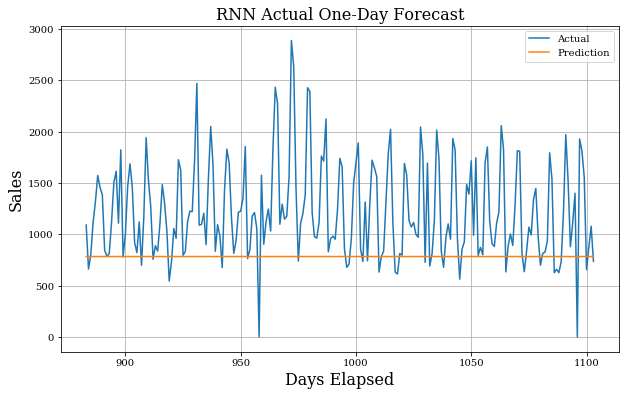

412965.97
481.2168


In [157]:
plt.figure(figsize=(10, 6))
plot_series(time_series, y_test,label='Actual')
plot_series(time_series, y_pred,label='Prediction')
plt.title("RNN Actual One-Day Forecast",fontsize=16)
plt.xlabel("Days Elapsed", fontsize=16)
plt.ylabel("Sales", fontsize=16)
plt.legend(loc="upper right")
plt.savefig(fname='Charts/RNNPredictonActual.png',dpi=150)
plt.show()

print(keras.metrics.mean_squared_error(y_test, y_pred.flatten()).numpy())
print(keras.metrics.mean_absolute_error(y_test, y_pred.flatten()).numpy())

<b> Convolutional LSTM

In [158]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()

feat_reduction = SelectKBest(f_regression, k=22) 
X_new = feat_reduction.fit_transform(X,y)
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=221, random_state=42, shuffle=False)

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
    keras.layers.Dropout(0.4),
    
    tf.keras.layers.LSTM(32, return_sequences=True),
    keras.layers.Dropout(0.4),
    
    tf.keras.layers.LSTM(32),
    keras.layers.Dropout(0.4),
    
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

es_callback = keras.callbacks.EarlyStopping(monitor='loss', patience=12)

optimizer = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
    optimizer=optimizer,
    metrics=["mae"])
    
history = model.fit(X_train, y_train, epochs=120, callbacks=[es_callback])

y_pred = model.predict(X_test)

Epoch 1/120
28/28 [==============================] - ETA: 0s - loss: 803.8437 - mae: 804.342 - ETA: 0s - loss: 820.3673 - mae: 820.867 - ETA: 0s - loss: 629.3362 - mae: 629.836 - ETA: 0s - loss: 556.2039 - mae: 556.703 - ETA: 0s - loss: 526.9478 - mae: 527.447 - ETA: 0s - loss: 501.0266 - mae: 501.525 - ETA: 0s - loss: 489.7663 - mae: 490.265 - 0s 13ms/step - loss: 483.0371 - mae: 483.5363
Epoch 2/120
28/28 [==============================] - ETA: 0s - loss: 290.8101 - mae: 291.307 - ETA: 0s - loss: 369.6988 - mae: 370.196 - ETA: 0s - loss: 362.3206 - mae: 362.818 - ETA: 0s - loss: 352.8172 - mae: 353.316 - ETA: 0s - loss: 350.5058 - mae: 351.004 - ETA: 0s - loss: 350.5929 - mae: 351.092 - ETA: 0s - loss: 351.1055 - mae: 351.604 - 0s 13ms/step - loss: 344.7912 - mae: 345.2906
Epoch 3/120
28/28 [==============================] - ETA: 0s - loss: 251.4900 - mae: 251.990 - ETA: 0s - loss: 267.7309 - mae: 268.230 - ETA: 0s - loss: 260.5957 - mae: 261.095 - ETA: 0s - loss: 254.7368 - mae: 255

28/28 [==============================] - ETA: 0s - loss: 182.4446 - mae: 182.944 - ETA: 0s - loss: 190.6709 - mae: 191.170 - ETA: 0s - loss: 193.4595 - mae: 193.958 - ETA: 0s - loss: 196.6740 - mae: 197.172 - ETA: 0s - loss: 196.8212 - mae: 197.319 - ETA: 0s - loss: 197.0867 - mae: 197.585 - ETA: 0s - loss: 198.8773 - mae: 199.376 - 0s 13ms/step - loss: 199.3104 - mae: 199.8090
Epoch 42/120
28/28 [==============================] - ETA: 0s - loss: 162.7821 - mae: 163.282 - ETA: 0s - loss: 201.8231 - mae: 202.321 - ETA: 0s - loss: 204.0799 - mae: 204.578 - ETA: 0s - loss: 202.2005 - mae: 202.699 - ETA: 0s - loss: 203.4775 - mae: 203.976 - ETA: 0s - loss: 200.4104 - mae: 200.909 - ETA: 0s - loss: 202.8445 - mae: 203.343 - 0s 13ms/step - loss: 205.4551 - mae: 205.9538
Epoch 43/120
28/28 [==============================] - ETA: 0s - loss: 182.2435 - mae: 182.743 - ETA: 0s - loss: 188.3559 - mae: 188.854 - ETA: 0s - loss: 191.6386 - mae: 192.137 - ETA: 0s - loss: 194.4499 - mae: 194.949 - ETA

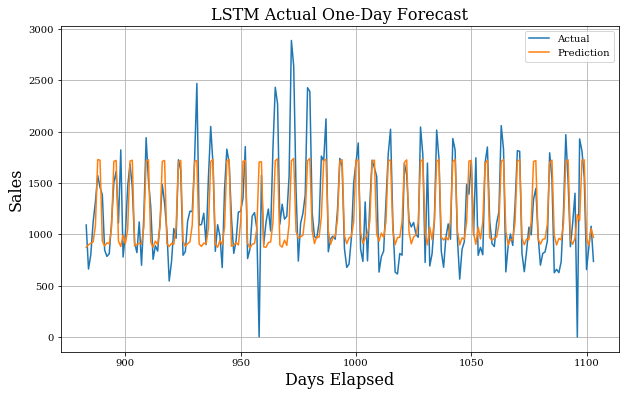

98306.07
220.2514


In [159]:
plt.figure(figsize=(10, 6))
plot_series(time_series, y_test,label='Actual')
plot_series(time_series, y_pred,label='Prediction')
plt.title("LSTM Actual One-Day Forecast",fontsize=16)
plt.xlabel("Days Elapsed", fontsize=16)
plt.ylabel("Sales", fontsize=16)
plt.legend(loc="upper right")
plt.savefig(fname='Charts/LSTMPredictonActual.png',dpi=150)
plt.show()

print(keras.metrics.mean_squared_error(y_test, y_pred.flatten()).numpy())
print(keras.metrics.mean_absolute_error(y_test, y_pred.flatten()).numpy())

<b> GRU Layers

In [160]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

feat_reduction = SelectKBest(f_regression, k=10) 
X_new = feat_reduction.fit_transform(X,y)
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=221, random_state=42, shuffle=False)

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    
    tf.keras.layers.GRU(32, return_sequences=True),
    keras.layers.Dropout(0.4),
    
    tf.keras.layers.GRU(32),
    keras.layers.Dropout(0.4),
    
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

es_callback = keras.callbacks.EarlyStopping(monitor='loss', patience=4)

optimizer = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
    optimizer=optimizer,
    metrics=["mae"])

history = model.fit(X_train, y_train, epochs=120, callbacks=[es_callback])

y_pred = model.predict(X_test)

Epoch 1/120
28/28 [==============================] - ETA: 0s - loss: 804.5192 - mae: 805.019 - ETA: 0s - loss: 617.5182 - mae: 618.018 - ETA: 0s - loss: 509.8529 - mae: 510.352 - ETA: 0s - loss: 466.1679 - mae: 466.667 - 0s 7ms/step - loss: 458.6189 - mae: 459.1189
Epoch 2/120
28/28 [==============================] - ETA: 0s - loss: 260.3452 - mae: 260.845 - ETA: 0s - loss: 371.4110 - mae: 371.910 - ETA: 0s - loss: 357.0786 - mae: 357.577 - ETA: 0s - loss: 365.3273 - mae: 365.825 - 0s 7ms/step - loss: 364.0553 - mae: 364.5540
Epoch 3/120
28/28 [==============================] - ETA: 0s - loss: 311.8264 - mae: 312.315 - ETA: 0s - loss: 275.6653 - mae: 276.163 - ETA: 0s - loss: 277.4684 - mae: 277.966 - ETA: 0s - loss: 284.3775 - mae: 284.875 - 0s 7ms/step - loss: 282.1451 - mae: 282.6434
Epoch 4/120
28/28 [==============================] - ETA: 0s - loss: 202.9767 - mae: 203.476 - ETA: 0s - loss: 254.1526 - mae: 254.652 - ETA: 0s - loss: 264.6399 - mae: 265.139 - ETA: 0s - loss: 258.913

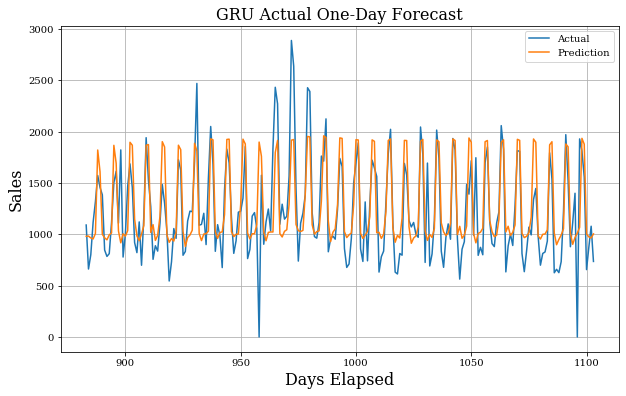

98843.94
230.60722


In [161]:
plt.figure(figsize=(10, 6))
plot_series(time_series, y_test,label='Actual')
plot_series(time_series, y_pred,label='Prediction')
plt.title("GRU Actual One-Day Forecast",fontsize=16)
plt.xlabel("Days Elapsed", fontsize=16)
plt.ylabel("Sales", fontsize=16)
plt.legend(loc="upper right")
plt.savefig(fname='Charts/GRUPredictonActual.png',dpi=150)
plt.show()
print(keras.metrics.mean_squared_error(y_test, y_pred.flatten()).numpy())
print(keras.metrics.mean_absolute_error(y_test, y_pred.flatten()).numpy())

<b> Conv, GRU, and Dense Layers

In [162]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

feat_reduction = SelectKBest(f_regression, k=6) 
X_new = feat_reduction.fit_transform(X,y)
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=221, random_state=42, shuffle=False)

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    
    tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
    keras.layers.Dropout(0.4),
    
    tf.keras.layers.GRU(32, return_sequences=True),
    keras.layers.Dropout(0.4),
    
    tf.keras.layers.GRU(32),
    keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(14),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

optimizer = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)

es_callback = keras.callbacks.EarlyStopping(monitor='loss', patience=12)

model.compile(loss=tf.keras.losses.Huber(),
    optimizer=optimizer,
    metrics=["mae"])

history = model.fit(X_train, y_train, epochs=120, callbacks=[es_callback])

y_pred = model.predict(X_test)

Epoch 1/120
28/28 [==============================] - ETA: 0s - loss: 805.3860 - mae: 805.886 - ETA: 0s - loss: 611.1815 - mae: 611.681 - ETA: 0s - loss: 458.2331 - mae: 458.733 - 0s 5ms/step - loss: 420.2112 - mae: 420.7112
Epoch 2/120
28/28 [==============================] - ETA: 0s - loss: 195.3669 - mae: 195.866 - ETA: 0s - loss: 251.8792 - mae: 252.379 - ETA: 0s - loss: 260.6938 - mae: 261.193 - ETA: 0s - loss: 271.8979 - mae: 272.397 - 0s 6ms/step - loss: 269.7759 - mae: 270.2754
Epoch 3/120
28/28 [==============================] - ETA: 0s - loss: 364.9376 - mae: 365.437 - ETA: 0s - loss: 269.7885 - mae: 270.286 - ETA: 0s - loss: 282.6589 - mae: 283.157 - ETA: 0s - loss: 276.4008 - mae: 276.899 - 0s 6ms/step - loss: 276.4008 - mae: 276.8992
Epoch 4/120
28/28 [==============================] - ETA: 0s - loss: 555.7264 - mae: 556.226 - ETA: 0s - loss: 299.7106 - mae: 300.210 - ETA: 0s - loss: 298.4592 - mae: 298.958 - ETA: 0s - loss: 278.0836 - mae: 278.582 - 0s 6ms/step - loss: 278

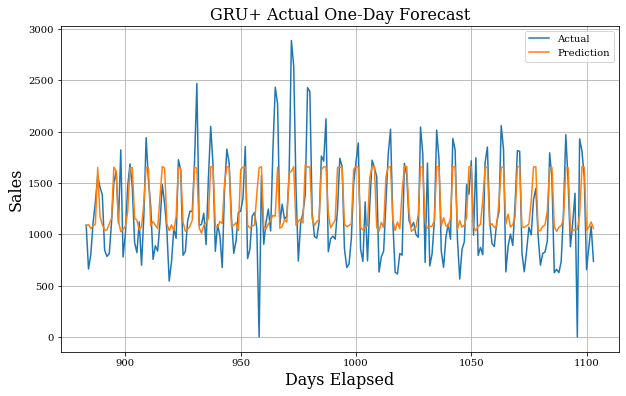

114363.78
248.6843


In [163]:
plt.figure(figsize=(10, 6))
plot_series(time_series, y_test,label='Actual')
plot_series(time_series, y_pred,label='Prediction')
plt.title("GRU+ Actual One-Day Forecast",fontsize=16)
plt.xlabel("Days Elapsed", fontsize=16)
plt.ylabel("Sales", fontsize=16)
plt.legend(loc="upper right")
plt.savefig(fname='Charts/GRUCONVPredictonActual.png',dpi=150)
plt.show()

print(keras.metrics.mean_squared_error(y_test, y_pred.flatten()).numpy())
print(keras.metrics.mean_absolute_error(y_test, y_pred.flatten()).numpy())

#### Predicting Difference

We use the Daily Differenced data and the Weekly Differenced data defined in the previous section. As such, we do not waste space intializing agian.

In [164]:
# fix random seed for reproducibility
np.random.seed(8)
# load the dataset
dataframe = pd.read_csv('Data/RestaurantDataVets_All_2to5_Differenced.csv')
data = dataframe.drop(columns=['Index','DMY','MissingPrevDays','DiffDifference','2to5'])

lookback=14
dataframe_removed_lookback = data.drop([x for x in range(lookback)])
for i in range(lookback):
    dataframe_removed_lookback[i] = 1.0


df = dataframe_removed_lookback[['Year', 'Day', 'January','February',
                         'March','April','May','June','July',
                         'August', 'September', 'October', 'November',
                         'December','Sunday', 'Monday', 'Tuesday',
                         'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Holiday', 'Carnival', 
                         'LentFasting','Ramadan','ChristmasSeason', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 
                         'DailyAvg','WeeklyAvg','MinSales','MaxSales','DailyBusyness',
                          'WeeklyBusyness','AvgDailyDiff','AvgWeeklyDiff','MinDailyDiff',
                         'MaxDailyDiff', 'WeeklyDifference',
                        'DailyDifference']]

df = df.reset_index(drop=True)

#Objects need to be converted to float due to missing values at load time.
df["DailyAvg"] = df.DailyAvg.astype(float)
df["WeeklyAvg"] = df.WeeklyAvg.astype(float)
df["MinSales"] = df.MinSales.astype(float)
df["MaxSales"] = df.MaxSales.astype(float)
df["DailyBusyness"] = df.DailyBusyness.astype(float)
df["WeeklyBusyness"] = df.WeeklyBusyness.astype(float)


df["AvgDailyDiff"] = df.AvgDailyDiff.astype(float)
df["AvgWeeklyDiff"] = df.AvgWeeklyDiff.astype(float)
df["MaxDailyDiff"] = df.MaxDailyDiff.astype(float)
df["MinDailyDiff"] = df.MinDailyDiff.astype(float)
df["DailyDifference"] = df.DailyDifference.astype(float)
df["WeeklyDifference"] = df.WeeklyDifference.astype(float)

df2 = df.copy()
data2 = data.copy()
diff_add_lookback(data, lookback, df,'WeeklyDifference')
diff_add_lookback(data2, lookback, df2,'DailyDifference')

hotdata_week = onehotholidaydiff(df, 'WeeklyDifference')
hotdata_day = onehotholidaydiff(df2, 'DailyDifference')

hotdata_week = hotdata_week.drop([x for x in range(7)])
hotdata_week = hotdata_week.reset_index(drop=True)

hotdata_day = hotdata_day.drop([x for x in range(1)])
hotdata_day= hotdata_day.reset_index(drop=True)


cols = hotdata_week.columns[hotdata_week.dtypes.eq('object')]
hotdata_week[cols] = hotdata_week[cols].apply(pd.to_numeric, errors='coerce', axis=1)

cols2 = hotdata_day.columns[hotdata_day.dtypes.eq('object')]
hotdata_day[cols2] = hotdata_day[cols2].apply(pd.to_numeric, errors='coerce', axis=1)

numcols = len(hotdata_week.columns)-1

print("train_df Shape:" ,data.shape)
print("After encoding week:", hotdata_week.shape)
print("After encoding day:", hotdata_day.shape)
weekly_difference_data = hotdata_week.drop(columns=['DailyDifference'])
weekly_difference_data = weekly_difference_data.values

daily_difference_data = hotdata_day.drop(columns=['WeeklyDifference'])
daily_difference_data = daily_difference_data.values

C:\Users\Austin\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Austin\Anaconda3\lib\site-packages\pandas\core\indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


train_df Shape: (1111, 39)
After encoding week: (1090, 79)
After encoding day: (1096, 79)


<b> Daily Difference

In [165]:
X=daily_difference_data[:, 0:numcols-1]
y=daily_difference_data[:, numcols-1]

scaler = preprocessing.RobustScaler()
X = scaler.fit_transform(X,y)

<b> Dense Layers

In [166]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

feat_reduction = SelectKBest(f_regression, k=1) 
X_new = feat_reduction.fit_transform(X,y)
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=221, random_state=42, shuffle=False)

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    tf.keras.layers.Dense(32),
    keras.layers.Dropout(0.4),
    
    tf.keras.layers.Dense(16),
    keras.layers.Dropout(0.4),
    
    tf.keras.layers.Dense(1)
])


es_callback = keras.callbacks.EarlyStopping(monitor='loss', patience=8)

optimizer = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(X_train, y_train, epochs=200, callbacks=[es_callback])

forecast = []
for test in X_test:
    y_pred = model.predict(test).mean()
    forecast.append(y_pred)

Epoch 1/200
28/28 [==============================] - ETA: 0s - loss: 411.7932 - mae: 412.293 - 0s 892us/step - loss: 350.8084 - mae: 351.3076
Epoch 2/200
28/28 [==============================] - ETA: 0s - loss: 300.1127 - mae: 300.612 - 0s 999us/step - loss: 350.7781 - mae: 351.2772
Epoch 3/200
28/28 [==============================] - ETA: 0s - loss: 300.6543 - mae: 301.154 - 0s 892us/step - loss: 350.7519 - mae: 351.2506
Epoch 4/200
28/28 [==============================] - ETA: 0s - loss: 426.7752 - mae: 427.275 - 0s 821us/step - loss: 350.7269 - mae: 351.2259
Epoch 5/200
28/28 [==============================] - ETA: 0s - loss: 376.2705 - mae: 376.770 - 0s 857us/step - loss: 350.6911 - mae: 351.1896
Epoch 6/200
28/28 [==============================] - ETA: 0s - loss: 342.2129 - mae: 342.711 - 0s 964us/step - loss: 350.6576 - mae: 351.1561
Epoch 7/200
28/28 [==============================] - ETA: 0s - loss: 316.4458 - mae: 316.942 - 0s 1ms/step - loss: 350.6254 - mae: 351.1245
Epoch 8/

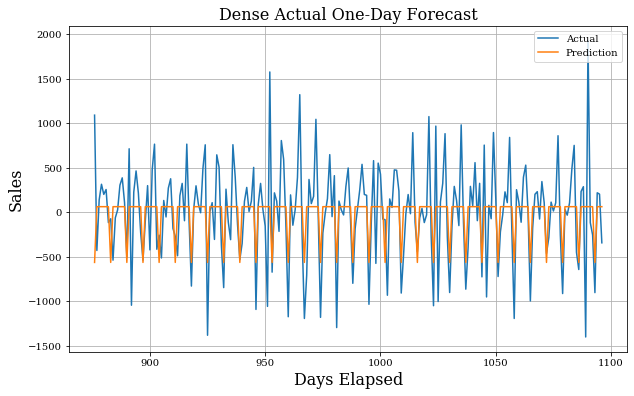

296955.4
402.414


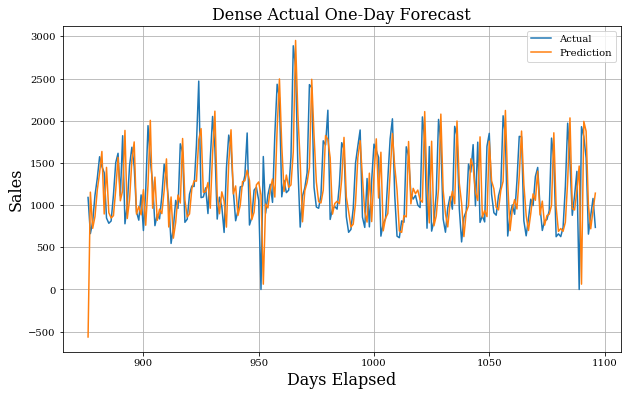

209848.86102503625
334.6746886040183


In [169]:
plt.figure(figsize=(10, 6))
plot_series(diff_time[-221:], y_test, label='Actual')
plot_series(diff_time[-221:], forecast, label='Prediction')
plt.title("Dense Daily Differenced One-Day Forecast",fontsize=16)
plt.xlabel("Days Elapsed", fontsize=16)
plt.ylabel("Sales", fontsize=16)
plt.legend(loc="best")
plt.savefig(fname='Charts/DensePredictonDailyDiff.png',dpi=150)
plt.show()

print(keras.metrics.mean_squared_error(y_test, y_pred).numpy())
print(keras.metrics.mean_absolute_error(y_test, y_pred).numpy())
#Adding predicted difference to get final results.
added_back = price_series[-222:-1] + forecast
y_true = price_series[-221:] 
plt.figure(figsize=(10, 6))
plot_series(diff_time[-221:], y_true, label='Actual')
plot_series(diff_time[-221:], added_back, label='Prediction')
plt.title("Dense Actual One-Day Forecast",fontsize=16)
plt.xlabel("Days Elapsed", fontsize=16)
plt.ylabel("Sales", fontsize=16)
plt.legend(loc="upper right")
plt.savefig(fname='Charts/DensePredictonDailyDiffAB.png',dpi=150)
plt.show()

print(keras.metrics.mean_squared_error(y_true, added_back).numpy())
print(keras.metrics.mean_absolute_error(y_true, added_back).numpy())

<b> RNN Layers

In [170]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

feat_reduction = SelectKBest(f_regression, k=2 )
X_new = feat_reduction.fit_transform(X,y)
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=221, random_state=42, shuffle=False)

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    tf.keras.layers.SimpleRNN(8, return_sequences=True),
    keras.layers.Dropout(0.4),
    
    tf.keras.layers.SimpleRNN(4),
    keras.layers.Dropout(0.4),
    
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

es_callback = keras.callbacks.EarlyStopping(monitor='loss', patience=15)
optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(X_train, y_train, epochs=120, callbacks=[es_callback])

y_pred = model.predict(X_test)

Epoch 1/120
28/28 [==============================] - ETA: 0s - loss: 415.4323 - mae: 415.932 - 0s 1ms/step - loss: 347.1357 - mae: 347.6357
Epoch 2/120
28/28 [==============================] - ETA: 0s - loss: 293.0851 - mae: 293.585 - 0s 1ms/step - loss: 347.5991 - mae: 348.0979
Epoch 3/120
28/28 [==============================] - ETA: 0s - loss: 308.8949 - mae: 309.394 - 0s 1ms/step - loss: 346.6264 - mae: 347.1264
Epoch 4/120
28/28 [==============================] - ETA: 0s - loss: 432.4563 - mae: 432.956 - 0s 1ms/step - loss: 347.3691 - mae: 347.8689
Epoch 5/120
28/28 [==============================] - ETA: 0s - loss: 360.0810 - mae: 360.581 - 0s 1ms/step - loss: 344.4218 - mae: 344.9211
Epoch 6/120
28/28 [==============================] - ETA: 0s - loss: 352.7381 - mae: 353.238 - 0s 1ms/step - loss: 343.8001 - mae: 344.2986
Epoch 7/120
28/28 [==============================] - ETA: 0s - loss: 330.7151 - mae: 331.215 - 0s 1ms/step - loss: 341.0373 - mae: 341.5369
Epoch 8/120
28/28 [=

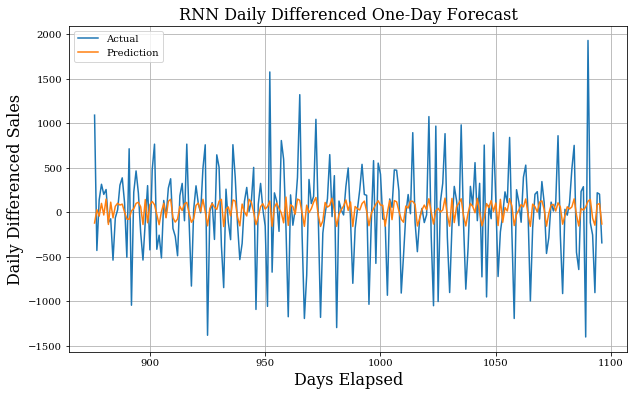

247504.42427718887
370.61091246626495


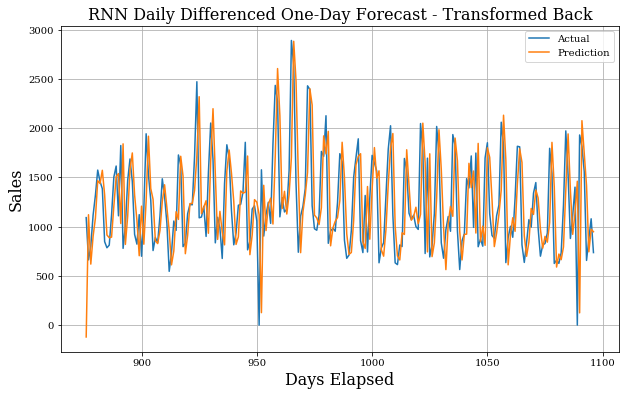

247504.42427718887
370.61091246626495


In [174]:
plt.figure(figsize=(10, 6))
plot_series(diff_time[-221:], y_test,label='Actual')
plot_series(diff_time[-221:], y_pred,label='Prediction')
plt.title("RNN Daily Differenced One-Day Forecast",fontsize=16)
plt.xlabel("Days Elapsed", fontsize=16)
plt.ylabel("Daily Differenced Sales", fontsize=16)
plt.legend(loc="best")
plt.savefig(fname='Charts/DensePredictonDailyDiff.png',dpi=150)
plt.savefig(fname='Charts/RNNPredictonDailyDiff.png',dpi=150)
plt.show()
print(keras.metrics.mean_squared_error(y_pred.flatten(), y_test).numpy())
print(keras.metrics.mean_absolute_error(y_pred.flatten(), y_test).numpy())


#Adding predicted difference to get final results.
added_back = price_series[-222:-1] + y_pred.flatten()
y_true = price_series[-221:] 
plt.figure(figsize=(10, 6))
plot_series(diff_time[-221:], y_true,label='Actual')
plot_series(diff_time[-221:], added_back,label='Prediction')
plt.title("RNN Daily Differenced One-Day Forecast - Transformed Back",fontsize=16)
plt.xlabel("Days Elapsed", fontsize=16)
plt.ylabel("Sales", fontsize=16)
plt.legend(loc="upper right")
plt.savefig(fname='Charts/RNNPredictonDailyDiffAB.png',dpi=150)
plt.show()
print(keras.metrics.mean_squared_error(y_true, added_back).numpy())
print(keras.metrics.mean_absolute_error(y_true, added_back).numpy())

<b> LSTM Layers

In [179]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()

feat_reduction = SelectKBest(f_regression, k=12) 
X_new = feat_reduction.fit_transform(X,y)
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=221, random_state=42, shuffle=False)

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
    keras.layers.Dropout(0.4),
    
    tf.keras.layers.LSTM(32, return_sequences=True),
    keras.layers.Dropout(0.4),
    
    tf.keras.layers.LSTM(32),
    keras.layers.Dropout(0.4),
    
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

es_callback = keras.callbacks.EarlyStopping(monitor='loss', patience=12)

optimizer = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
    optimizer=optimizer,
    metrics=["mae"])
    
history = model.fit(X_train, y_train, epochs=120, callbacks=[es_callback])

y_pred = model.predict(X_test)

Epoch 1/120
28/28 [==============================] - ETA: 0s - loss: 410.6839 - mae: 411.183 - ETA: 0s - loss: 373.0890 - mae: 373.588 - ETA: 0s - loss: 369.7049 - mae: 370.204 - ETA: 0s - loss: 354.9906 - mae: 355.490 - ETA: 0s - loss: 351.7588 - mae: 352.258 - 0s 8ms/step - loss: 350.5302 - mae: 351.0300
Epoch 2/120
28/28 [==============================] - ETA: 0s - loss: 314.7860 - mae: 315.286 - ETA: 0s - loss: 349.1082 - mae: 349.608 - ETA: 0s - loss: 366.1463 - mae: 366.645 - ETA: 0s - loss: 358.2482 - mae: 358.746 - ETA: 0s - loss: 351.7573 - mae: 352.256 - 0s 8ms/step - loss: 351.6924 - mae: 352.1913
Epoch 3/120
28/28 [==============================] - ETA: 0s - loss: 293.0498 - mae: 293.549 - ETA: 0s - loss: 337.9969 - mae: 338.496 - ETA: 0s - loss: 337.0607 - mae: 337.558 - ETA: 0s - loss: 344.6157 - mae: 345.114 - ETA: 0s - loss: 347.8020 - mae: 348.300 - 0s 8ms/step - loss: 349.0007 - mae: 349.4996
Epoch 4/120
28/28 [==============================] - ETA: 0s - loss: 434.679

28/28 [==============================] - ETA: 0s - loss: 245.9595 - mae: 246.459 - ETA: 0s - loss: 230.2982 - mae: 230.797 - ETA: 0s - loss: 222.4065 - mae: 222.905 - ETA: 0s - loss: 221.6338 - mae: 222.133 - ETA: 0s - loss: 225.4353 - mae: 225.934 - 0s 8ms/step - loss: 227.9317 - mae: 228.4313
Epoch 54/120
28/28 [==============================] - ETA: 0s - loss: 269.9927 - mae: 270.492 - ETA: 0s - loss: 209.9645 - mae: 210.462 - ETA: 0s - loss: 225.6178 - mae: 226.115 - ETA: 0s - loss: 229.6182 - mae: 230.116 - ETA: 0s - loss: 225.3646 - mae: 225.862 - 0s 8ms/step - loss: 224.8648 - mae: 225.3631
Epoch 55/120
28/28 [==============================] - ETA: 0s - loss: 282.4102 - mae: 282.902 - ETA: 0s - loss: 232.0782 - mae: 232.577 - ETA: 0s - loss: 225.8952 - mae: 226.394 - ETA: 0s - loss: 226.9633 - mae: 227.462 - ETA: 0s - loss: 228.9390 - mae: 229.438 - 0s 8ms/step - loss: 228.2088 - mae: 228.7080
Epoch 56/120
28/28 [==============================] - ETA: 0s - loss: 230.2169 - mae: 

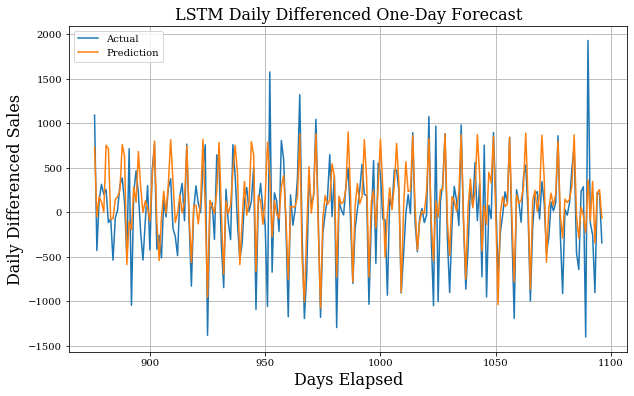

145461.07153044382
278.7054785155495


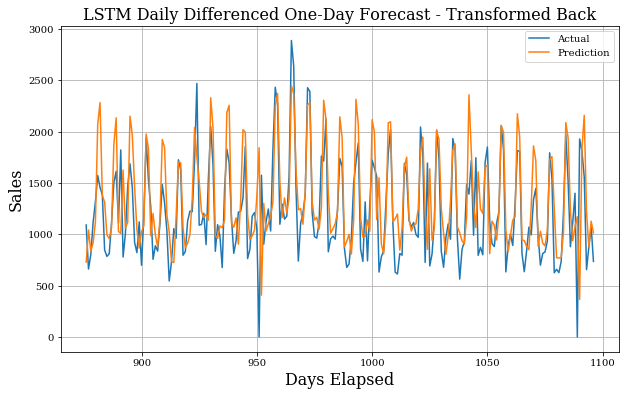

145461.07153044382
278.7054785155495


In [180]:
plt.figure(figsize=(10, 6))
plot_series(diff_time[-221:], y_test,label='Actual')
plot_series(diff_time[-221:], y_pred,label='Prediction')
plt.title("LSTM Daily Differenced One-Day Forecast",fontsize=16)
plt.xlabel("Days Elapsed", fontsize=16)
plt.ylabel("Daily Differenced Sales", fontsize=16)
plt.legend(loc="best")
plt.savefig(fname='Charts/LSTMPredictonDailyDiff.png',dpi=150)
plt.show()
print(keras.metrics.mean_squared_error(y_pred.flatten(), y_test).numpy())
print(keras.metrics.mean_absolute_error(y_pred.flatten(), y_test).numpy())


#Adding predicted difference to get final results.
added_back = price_series[-222:-1] + y_pred.flatten()
y_true = price_series[-221:] 
plt.figure(figsize=(10, 6))
plot_series(diff_time[-221:], y_true,label='Actual')
plot_series(diff_time[-221:], added_back,label='Prediction')
plt.title("LSTM Daily Differenced One-Day Forecast - Transformed Back",fontsize=16)
plt.xlabel("Days Elapsed", fontsize=16)
plt.ylabel("Sales", fontsize=16)
plt.legend(loc="upper right")
plt.savefig(fname='Charts/LSTMPredictonDailyDiffAB.png',dpi=150)
plt.show()
print(keras.metrics.mean_squared_error(y_true, added_back).numpy())
print(keras.metrics.mean_absolute_error(y_true, added_back).numpy())

<b> GRU Layer

In [181]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

feat_reduction = SelectKBest(f_regression, k=15) 
X_new = feat_reduction.fit_transform(X,y)
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=221, random_state=42, shuffle=False)

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    
    tf.keras.layers.GRU(32, return_sequences=True),
    keras.layers.Dropout(0.4),
    
    tf.keras.layers.GRU(32),
    keras.layers.Dropout(0.4),
    
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

es_callback = keras.callbacks.EarlyStopping(monitor='loss', patience=4)

optimizer = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
    optimizer=optimizer,
    metrics=["mae"])

history = model.fit(X_train, y_train, epochs=120, callbacks=[es_callback])

y_pred = model.predict(X_test)

Epoch 1/120
28/28 [==============================] - ETA: 0s - loss: 407.2641 - mae: 407.764 - ETA: 0s - loss: 381.5952 - mae: 382.095 - ETA: 0s - loss: 369.2238 - mae: 369.723 - ETA: 0s - loss: 355.7619 - mae: 356.261 - ETA: 0s - loss: 346.8133 - mae: 347.312 - 0s 10ms/step - loss: 345.5452 - mae: 346.0449
Epoch 2/120
28/28 [==============================] - ETA: 0s - loss: 311.8409 - mae: 312.340 - ETA: 0s - loss: 345.6050 - mae: 346.103 - ETA: 0s - loss: 365.4997 - mae: 365.998 - ETA: 0s - loss: 364.5387 - mae: 365.038 - ETA: 0s - loss: 355.0352 - mae: 355.534 - 0s 9ms/step - loss: 349.0837 - mae: 349.5829
Epoch 3/120
28/28 [==============================] - ETA: 0s - loss: 312.5846 - mae: 313.084 - ETA: 0s - loss: 331.8727 - mae: 332.372 - ETA: 0s - loss: 333.2713 - mae: 333.770 - ETA: 0s - loss: 330.5385 - mae: 331.037 - ETA: 0s - loss: 333.3097 - mae: 333.809 - 0s 9ms/step - loss: 330.8781 - mae: 331.3775
Epoch 4/120
28/28 [==============================] - ETA: 0s - loss: 360.62

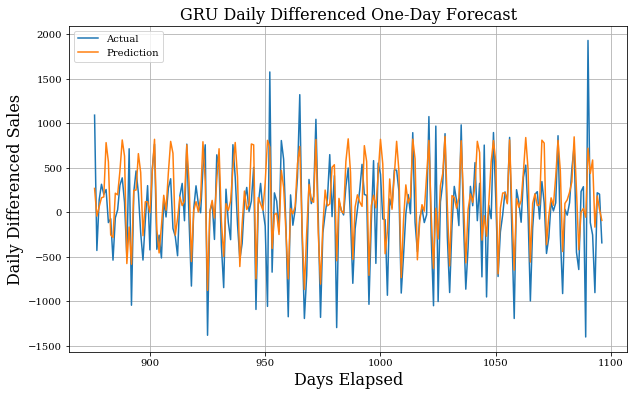

153837.4631814719
294.3939983383455


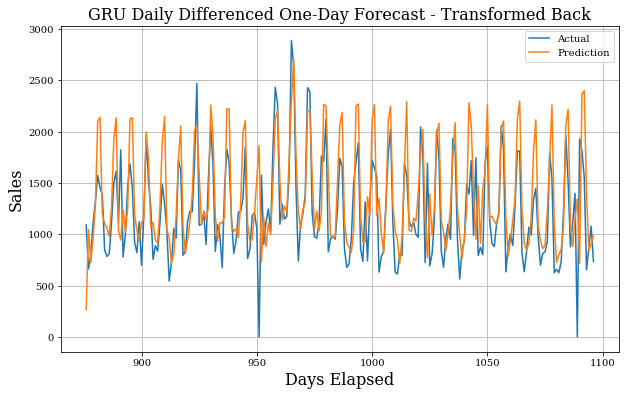

153837.4631814719
294.39399833834545


In [182]:
plt.figure(figsize=(10, 6))
plot_series(diff_time[-221:], y_test,label='Actual')
plot_series(diff_time[-221:], y_pred,label='Prediction')
plt.title("GRU Daily Differenced One-Day Forecast",fontsize=16)
plt.xlabel("Days Elapsed", fontsize=16)
plt.ylabel("Daily Differenced Sales", fontsize=16)
plt.legend(loc="best")
plt.savefig(fname='Charts/GRUPredictonDailyDiff.png',dpi=150)
plt.show()
print(keras.metrics.mean_squared_error(y_pred.flatten(), y_test).numpy())
print(keras.metrics.mean_absolute_error(y_pred.flatten(), y_test).numpy())


#Adding predicted difference to get final results.
added_back = price_series[-222:-1] + y_pred.flatten()
y_true = price_series[-221:] 
plt.figure(figsize=(10, 6))
plot_series(diff_time[-221:], y_true,label='Actual')
plot_series(diff_time[-221:], added_back,label='Prediction')
plt.title("GRU Daily Differenced One-Day Forecast - Transformed Back",fontsize=16)
plt.xlabel("Days Elapsed", fontsize=16)
plt.ylabel("Sales", fontsize=16)
plt.legend(loc="upper right")
plt.savefig(fname='Charts/GRUPredictonDailyDiffAB.png',dpi=150)
plt.show()
print(keras.metrics.mean_squared_error(y_true, added_back).numpy())
print(keras.metrics.mean_absolute_error(y_true, added_back).numpy())

<b> GRU layers supported with Dense and Conv

In [183]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

feat_reduction = SelectKBest(f_regression, k=17) 
X_new = feat_reduction.fit_transform(X,y)
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=221, random_state=42, shuffle=False)

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    
    tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
    keras.layers.Dropout(0.4),
    
    tf.keras.layers.GRU(32, return_sequences=True),
    keras.layers.Dropout(0.4),
    
    tf.keras.layers.GRU(32),
    keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(14),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

es_callback = keras.callbacks.EarlyStopping(monitor='loss', patience=10)

optimizer = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
    optimizer=optimizer,
    metrics=["mae"])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
    optimizer=optimizer,
    metrics=["mae"])

history = model.fit(X_train, y_train, epochs=120, callbacks=[es_callback])

y_pred = model.predict(X_test)

Epoch 1/120
28/28 [==============================] - ETA: 0s - loss: 414.2427 - mae: 414.742 - ETA: 0s - loss: 388.3927 - mae: 388.892 - ETA: 0s - loss: 368.3738 - mae: 368.873 - ETA: 0s - loss: 365.5260 - mae: 366.025 - ETA: 0s - loss: 352.7999 - mae: 353.299 - ETA: 0s - loss: 349.7426 - mae: 350.242 - 0s 11ms/step - loss: 349.1828 - mae: 349.6826
Epoch 2/120
28/28 [==============================] - ETA: 0s - loss: 307.8831 - mae: 308.383 - ETA: 0s - loss: 329.6774 - mae: 330.177 - ETA: 0s - loss: 352.9741 - mae: 353.474 - ETA: 0s - loss: 364.9988 - mae: 365.498 - ETA: 0s - loss: 350.0103 - mae: 350.510 - ETA: 0s - loss: 341.4785 - mae: 341.978 - 0s 11ms/step - loss: 341.3653 - mae: 341.8653
Epoch 3/120
28/28 [==============================] - ETA: 0s - loss: 358.2457 - mae: 358.745 - ETA: 0s - loss: 327.0335 - mae: 327.533 - ETA: 0s - loss: 328.2683 - mae: 328.768 - ETA: 0s - loss: 320.2825 - mae: 320.782 - ETA: 0s - loss: 312.6263 - mae: 313.126 - ETA: 0s - loss: 313.1678 - mae: 313

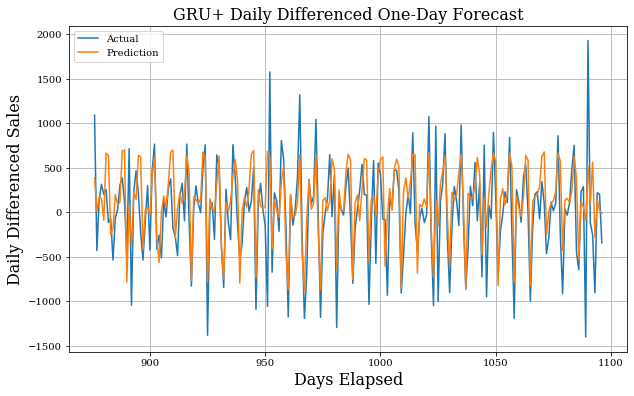

159921.21812979106
299.42715414193964


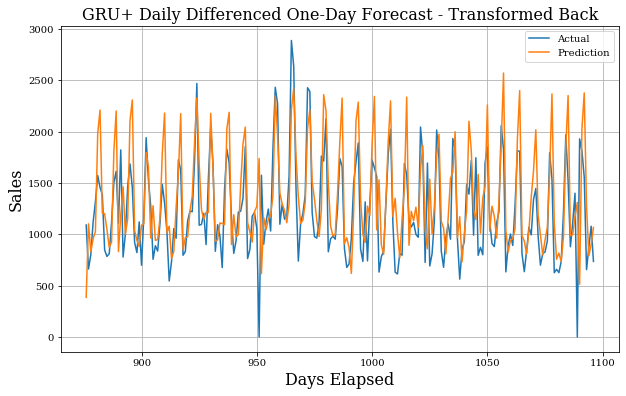

159921.21812979106
299.4271541419397


In [184]:
plt.figure(figsize=(10, 6))
plot_series(diff_time[-221:], y_test,label='Actual')
plot_series(diff_time[-221:], y_pred,label='Prediction')
plt.title("GRU+ Daily Differenced One-Day Forecast",fontsize=16)
plt.xlabel("Days Elapsed", fontsize=16)
plt.ylabel("Daily Differenced Sales", fontsize=16)
plt.legend(loc="best")
plt.savefig(fname='Charts/GRUCONVPredictonDailyDiff.png',dpi=150)
plt.show()
print(keras.metrics.mean_squared_error(y_pred.flatten(), y_test).numpy())
print(keras.metrics.mean_absolute_error(y_pred.flatten(), y_test).numpy())


#Adding predicted difference to get final results.
added_back = price_series[-222:-1] + y_pred.flatten()
y_true = price_series[-221:] 
plt.figure(figsize=(10, 6))
plot_series(diff_time[-221:], y_true,label='Actual')
plot_series(diff_time[-221:], added_back,label='Prediction')
plt.title("GRU+ Daily Differenced One-Day Forecast - Transformed Back",fontsize=16)
plt.xlabel("Days Elapsed", fontsize=16)
plt.ylabel("Sales", fontsize=16)
plt.legend(loc="upper right")
plt.savefig(fname='Charts/GRUCONVPredictonDailyDiffAB.png',dpi=150)
plt.show()
print(keras.metrics.mean_squared_error(y_true, added_back).numpy())
print(keras.metrics.mean_absolute_error(y_true, added_back).numpy())

<b> Weekly Difference

In [185]:
X=weekly_difference_data[:, 0:numcols-1]
y=weekly_difference_data[:, numcols-1]

scaler = preprocessing.RobustScaler()
X = scaler.fit_transform(X,y)

<b> Dense Layers

In [186]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

feat_reduction = SelectKBest(f_regression, k=2) 
X_new = feat_reduction.fit_transform(X,y)
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=221, random_state=42, shuffle=False)

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    tf.keras.layers.Dense(32),
    keras.layers.Dropout(0.4),
    
    tf.keras.layers.Dense(16),
    keras.layers.Dropout(0.4),
    
    tf.keras.layers.Dense(1)
])


es_callback = keras.callbacks.EarlyStopping(monitor='loss', patience=8)

optimizer = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(X_train, y_train, epochs=200, callbacks=[es_callback])

forecast = []
for test in X_test:
    y_pred = model.predict(test)
    forecast.append(y_pred.mean())

Epoch 1/200
28/28 [==============================] - ETA: 0s - loss: 230.7058 - mae: 231.205 - 0s 1ms/step - loss: 243.9434 - mae: 244.4423
Epoch 2/200
28/28 [==============================] - ETA: 0s - loss: 217.2931 - mae: 217.793 - 0s 1ms/step - loss: 243.9231 - mae: 244.4217
Epoch 3/200
28/28 [==============================] - ETA: 0s - loss: 218.9539 - mae: 219.453 - 0s 999us/step - loss: 243.8705 - mae: 244.3693
Epoch 4/200
28/28 [==============================] - ETA: 0s - loss: 174.9879 - mae: 175.487 - 0s 964us/step - loss: 243.8349 - mae: 244.3338
Epoch 5/200
28/28 [==============================] - ETA: 0s - loss: 187.0249 - mae: 187.514 - 0s 999us/step - loss: 243.8017 - mae: 244.3006
Epoch 6/200
28/28 [==============================] - ETA: 0s - loss: 176.9661 - mae: 177.466 - 0s 964us/step - loss: 243.7863 - mae: 244.2852
Epoch 7/200
28/28 [==============================] - ETA: 0s - loss: 288.3372 - mae: 288.837 - 0s 928us/step - loss: 243.7486 - mae: 244.2478
Epoch 8/20

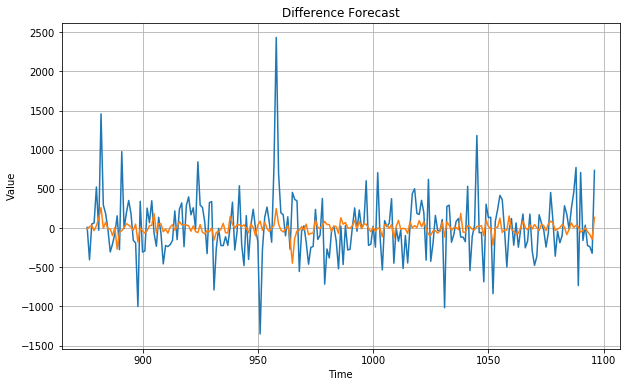

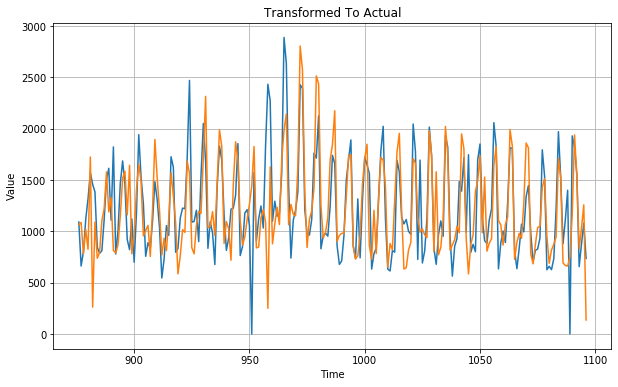

142702.8834318998
267.3048574581729


In [39]:
plt.figure(figsize=(10, 6))
plt.title('Difference Forecast')
plot_series(diff_time[-221:], y_test)
plot_series(diff_time[-221:], forecast)
plt.savefig(fname='Charts/DensePredictonWeeklyDiff.png',dpi=150)
plt.show()

#Adding predicted difference to get final results.
added_back = price_series[-228:-7] + forecast
y_true = price_series[-221:] 
plt.figure(figsize=(10, 6))
plt.title('Transformed To Actual')
plot_series(diff_time[-221:], y_true)
plot_series(diff_time[-221:], added_back)
plt.savefig(fname='Charts/DensePredictonWeeklyDiffAB.png',dpi=150)
plt.show()

print(keras.metrics.mean_squared_error(y_true, added_back).numpy())
print(keras.metrics.mean_absolute_error(y_true, added_back).numpy())

<b> RNN Layers

In [187]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

feat_reduction = SelectKBest(f_regression, k=1 )
X_new = feat_reduction.fit_transform(X,y)
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=221, random_state=42, shuffle=False)

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    tf.keras.layers.SimpleRNN(8, return_sequences=True),
    keras.layers.Dropout(0.4),
    
    tf.keras.layers.SimpleRNN(4),
    keras.layers.Dropout(0.4),
    
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

es_callback = keras.callbacks.EarlyStopping(monitor='loss', patience=15)
optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(X_train, y_train, epochs=120, callbacks=[es_callback])

y_pred = model.predict(X_test)

Epoch 1/120
28/28 [==============================] - ETA: 0s - loss: 247.4166 - mae: 247.916 - 0s 1ms/step - loss: 261.8155 - mae: 262.3148
Epoch 2/120
28/28 [==============================] - ETA: 0s - loss: 238.7128 - mae: 239.212 - 0s 1ms/step - loss: 263.5114 - mae: 264.0106
Epoch 3/120
28/28 [==============================] - ETA: 0s - loss: 246.2496 - mae: 246.749 - 0s 1ms/step - loss: 263.8625 - mae: 264.3613
Epoch 4/120
28/28 [==============================] - ETA: 0s - loss: 176.6175 - mae: 177.117 - 0s 1ms/step - loss: 259.5349 - mae: 260.0323
Epoch 5/120
28/28 [==============================] - ETA: 0s - loss: 183.3203 - mae: 183.820 - 0s 1ms/step - loss: 257.0623 - mae: 257.5623
Epoch 6/120
28/28 [==============================] - ETA: 0s - loss: 199.0004 - mae: 199.500 - 0s 1ms/step - loss: 255.1788 - mae: 255.6773
Epoch 7/120
28/28 [==============================] - ETA: 0s - loss: 306.9594 - mae: 307.459 - 0s 1ms/step - loss: 255.1850 - mae: 255.6846
Epoch 8/120
28/28 [=

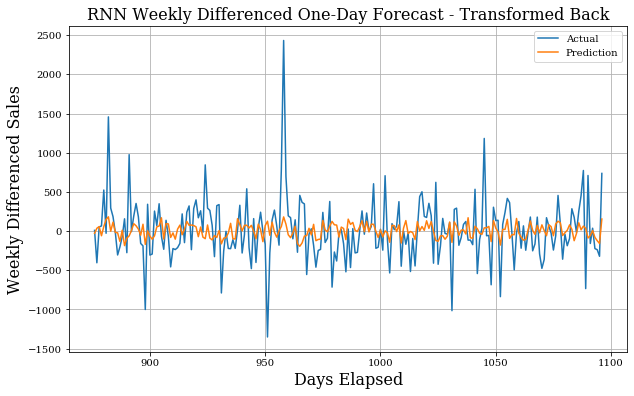

142117.44
262.97424


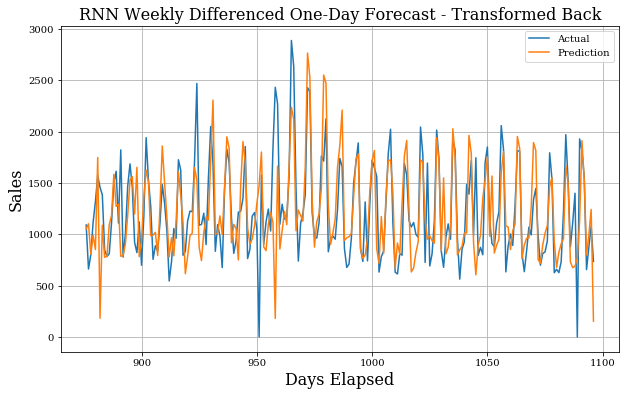

142117.4439976741
262.9742323405926


In [192]:
plt.figure(figsize=(10, 6))

plot_series(diff_time[-221:], y_test,label='Actual')
plot_series(diff_time[-221:], y_pred,label='Prediction')
plt.title("RNN Weekly Differenced One-Day Forecast - Transformed Back",fontsize=16)
plt.xlabel("Days Elapsed", fontsize=16)
plt.ylabel("Weekly Differenced Sales", fontsize=16)
plt.legend(loc="best")
plt.savefig(fname='Charts/RNNPredictonWeeklyDiff.png',dpi=150)
plt.show()

print(keras.metrics.mean_squared_error(y_test, y_pred.flatten()).numpy())
print(keras.metrics.mean_absolute_error(y_test, y_pred.flatten()).numpy())
#Adding predicted difference to get final results.
added_back = price_series[-228:-7] + y_pred.flatten()
y_true = price_series[-221:] 
plt.figure(figsize=(10, 6))

plot_series(diff_time[-221:], y_true,label='Actual')
plot_series(diff_time[-221:], added_back,label='Prediction')
plt.title("RNN Weekly Differenced One-Day Forecast - Transformed Back",fontsize=16)
plt.xlabel("Days Elapsed", fontsize=16)
plt.ylabel("Sales", fontsize=16)
plt.legend(loc="upper right")
plt.savefig(fname='Charts/RNNPredictonWeeklyDiffAB.png',dpi=150)
plt.show()

print(keras.metrics.mean_squared_error(y_true, added_back).numpy())
print(keras.metrics.mean_absolute_error(y_true, added_back).numpy())

<b> LSTM Layers

In [193]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()

feat_reduction = SelectKBest(f_regression, k=7) 
X_new = feat_reduction.fit_transform(X,y)
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=221, random_state=42, shuffle=False)

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
    keras.layers.Dropout(0.4),
    
    tf.keras.layers.LSTM(32, return_sequences=True),
    keras.layers.Dropout(0.4),
    
    tf.keras.layers.LSTM(32),
    keras.layers.Dropout(0.4),
    
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

es_callback = keras.callbacks.EarlyStopping(monitor='loss', patience=12)

optimizer = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
    optimizer=optimizer,
    metrics=["mae"])
    
history = model.fit(X_train, y_train, epochs=120, callbacks=[es_callback])

y_pred = model.predict(X_test)

Epoch 1/120
28/28 [==============================] - ETA: 0s - loss: 230.3870 - mae: 230.887 - ETA: 0s - loss: 243.1766 - mae: 243.676 - ETA: 0s - loss: 243.9130 - mae: 244.413 - ETA: 0s - loss: 244.3125 - mae: 244.812 - 0s 6ms/step - loss: 244.3125 - mae: 244.8125
Epoch 2/120
28/28 [==============================] - ETA: 0s - loss: 207.7970 - mae: 208.297 - ETA: 0s - loss: 230.7096 - mae: 231.208 - ETA: 0s - loss: 236.7832 - mae: 237.282 - ETA: 0s - loss: 235.9606 - mae: 236.460 - 0s 6ms/step - loss: 236.1165 - mae: 236.6160
Epoch 3/120
28/28 [==============================] - ETA: 0s - loss: 253.1413 - mae: 253.641 - ETA: 0s - loss: 239.3669 - mae: 239.866 - ETA: 0s - loss: 228.0562 - mae: 228.556 - ETA: 0s - loss: 231.2201 - mae: 231.720 - 0s 6ms/step - loss: 231.2201 - mae: 231.7201
Epoch 4/120
28/28 [==============================] - ETA: 0s - loss: 182.8699 - mae: 183.369 - ETA: 0s - loss: 233.2338 - mae: 233.732 - ETA: 0s - loss: 218.5661 - mae: 219.065 - ETA: 0s - loss: 228.463

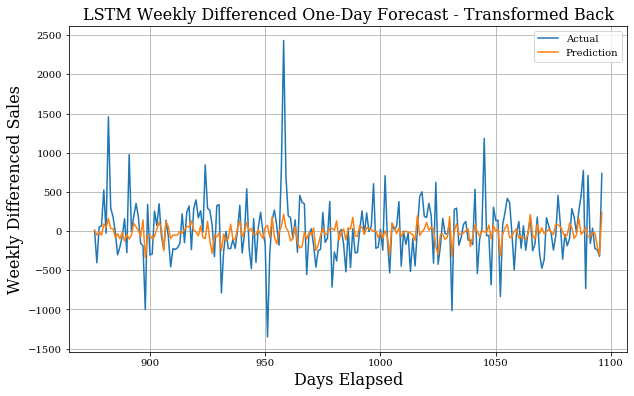

137884.11
255.89839


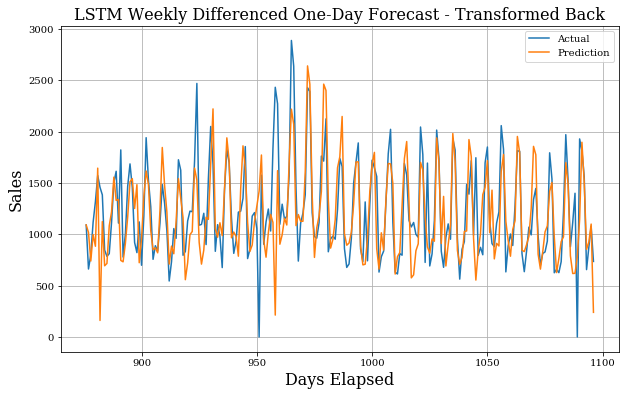

137884.12691730377
255.8983810398374


In [194]:
plt.figure(figsize=(10, 6))

plot_series(diff_time[-221:], y_test,label='Actual')
plot_series(diff_time[-221:], y_pred,label='Prediction')
plt.title("LSTM Weekly Differenced One-Day Forecast - Transformed Back",fontsize=16)
plt.xlabel("Days Elapsed", fontsize=16)
plt.ylabel("Weekly Differenced Sales", fontsize=16)
plt.legend(loc="best")
plt.savefig(fname='Charts/LSTMPredictonWeeklyDiff.png',dpi=150)
plt.show()

print(keras.metrics.mean_squared_error(y_test, y_pred.flatten()).numpy())
print(keras.metrics.mean_absolute_error(y_test, y_pred.flatten()).numpy())
#Adding predicted difference to get final results.
added_back = price_series[-228:-7] + y_pred.flatten()
y_true = price_series[-221:] 
plt.figure(figsize=(10, 6))

plot_series(diff_time[-221:], y_true,label='Actual')
plot_series(diff_time[-221:], added_back,label='Prediction')
plt.title("LSTM Weekly Differenced One-Day Forecast - Transformed Back",fontsize=16)
plt.xlabel("Days Elapsed", fontsize=16)
plt.ylabel("Sales", fontsize=16)
plt.legend(loc="upper right")
plt.savefig(fname='Charts/LSTMPredictonWeeklyDiffAB.png',dpi=150)
plt.show()

print(keras.metrics.mean_squared_error(y_true, added_back).numpy())
print(keras.metrics.mean_absolute_error(y_true, added_back).numpy())

<b> GRU Layers

In [195]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

feat_reduction = SelectKBest(f_regression, k=1) 
X_new = feat_reduction.fit_transform(X,y)
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=221, random_state=42, shuffle=False)

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    
    tf.keras.layers.GRU(32, return_sequences=True),
    keras.layers.Dropout(0.4),
    
    tf.keras.layers.GRU(32),
    keras.layers.Dropout(0.4),
    
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

es_callback = keras.callbacks.EarlyStopping(monitor='loss', patience=4)

optimizer = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
    optimizer=optimizer,
    metrics=["mae"])

history = model.fit(X_train, y_train, epochs=120, callbacks=[es_callback])

y_pred = model.predict(X_test)

Epoch 1/120
28/28 [==============================] - ETA: 0s - loss: 228.9008 - mae: 229.400 - ETA: 0s - loss: 236.2897 - mae: 236.789 - 0s 2ms/step - loss: 237.6685 - mae: 238.1680
Epoch 2/120
28/28 [==============================] - ETA: 0s - loss: 191.8604 - mae: 192.360 - ETA: 0s - loss: 230.1483 - mae: 230.647 - 0s 2ms/step - loss: 229.1895 - mae: 229.6887
Epoch 3/120
28/28 [==============================] - ETA: 0s - loss: 245.2606 - mae: 245.760 - ETA: 0s - loss: 223.3621 - mae: 223.862 - 0s 2ms/step - loss: 224.4463 - mae: 224.9458
Epoch 4/120
28/28 [==============================] - ETA: 0s - loss: 200.5383 - mae: 201.038 - ETA: 0s - loss: 231.1906 - mae: 231.690 - 0s 2ms/step - loss: 231.7889 - mae: 232.2882
Epoch 5/120
28/28 [==============================] - ETA: 0s - loss: 218.4943 - mae: 218.994 - ETA: 0s - loss: 226.9545 - mae: 227.454 - 0s 2ms/step - loss: 223.6396 - mae: 224.1396
Epoch 6/120
28/28 [==============================] - ETA: 0s - loss: 156.1642 - mae: 156.6

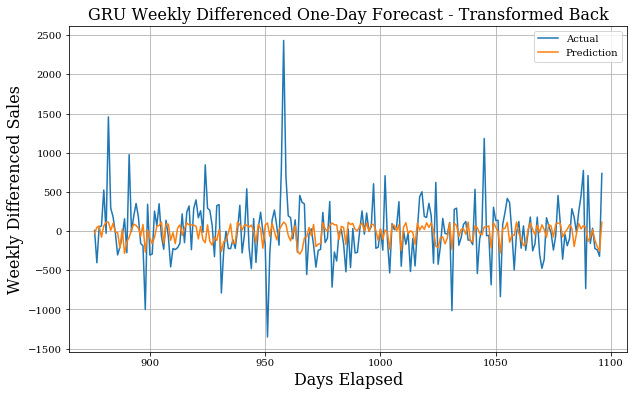

142817.89
259.69022


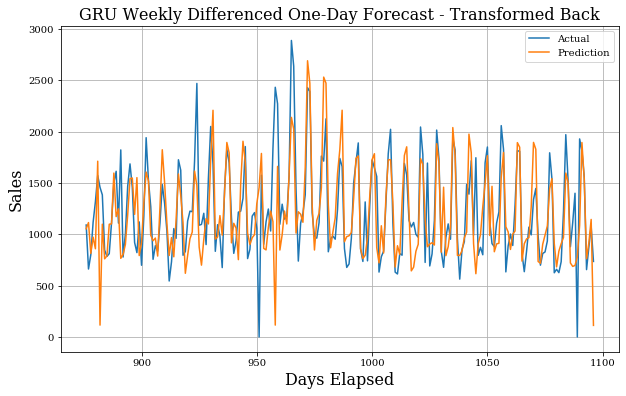

142817.8931162396
259.69023526663153


In [196]:
plt.figure(figsize=(10, 6))

plot_series(diff_time[-221:], y_test,label='Actual')
plot_series(diff_time[-221:], y_pred,label='Prediction')
plt.title("GRU Weekly Differenced One-Day Forecast - Transformed Back",fontsize=16)
plt.xlabel("Days Elapsed", fontsize=16)
plt.ylabel("Weekly Differenced Sales", fontsize=16)
plt.legend(loc="best")
plt.savefig(fname='Charts/GRUPredictonWeeklyDiff.png',dpi=150)
plt.show()

print(keras.metrics.mean_squared_error(y_test, y_pred.flatten()).numpy())
print(keras.metrics.mean_absolute_error(y_test, y_pred.flatten()).numpy())
#Adding predicted difference to get final results.
added_back = price_series[-228:-7] + y_pred.flatten()
y_true = price_series[-221:] 
plt.figure(figsize=(10, 6))

plot_series(diff_time[-221:], y_true,label='Actual')
plot_series(diff_time[-221:], added_back,label='Prediction')
plt.title("GRU Weekly Differenced One-Day Forecast - Transformed Back",fontsize=16)
plt.xlabel("Days Elapsed", fontsize=16)
plt.ylabel("Sales", fontsize=16)
plt.legend(loc="upper right")
plt.savefig(fname='Charts/GRUPredictonWeeklyDiffAB.png',dpi=150)
plt.show()

print(keras.metrics.mean_squared_error(y_true, added_back).numpy())
print(keras.metrics.mean_absolute_error(y_true, added_back).numpy())

<b> GRU layers supported with Dense and Conv

In [197]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

feat_reduction = SelectKBest(f_regression, k=5) 
X_new = feat_reduction.fit_transform(X,y)
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=221, random_state=42, shuffle=False)

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    
    tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
    keras.layers.Dropout(0.4),
    
    tf.keras.layers.GRU(32, return_sequences=True),
    keras.layers.Dropout(0.4),
    
    tf.keras.layers.GRU(32),
    keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(14),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

es_callback = keras.callbacks.EarlyStopping(monitor='loss', patience=10)

optimizer = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
    optimizer=optimizer,
    metrics=["mae"])
es_callback = keras.callbacks.EarlyStopping(monitor='loss', patience=12)
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
    optimizer=optimizer,
    metrics=["mae"])

history = model.fit(X_train, y_train, epochs=120, callbacks=[es_callback])

y_pred = model.predict(X_test)

Epoch 1/120
28/28 [==============================] - ETA: 0s - loss: 229.4297 - mae: 229.929 - ETA: 0s - loss: 239.5285 - mae: 240.028 - ETA: 0s - loss: 237.7719 - mae: 238.271 - 0s 5ms/step - loss: 236.6022 - mae: 237.1017
Epoch 2/120
28/28 [==============================] - ETA: 0s - loss: 212.9389 - mae: 213.438 - ETA: 0s - loss: 226.8547 - mae: 227.354 - ETA: 0s - loss: 243.2494 - mae: 243.749 - 0s 5ms/step - loss: 242.6609 - mae: 243.1607
Epoch 3/120
28/28 [==============================] - ETA: 0s - loss: 386.6784 - mae: 387.178 - ETA: 0s - loss: 266.5805 - mae: 267.079 - ETA: 0s - loss: 246.1063 - mae: 246.605 - 0s 5ms/step - loss: 248.3174 - mae: 248.8164
Epoch 4/120
28/28 [==============================] - ETA: 0s - loss: 227.2658 - mae: 227.765 - ETA: 0s - loss: 236.6910 - mae: 237.190 - ETA: 0s - loss: 230.2527 - mae: 230.751 - 0s 5ms/step - loss: 236.7845 - mae: 237.2832
Epoch 5/120
28/28 [==============================] - ETA: 0s - loss: 204.2771 - mae: 204.777 - ETA: 0s -

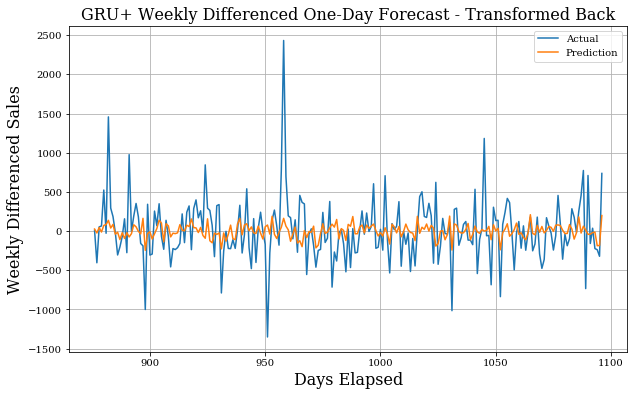

140196.16
260.15567


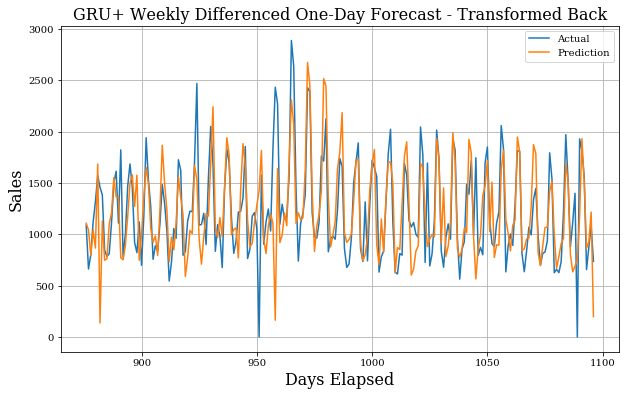

140196.16047416718
260.1556636228065


In [198]:
plt.figure(figsize=(10, 6))

plot_series(diff_time[-221:], y_test,label='Actual')
plot_series(diff_time[-221:], y_pred,label='Prediction')
plt.title("GRU+ Weekly Differenced One-Day Forecast - Transformed Back",fontsize=16)
plt.xlabel("Days Elapsed", fontsize=16)
plt.ylabel("Weekly Differenced Sales", fontsize=16)
plt.legend(loc="best")
plt.savefig(fname='Charts/GRUCONVredictonWeeklyDiff.png',dpi=150)
plt.show()

print(keras.metrics.mean_squared_error(y_test, y_pred.flatten()).numpy())
print(keras.metrics.mean_absolute_error(y_test, y_pred.flatten()).numpy())
#Adding predicted difference to get final results.
added_back = price_series[-228:-7] + y_pred.flatten()
y_true = price_series[-221:] 
plt.figure(figsize=(10, 6))

plot_series(diff_time[-221:], y_true,label='Actual')
plot_series(diff_time[-221:], added_back,label='Prediction')
plt.title("GRU+ Weekly Differenced One-Day Forecast - Transformed Back",fontsize=16)
plt.xlabel("Days Elapsed", fontsize=16)
plt.ylabel("Sales", fontsize=16)
plt.legend(loc="upper right")
plt.savefig(fname='Charts/GRUCONVPredictonWeeklyDiffAB.png',dpi=150)
plt.show()

print(keras.metrics.mean_squared_error(y_true, added_back).numpy())
print(keras.metrics.mean_absolute_error(y_true, added_back).numpy())

### Pytorch Transformer

#### Imports

In [287]:
import pytorch_lightning as pl
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss, MAE
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer

The Pytorch-Forecast library comes with great tools for generating time series datasets to use in training. As such, we generate out training data with these tools. Care is taken to ensure testing is completed as closely to the same manner as previous tests.

#### Predicting Actual

In [288]:
data = pd.read_csv('Data/RestaurantDataVets_All_2to5.csv')
data = data.drop(columns=['DMY','MissingPrevDays'])

remove=7
df = data.drop([x for x in range(remove)])
df = df.reset_index(drop=True)

#Objects need to be converted to float due to missing values at load time.
df["DailyAvg"] = df.DailyAvg.astype(float)
df["WeeklyAvg"] = df.WeeklyAvg.astype(float)
df["MinSales"] = df.MinSales.astype(float)
df["MaxSales"] = df.MaxSales.astype(float)
df["DailyBusyness"] = df.DailyBusyness.astype(float)
df["WeeklyBusyness"] = df.WeeklyBusyness.astype(float)

hotdata = onehotholiday(df)

numcols = len(hotdata.columns)
dataset = hotdata
dataset

Index  Group  Year  Day  January  February  March  April  May  June  \
0         8      0  2016   18        0         0      0      0    0     0   
1         9      0  2016   19        0         0      0      0    0     0   
2        10      0  2016   20        0         0      0      0    0     0   
3        11      0  2016   21        0         0      0      0    0     0   
4        12      0  2016   22        0         0      0      0    0     0   
...     ...    ...   ...  ...      ...       ...    ...    ...  ...   ...   
1099   1107      0  2019    1        0         0      0      0    0     0   
1100   1108      0  2019    2        0         0      0      0    0     0   
1101   1109      0  2019    3        0         0      0      0    0     0   
1102   1110      0  2019    4        0         0      0      0    0     0   
1103   1111      0  2019    5        0         0      0      0    0     0   

      July  August  September  October  November  December  Sunday  Monday  \
0        0       0          1        0         0         0       1       0   
1        0       0          1        0         0         0       0       1   
2        0       0          1        0         0         0       0       0   
3        0       0          1        0         0         0       0       0   
4        0       0          1        0         0         0       0       0   
...    ...     ...        ...      ...       ...       ...     ...     ...   
1099     0       0          0        0         0         1       1       0   
1100     0       0          0        0         0         1       0       1   
1101     0       0          0        0         0         1       0       0   
1102     0       0          0        0         0         1       0       0   
1103     0       0          0        0         0         1       0       0   

      Tuesday  Wednesday  Thursday  Friday  Saturday  Carnival  LentFasting  \
0           0          0         0       0         0         0            0   
1           0          0         0       0         0         0            0   
2           1          0         0       0         0         0            0   
3           0          1         0       0         0         0            0   
4           0          0         1       0         0         0            0   
...       ...        ...       ...     ...       ...       ...          ...   
1099        0          0         0       0         0         0            0   
1100        0          0         0       0         0         0            0   
1101        1          0         0       0         0         0            0   
1102        0          1         0       0         0         0            0   
1103        0          0         1       0         0         0            0   

      Ramadan  ChristmasSeason     DailyAvg    WeeklyAvg  MinSales  MaxSales  \
0           0                0   532.292857   666.450000    320.54    862.04   
1           0                0   583.623750   475.490000    320.54    942.94   
2           0                0   566.282222   320.540000    320.54    942.94   
3           0                0   547.490000   365.610000    320.54    942.94   
4           0                0   535.989091   494.990000    320.54    942.94   
...       ...              ...          ...          ...       ...       ...   
1099        0                1  1028.135054  1445.320629    225.30   2889.23   
1100        0                1  1028.614327   809.810440    225.30   2889.23   
1101        0                1  1028.278403   769.949295    225.30   2889.23   
1102        0                1  1028.140577   839.784810    225.30   2889.23   
1103        0                1  1028.186450   827.577342    225.30   2889.23   

      DailyBusyness  WeeklyBusyness   A0   A1   A2   A3   A4   A5   A6   A7  \
0          0.391049        0.638800  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1          0.422692        0.248956  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 

In [289]:
train_data = dataset[lambda x: x.Index < train_time]

val_data = train_data[-80:]
train_data=train_data[:-80]

test_data = dataset[lambda x: x.Index >= train_time-6]


train_index = np.arange(1,len(train_data)+1, dtype="int")
val_index = np.arange(1,len(val_data)+1, dtype="int")
test_index = np.arange(1,len(test_data)+1, dtype="int")

train_data.Index = train_index
test_data.Index = test_index
val_data.Index = val_index

# create the dataset from the pandas dataframe
training = TimeSeriesDataSet(
     dataset[lambda x: x.Index < train_time-84],
     time_idx="Index",
     target="2to5",
     group_ids=["Group"],
     min_encoder_length=14,  # allowing predictions without history
     max_encoder_length=14,
     min_prediction_length=1,
     max_prediction_length=1,
     static_categoricals=[],
     static_reals=[ ],
     time_varying_known_categoricals=[],
     
     time_varying_known_reals=["Index","Year", "Day","January","February","March","April","May","June","July","August",
                               "September","October","November","December", "Sunday","Monday","Tuesday","Wednesday",
                               "Thursday","Friday","Saturday","Carnival","LentFasting","Ramadan",
                               "ChristmasSeason","DailyAvg","WeeklyAvg","MinSales",
                               "MaxSales","DailyBusyness","WeeklyBusyness",
                               "A0","A1","A2", "A3","A4","A5","A6","A7","A8","A9",
                               "A10","A11","A12","A13","A14","A15","A16","A17",
                               "A18","A19","A20","A21","A22","A23","A24","A25","A26","A27"],
     time_varying_unknown_categoricals=[],
     time_varying_unknown_reals=["2to5"],
     
)

validating=TimeSeriesDataSet.from_dataset(training, val_data, stop_randomization=True)
testing=TimeSeriesDataSet.from_dataset(training, test_data, stop_randomization=True)

batch_size = 16

train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validating.to_dataloader(train=False, batch_size=batch_size, num_workers=0)
test_dataloader = testing.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

C:\Users\Austin\Anaconda3\lib\site-packages\pandas\core\generic.py:5489: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [290]:
train_data

Index  Group  Year  Day  January  February  March  April  May  June  \
0        1      0  2016   18        0         0      0      0    0     0   
1        2      0  2016   19        0         0      0      0    0     0   
2        3      0  2016   20        0         0      0      0    0     0   
3        4      0  2016   21        0         0      0      0    0     0   
4        5      0  2016   22        0         0      0      0    0     0   
..     ...    ...   ...  ...      ...       ...    ...    ...  ...   ...   
790    791      0  2019   19        1         0      0      0    0     0   
791    792      0  2019   20        1         0      0      0    0     0   
792    793      0  2019   21        1         0      0      0    0     0   
793    794      0  2019   22        1         0      0      0    0     0   
794    795      0  2019   23        1         0      0      0    0     0   

     July  August  September  October  November  December  Sunday  Monday  \
0       0       0          1        0         0         0       1       0   
1       0       0          1        0         0         0       0       1   
2       0       0          1        0         0         0       0       0   
3       0       0          1        0         0         0       0       0   
4       0       0          1        0         0         0       0       0   
..    ...     ...        ...      ...       ...       ...     ...     ...   
790     0       0          0        0         0         0       0       0   
791     0       0          0        0         0         0       1       0   
792     0       0          0        0         0         0       0       1   
793     0       0          0        0         0         0       0       0   
794     0       0          0        0         0         0       0       0   

     Tuesday  Wednesday  Thursday  Friday  Saturday  Carnival  LentFasting  \
0          0          0         0       0         0         0            0   
1          0          0         0       0         0         0            0   
2          1          0         0       0         0         0            0   
3          0          1         0       0         0         0            0   
4          0          0         1       0         0         0            0   
..       ...        ...       ...     ...       ...       ...          ...   
790        0          0         0       0         1         1            0   
791        0          0         0       0         0         1            0   
792        0          0         0       0         0         1            0   
793        1          0         0       0         0         1            0   
794        0          1         0       0         0         1            0   

     Ramadan  ChristmasSeason    DailyAvg    WeeklyAvg  MinSales  MaxSales  \
0          0                0  532.292857   666.450000    320.54    862.04   
1          0                0  583.623750   475.490000    320.54    942.94   
2          0                0  566.282222   320.540000    320.54    942.94   
3          0                0  547.490000   365.610000    320.54    942.94   
4          0                0  535.989091   494.990000    320.54    942.94   
..       ...              ...         ...          ...       ...       ...   
790        0                0  939.851568  1352.085575    225.30   2504.45   
791        0                0  940.991742  1311.127826    225.30   2504.45   
792        0                0  941.041364   726.366435    225.30   2504.45   
793        0                0  941.633725   712.365625    225.30   2504.45   
794        0                0  942.444582   782.885263    225.30   2504.45   

     DailyBusyness  WeeklyBusyness   A0   A1   A2   A3   A4   A5   A6   A7  \
0         0.391049        0.638800  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1         0.422692        0.248956  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2         0.394830        0.000000  1.0  0.0  0.0  0.0  0.0

In [291]:
val_data

Index  Group  Year  Day  January  February  March  April  May  June  \
795      1      0  2019   24        1         0      0      0    0     0   
796      2      0  2019   25        1         0      0      0    0     0   
797      3      0  2019   26        1         0      0      0    0     0   
798      4      0  2019   27        1         0      0      0    0     0   
799      5      0  2019   28        1         0      0      0    0     0   
..     ...    ...   ...  ...      ...       ...    ...    ...  ...   ...   
870     76      0  2019    9        0         0      0      1    0     0   
871     77      0  2019   10        0         0      0      1    0     0   
872     78      0  2019   11        0         0      0      1    0     0   
873     79      0  2019   12        0         0      0      1    0     0   
874     80      0  2019   13        0         0      0      1    0     0   

     July  August  September  October  November  December  Sunday  Monday  \
795     0       0          0        0         0         0       0       0   
796     0       0          0        0         0         0       0       0   
797     0       0          0        0         0         0       0       0   
798     0       0          0        0         0         0       1       0   
799     0       0          0        0         0         0       0       1   
..    ...     ...        ...      ...       ...       ...     ...     ...   
870     0       0          0        0         0         0       0       0   
871     0       0          0        0         0         0       0       0   
872     0       0          0        0         0         0       0       0   
873     0       0          0        0         0         0       0       0   
874     0       0          0        0         0         0       0       0   

     Tuesday  Wednesday  Thursday  Friday  Saturday  Carnival  LentFasting  \
795        0          0         1       0         0         1            0   
796        0          0         0       1         0         1            0   
797        0          0         0       0         1         1            0   
798        0          0         0       0         0         1            0   
799        0          0         0       0         0         1            0   
..       ...        ...       ...     ...       ...       ...          ...   
870        1          0         0       0         0         0            1   
871        0          1         0       0         0         0            1   
872        0          0         1       0         0         0            1   
873        0          0         0       1         0         0            1   
874        0          0         0       0         1         0            1   

     Ramadan  ChristmasSeason    DailyAvg    WeeklyAvg  MinSales  MaxSales  \
795        0                0  942.739426   773.175877     225.3   2504.45   
796        0                0  942.736252   919.195351     225.3   2504.45   
797        0                0  943.602973  1356.450702     225.3   2504.45   
798        0                0  945.096522  1308.278793     225.3   2504.45   
799        0                0  946.942990   732.302328     225.3   2504.45   
..       ...              ...         ...          ...       ...       ...   
870        0                0  977.826773   726.032114     225.3   2764.93   
871        0                0  978.041241   812.945840     225.3   2764.93   
872        0                0  977.967793   799.167440     225.3   2764.93   
873        0                0  977.846159   951.288240     225.3   2764.93   
874        0                0  977.827787  1410.857440     225.3   2764.93   

     DailyBusyness  WeeklyBusyness   A0   A1   A2   A3   A4   A5   A6   A7  \
795       0.314784        0.240386  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
796       0.314782        0.304454  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
797       0.315163        0.496304  1.0  0.0  0.0  0.0  0.0

In [292]:
test_data

Index  Group  Year  Day  January  February  March  April  May  June  \
869       1      0  2019    8        0         0      0      1    0     0   
870       2      0  2019    9        0         0      0      1    0     0   
871       3      0  2019   10        0         0      0      1    0     0   
872       4      0  2019   11        0         0      0      1    0     0   
873       5      0  2019   12        0         0      0      1    0     0   
...     ...    ...   ...  ...      ...       ...    ...    ...  ...   ...   
1099    231      0  2019    1        0         0      0      0    0     0   
1100    232      0  2019    2        0         0      0      0    0     0   
1101    233      0  2019    3        0         0      0      0    0     0   
1102    234      0  2019    4        0         0      0      0    0     0   
1103    235      0  2019    5        0         0      0      0    0     0   

      July  August  September  October  November  December  Sunday  Monday  \
869      0       0          0        0         0         0       0       1   
870      0       0          0        0         0         0       0       0   
871      0       0          0        0         0         0       0       0   
872      0       0          0        0         0         0       0       0   
873      0       0          0        0         0         0       0       0   
...    ...     ...        ...      ...       ...       ...     ...     ...   
1099     0       0          0        0         0         1       1       0   
1100     0       0          0        0         0         1       0       1   
1101     0       0          0        0         0         1       0       0   
1102     0       0          0        0         0         1       0       0   
1103     0       0          0        0         0         1       0       0   

      Tuesday  Wednesday  Thursday  Friday  Saturday  Carnival  LentFasting  \
869         0          0         0       0         0         0            1   
870         1          0         0       0         0         0            1   
871         0          1         0       0         0         0            1   
872         0          0         1       0         0         0            1   
873         0          0         0       1         0         0            1   
...       ...        ...       ...     ...       ...       ...          ...   
1099        0          0         0       0         0         0            0   
1100        0          0         0       0         0         0            0   
1101        1          0         0       0         0         0            0   
1102        0          1         0       0         0         0            0   
1103        0          0         1       0         0         0            0   

      Ramadan  ChristmasSeason     DailyAvg    WeeklyAvg  MinSales  MaxSales  \
869         0                0   977.804224   758.872619     225.3   2764.93   
870         0                0   977.826773   726.032114     225.3   2764.93   
871         0                0   978.041241   812.945840     225.3   2764.93   
872         0                0   977.967793   799.167440     225.3   2764.93   
873         0                0   977.846159   951.288240     225.3   2764.93   
...       ...              ...          ...          ...       ...       ...   
1099        0                1  1028.135054  1445.320629     225.3   2889.23   
1100        0                1  1028.614327   809.810440     225.3   2889.23   
1101        0                1  1028.278403   769.949295     225.3   2889.23   
1102        0                1  1028.140577   839.784810     225.3   2889.23   
1103        0                1  1028.186450   827.577342     225.3   2889.23   

      DailyBusyness  WeeklyBusyness   A0   A1   A2   A3   A4   A5   A6   A7  \
869        0.296305        0.210099  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
870        0.296314        0.197167  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 

Let us ensure our data has been partitioned properly.

In [293]:
print("We batch our data into sizes of "+str(batch_size))
print("In our training dataset, we remove 10% for validation. Additional loss is needed to create a lookback window.")
print("In total, we train with " +str(batch_size*len(train_dataloader))+ " days.")
print("The 10% validation provides us with "+str(batch_size*len(val_dataloader))+" days.")
print("We test after fitting with "+str(batch_size*len(test_dataloader))+" days.")
print("In total, we have "+str(16*(len(train_dataloader) + len(val_dataloader) + len(test_dataloader)))+ " days.")

We batch our data into sizes of 16
In our training dataset, we remove 10% for validation. Additional loss is needed to create a lookback window.
In total, we train with 768 days.
The 10% validation provides us with 80 days.
We test after fitting with 224 days.
In total, we have 1072 days.


<b> Temporal Fusion Transformer 

In [294]:
##Callbacks 
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=15, verbose=False, mode="min")


##Trainer wrapper for training parameters
trainer = pl.Trainer( callbacks=[early_stop_callback], 
                     max_epochs=400,
                     gradient_clip_val=0.5295054390944878)

#Model initialization
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.09782840988888085,
    hidden_size=93,
    attention_head_size=1,
    dropout= 0.16187745369173084,
    hidden_continuous_size=16,
    output_size=7,
    loss=QuantileLoss(),
    log_interval=2,
    reduce_on_plateau_patience=4
)

print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

trainer.fit(tft, train_dataloader=train_dataloader, val_dataloaders=val_dataloader)

GPU available: True, used: False
TPU available: None, using: 0 TPU cores
C:\Users\Austin\Anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:49: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Number of parameters in network: 1106.1k



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 2.0 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 333 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 326 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 35.2 K
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 35.2 K
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 35.2

1

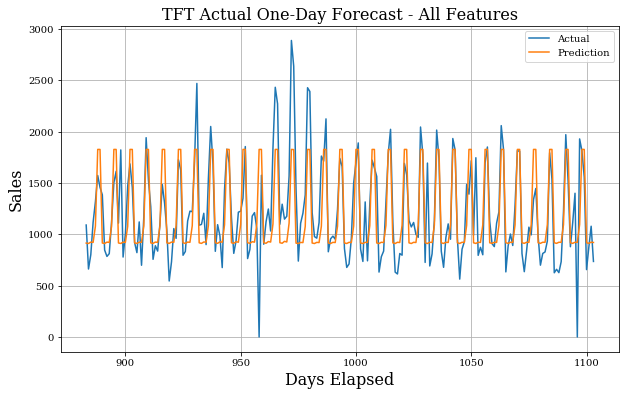

95912.38
222.13773


In [295]:
actuals = torch.cat([y[0] for x, y in iter(test_dataloader)])
predictions = tft.predict(test_dataloader)

actuals = actuals.numpy()
predictions = predictions.numpy()
time_series = time[train_time:]

plt.figure(figsize=(10, 6))

plot_series(time_series, actuals.flatten(),label='Actual')
plot_series(time_series, predictions.flatten(),label='Prediction')

plt.title("TFT Actual One-Day Forecast - All Features",fontsize=16)
plt.xlabel("Days Elapsed", fontsize=16)
plt.ylabel("Sales", fontsize=16)
plt.legend(loc="best")
plt.savefig(fname='Charts/TransformerPredictonActual.png',dpi=150)
plt.show()

print(keras.metrics.mean_squared_error(actuals.flatten(), predictions.flatten()).numpy())
print(keras.metrics.mean_absolute_error(actuals.flatten(),predictions.flatten()).numpy())

In [296]:
actuals = torch.cat([y[0] for x, y in iter(test_dataloader)])

<b> Predicting Actual - Less Features

In [297]:
data = pd.read_csv('Data/RestaurantDataVets_All_2to5.csv')
data = data.drop(columns=['DMY','MissingPrevDays'])

remove=7
df = data.drop([x for x in range(remove)])
df = df.reset_index(drop=True)

#Objects need to be converted to float due to missing values at load time.
df["DailyAvg"] = df.DailyAvg.astype(float)
df["WeeklyAvg"] = df.WeeklyAvg.astype(float)
df["MinSales"] = df.MinSales.astype(float)
df["MaxSales"] = df.MaxSales.astype(float)
df["DailyBusyness"] = df.DailyBusyness.astype(float)
df["WeeklyBusyness"] = df.WeeklyBusyness.astype(float)

hotdata = onehotholiday(df)

numcols = len(hotdata.columns)
dataset = hotdata
dataset

numcols = len(hotdata.columns)
X=hotdata.iloc[:, 0:numcols-1]
y=hotdata.iloc[:, numcols-1]

X_new = SelectKBest(f_regression, k='all').fit(X,y)

dfscores = pd.DataFrame(X_new.scores_)
dfcolumns = pd.DataFrame(X.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(60,'Score'))  #print 10 best features
featureScores.to_csv('actualfeatscores.csv')

C:\Users\Austin\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


              Specs        Score
28        WeeklyAvg  1500.731120
30         MaxSales   311.795792
2              Year   285.344359
32   WeeklyBusyness   277.771456
29         MinSales   258.164774
27         DailyAvg   258.018434
0             Index   257.043505
22         Saturday   207.091595
16           Sunday   169.579736
31    DailyBusyness   166.830205
18          Tuesday    56.879305
17           Monday    41.929382
20         Thursday    34.821244
19        Wednesday    29.642404
56              A23    19.493078
44              A11    14.542047
59              A26    14.542047
37               A4     9.753883
34               A1     9.643405
39               A6     9.643405
13          October     7.010144
33               A0     4.990336
49              A16     4.542011
60              A27     4.101715
47              A14     3.448309
6             March     3.387271
57              A24     3.296638
43              A10     3.199677
14         November     3.158984
41        

In [298]:
train_data = dataset[lambda x: x.Index < train_time]

val_data = train_data[-84:]
train_data=train_data[:-84]

test_data = dataset[lambda x: x.Index >= train_time-6]


train_index = np.arange(1,len(train_data)+1, dtype="int")
val_index = np.arange(1,len(val_data)+1, dtype="int")
test_index = np.arange(1,len(test_data)+1, dtype="int")

train_data.Index = train_index
test_data.Index = test_index
val_data.Index = val_index

# create the dataset from the pandas dataframe
training = TimeSeriesDataSet(
     dataset[lambda x: x.Index < train_time-84],
     time_idx="Index",
     target="2to5",
     group_ids=["Group"],
     min_encoder_length=14,  # allowing predictions without history
     max_encoder_length=14,
     min_prediction_length=1,
     max_prediction_length=1,
     static_categoricals=[],
     static_reals=[ ],
     time_varying_known_categoricals=[],
     
     time_varying_known_reals=["Index","WeeklyAvg","DailyBusyness","WeeklyBusyness","MaxSales",
                              "Year","MinSales","DailyAvg", "Monday", "Tuesday",
                              "Wednesday","Thursday","Saturday","Sunday","A23","A11","A26"],
     time_varying_unknown_categoricals=[],
     time_varying_unknown_reals=["2to5"],
     
)

validating=TimeSeriesDataSet.from_dataset(training, val_data, stop_randomization=True)
testing=TimeSeriesDataSet.from_dataset(training, test_data, stop_randomization=True)

batch_size = 16

train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validating.to_dataloader(train=False, batch_size=batch_size, num_workers=0)
test_dataloader = testing.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

print("We batch our data into sizes of "+str(batch_size))
print("In our training dataset, we remove 10% for validation. Additional loss is needed to create a lookback window.")
print("In total, we train with " +str(batch_size*len(train_dataloader))+ " days.")
print("The 10% validation provides us with "+str(batch_size*len(val_dataloader))+" days.")
print("We test after fitting with "+str(batch_size*len(test_dataloader))+" days.")
print("In total, we have "+str(16*(len(train_dataloader) + len(val_dataloader) + len(test_dataloader)))+ " days.")

C:\Users\Austin\Anaconda3\lib\site-packages\pandas\core\generic.py:5489: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


We batch our data into sizes of 16
In our training dataset, we remove 10% for validation. Additional loss is needed to create a lookback window.
In total, we train with 768 days.
The 10% validation provides us with 80 days.
We test after fitting with 224 days.
In total, we have 1072 days.


In [299]:
##Callbacks 
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=15, verbose=False, mode="min")


##Trainer wrapper for training parameters
trainer = pl.Trainer( callbacks=[early_stop_callback], 
                     max_epochs=400,
                     gradient_clip_val=0.19370255729809424)

#Model initialization
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.09972456878766851,
    hidden_size=123,
    attention_head_size=3,
    dropout= 0.10560565992889985,
    hidden_continuous_size=122,
    output_size=7,
    loss=QuantileLoss(),
    log_interval=2,
    reduce_on_plateau_patience=4
)

print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

trainer.fit(tft, train_dataloader=train_dataloader, val_dataloaders=val_dataloader)

GPU available: True, used: False
TPU available: None, using: 0 TPU cores
C:\Users\Austin\Anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:49: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Number of parameters in network: 2977.0k



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 4.4 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.1 M 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.1 M 
7  | static_context_variable_selection  | GatedResidualNetwork            | 61.3 K
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 61.3 K
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 61.3

1

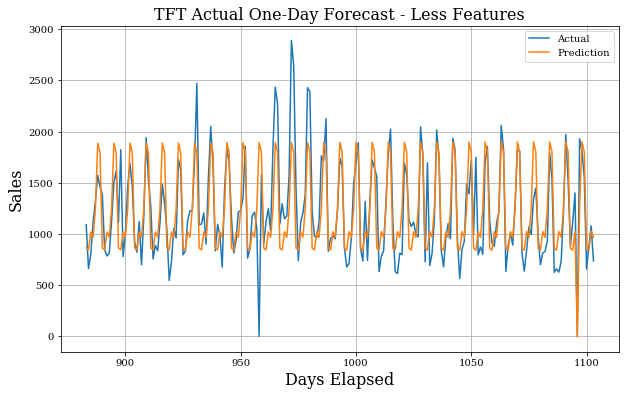

91872.86
215.53679


In [300]:
actuals = torch.cat([y[0] for x, y in iter(test_dataloader)])
predictions = tft.predict(test_dataloader)

actuals = actuals.numpy()
predictions = predictions.numpy()
time_series = time[train_time:]
plt.figure(figsize=(10, 6))
plot_series(time_series, actuals.flatten(),label='Actual')
plot_series(time_series, predictions.flatten(),label='Prediction')


plt.title("TFT Actual One-Day Forecast - Less Features",fontsize=16)
plt.xlabel("Days Elapsed", fontsize=16)
plt.ylabel("Sales", fontsize=16)
plt.legend(loc="best")
plt.savefig(fname='Charts/TransformerPredictonActualLessFeat.png',dpi=150)
plt.show()

print(keras.metrics.mean_squared_error(actuals.flatten(), predictions.flatten()).numpy())
print(keras.metrics.mean_absolute_error(actuals.flatten(),predictions.flatten()).numpy())

#### Predicting Difference

<b> Daily Difference

In [301]:
dataframe = pd.read_csv('Data/RestaurantDataVets_All_2to5_Differenced.csv')
data = dataframe.drop(columns=['DMY','MissingPrevDays','WeeklyDifference','DiffDifference','2to5'])

remove=14
df = data.drop([x for x in range(remove)])
df = df.reset_index(drop=True)

#Objects need to be converted to float due to missing values at load time.
df["DailyAvg"] = df.DailyAvg.astype(float)
df["WeeklyAvg"] = df.WeeklyAvg.astype(float)
df["MinSales"] = df.MinSales.astype(float)
df["MaxSales"] = df.MaxSales.astype(float)
df["DailyBusyness"] = df.DailyBusyness.astype(float)
df["WeeklyBusyness"] = df.WeeklyBusyness.astype(float)

df["AvgDailyDiff"] = df.AvgDailyDiff.astype(float)
df["AvgWeeklyDiff"] = df.AvgWeeklyDiff.astype(float)
df["MaxDailyDiff"] = df.MaxDailyDiff.astype(float)
df["MinDailyDiff"] = df.MinDailyDiff.astype(float)
df["DailyDifference"] = df.DailyDifference.astype(float)
#df["WeeklyDifference"] = df.WeeklyDifference.astype(float)

hotdata = onehotholidaydiff(df,'DailyDifference')

numcols = len(hotdata.columns)
dataset = hotdata
dataset

Index  Group  Year  Day  January  February  March  April  May  June  \
0        15      0  2016   25        0         0      0      0    0     0   
1        16      0  2016   26        0         0      0      0    0     0   
2        17      0  2016   27        0         0      0      0    0     0   
3        18      0  2016   28        0         0      0      0    0     0   
4        19      0  2016   29        0         0      0      0    0     0   
...     ...    ...   ...  ...      ...       ...    ...    ...  ...   ...   
1092   1107      0  2019    1        0         0      0      0    0     0   
1093   1108      0  2019    2        0         0      0      0    0     0   
1094   1109      0  2019    3        0         0      0      0    0     0   
1095   1110      0  2019    4        0         0      0      0    0     0   
1096   1111      0  2019    5        0         0      0      0    0     0   

      July  August  September  October  November  December  Sunday  Monday  \
0        0       0          1        0         0         0       1       0   
1        0       0          1        0         0         0       0       1   
2        0       0          1        0         0         0       0       0   
3        0       0          1        0         0         0       0       0   
4        0       0          1        0         0         0       0       0   
...    ...     ...        ...      ...       ...       ...     ...     ...   
1092     0       0          0        0         0         1       1       0   
1093     0       0          0        0         0         1       0       1   
1094     0       0          0        0         0         1       0       0   
1095     0       0          0        0         0         1       0       0   
1096     0       0          0        0         0         1       0       0   

      Tuesday  Wednesday  Thursday  Friday  Saturday  Carnival  LentFasting  \
0           0          0         0       0         0         0            0   
1           0          0         0       0         0         0            0   
2           1          0         0       0         0         0            0   
3           0          1         0       0         0         0            0   
4           0          0         1       0         0         0            0   
...       ...        ...       ...     ...       ...       ...          ...   
1092        0          0         0       0         0         0            0   
1093        0          0         0       0         0         0            0   
1094        1          0         0       0         0         0            0   
1095        0          1         0       0         0         0            0   
1096        0          0         1       0         0         0            0   

      Ramadan  ChristmasSeason    DailyAvg   WeeklyAvg  MinSales  MaxSales  \
0           0                0   559.68143   804.69500    320.54    942.94   
1           0                0   581.33600   451.52000    320.54    942.94   
2           0                0   569.84563   349.45000    320.54    942.94   
3           0                0   565.71176   393.29500    320.54    942.94   
4           0                0   558.37000   518.07500    320.54    942.94   
...       ...              ...         ...         ...       ...       ...   
1092        0                1  1028.13505  1445.32063    225.30   2889.23   
1093        0                1  1028.61433   809.81044    225.30   2889.23   
1094        0                1  1028.27840   769.94929    225.30   2889.23   
1095        0                1  1028.14058   839.78481    225.30   2889.23   
1096        0                1  1028.18645   827.57734    225.30   2889.23   

      DailyBusyness  WeeklyBusyness  AvgDailyDiff  AvgWeeklyDiff  \
0           0.38422         0.77788      12.13538     276.490000   
1           0.41902         0.21044      15.57500     -47.940000   
2           0.40056         0.04645     -17.93067     

In [302]:
train_data = dataset[lambda x: x.Index < train_time]

val_data = train_data[-80:]
train_data=train_data[:-80]

test_data = dataset[lambda x: x.Index >= train_time-6]


train_index = np.arange(1,len(train_data)+1, dtype="int")
val_index = np.arange(1,len(val_data)+1, dtype="int")
test_index = np.arange(1,len(test_data)+1, dtype="int")

train_data.Index = train_index
test_data.Index = test_index
val_data.Index = val_index


# create the dataset from the pandas dataframe
training = TimeSeriesDataSet(
     dataset[lambda x: x.Index < train_time-80],
     time_idx="Index",
     target="DailyDifference",
     group_ids=["Group"],
     min_encoder_length=14,  # allowing predictions without history
     max_encoder_length=14,
     min_prediction_length=1,
     max_prediction_length=1,
     static_categoricals=[],
     static_reals=[ ],
     time_varying_known_categoricals=[],
     
     time_varying_known_reals=["Index","Year", "Day","January","February","March","April","May","June","July","August",
                               "September","October","November","December", "Sunday","Monday","Tuesday","Wednesday",
                               "Thursday","Friday","Saturday","Carnival","LentFasting","Ramadan",
                               "ChristmasSeason","DailyAvg","WeeklyAvg","MinSales",
                               "MaxSales","DailyBusyness","WeeklyBusyness",
                               "AvgDailyDiff","AvgWeeklyDiff","MaxDailyDiff","MinDailyDiff",
                               "A0","A1","A2", "A3","A4","A5","A6","A7","A8","A9",
                               "A10","A11","A12","A13","A14","A15","A16","A17",
                               "A18","A19","A20","A21","A22","A23","A24","A25","A26","A27"],
     time_varying_unknown_categoricals=[],
     time_varying_unknown_reals=["DailyDifference"],
     
 )

validating=TimeSeriesDataSet.from_dataset(training, val_data, stop_randomization=True)
testing=TimeSeriesDataSet.from_dataset(training, test_data, stop_randomization=True)

batch_size = 16

train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validating.to_dataloader(train=False, batch_size=batch_size, num_workers=0)
test_dataloader = testing.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

print("We batch our data into sizes of "+str(batch_size))
print("In our training dataset, we remove 10% for validation. Additional loss is needed to create a lookback window.")
print("In total, we train with " +str(batch_size*len(train_dataloader))+ " days.")
print("The 10% validation provides us with "+str(batch_size*len(val_dataloader))+" days.")
print("We test after fitting with "+str(batch_size*len(test_dataloader))+" days.")
print("In total, we have "+str(batch_size*(len(train_dataloader) + len(val_dataloader) + len(test_dataloader)))+ " days.")

C:\Users\Austin\Anaconda3\lib\site-packages\pandas\core\generic.py:5489: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


We batch our data into sizes of 16
In our training dataset, we remove 10% for validation. Additional loss is needed to create a lookback window.
In total, we train with 768 days.
The 10% validation provides us with 80 days.
We test after fitting with 224 days.
In total, we have 1072 days.


In [303]:
##Callbacks 
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=15, verbose=False, mode="min")


##Trainer wrapper for training parameters
trainer = pl.Trainer( callbacks=[early_stop_callback], 
                     max_epochs=400,
                     gradient_clip_val=0.04477614616033392)

#Model initialization
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.08422656775097852,
    hidden_size=101,
    attention_head_size=1,
    dropout= 0.14518293024270285,
    hidden_continuous_size=46,
    output_size=7,
    loss=QuantileLoss(),
    log_interval=2,
    reduce_on_plateau_patience=4
)

print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

trainer.fit(tft, train_dataloader=train_dataloader, val_dataloaders=val_dataloader)

GPU available: True, used: False
TPU available: None, using: 0 TPU cores
C:\Users\Austin\Anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:49: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Number of parameters in network: 2803.3k



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 6.0 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.2 M 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.1 M 
7  | static_context_variable_selection  | GatedResidualNetwork            | 41.4 K
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 41.4 K
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 41.4

1

167280.67
321.86276


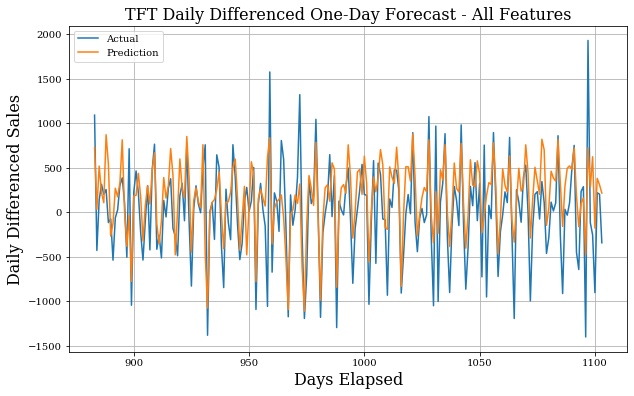

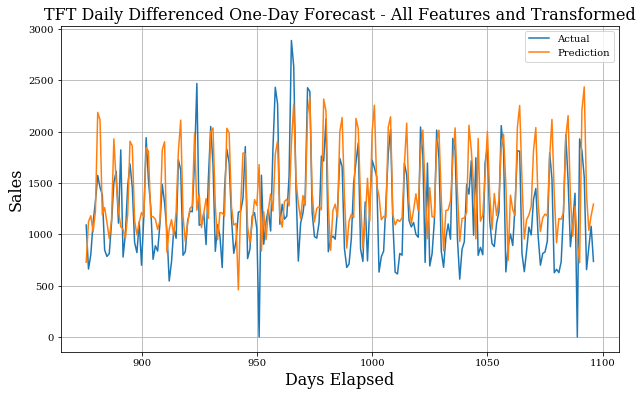

167280.66191886115
321.8627573389166


In [304]:
actuals = torch.cat([y[0] for x, y in iter(test_dataloader)])
predictions = tft.predict(test_dataloader)

actuals = actuals.numpy()
predictions = predictions.numpy()
time_series = time[train_time:]
plt.figure(figsize=(10, 6))

plot_series(time_series, actuals.flatten(),label='Actual')
plot_series(time_series, predictions.flatten(),label='Prediction')
plt.title("TFT Daily Differenced One-Day Forecast - All Features",fontsize=16)
plt.xlabel("Days Elapsed", fontsize=16)
plt.ylabel("Daily Differenced Sales", fontsize=16)
plt.legend(loc="best")
plt.savefig(fname='Charts/TransformerPredictonDailyDiff.png',dpi=150)

print(keras.metrics.mean_squared_error(actuals.flatten(), predictions.flatten()).numpy())
print(keras.metrics.mean_absolute_error(actuals.flatten(),predictions.flatten()).numpy())

#Adding predicted difference to get final results.
added_back = price_series[-222:-1] + predictions.flatten()
y_true = price_series[-221:] 
plt.figure(figsize=(10, 6))
plot_series(diff_time[-221:], y_true,label='Actual')
plot_series(diff_time[-221:], added_back,label='Prediction')
plt.title("TFT Daily Differenced One-Day Forecast - All Features and Transformed",fontsize=16)
plt.xlabel("Days Elapsed", fontsize=16)
plt.ylabel("Sales", fontsize=16)
plt.legend(loc="best")
plt.savefig(fname='Charts/TransformerPredictonDailyDiffAB.png',dpi=150)
plt.show()

print(keras.metrics.mean_squared_error(y_true, added_back).numpy())
print(keras.metrics.mean_absolute_error(y_true, added_back).numpy())

<b> Daily Difference - Less Features

In [305]:
data = pd.read_csv('Data/RestaurantDataVets_All_2to5_Differenced.csv')
data = data.drop(columns=['DMY','MissingPrevDays','2to5','WeeklyDifference','DiffDifference'])

remove=14
df = data.drop([x for x in range(remove)])
df = df.reset_index(drop=True)

#Objects need to be converted to float due to missing values at load time.
df["DailyAvg"] = df.DailyAvg.astype(float)
df["WeeklyAvg"] = df.WeeklyAvg.astype(float)
df["MinSales"] = df.MinSales.astype(float)
df["MaxSales"] = df.MaxSales.astype(float)
df["DailyBusyness"] = df.DailyBusyness.astype(float)
df["WeeklyBusyness"] = df.WeeklyBusyness.astype(float)


df["AvgDailyDiff"] = df.AvgDailyDiff.astype(float)
df["AvgWeeklyDiff"] = df.AvgWeeklyDiff.astype(float)
df["MaxDailyDiff"] = df.MaxDailyDiff.astype(float)
df["MinDailyDiff"] = df.MinDailyDiff.astype(float)
df["DailyDifference"] = df.DailyDifference.astype(float)
hotdata = onehotholidaydiff(df,'DailyDifference')

numcols = len(hotdata.columns)
dataset = hotdata
dataset

numcols = len(hotdata.columns)
X=hotdata.iloc[:, 0:numcols-1]
y=hotdata.iloc[:, numcols-1]

X_new = SelectKBest(f_regression, k=55).fit(X,y)

dfscores = pd.DataFrame(X_new.scores_)
dfcolumns = pd.DataFrame(X.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(60,'Score'))  #print 10 best features
featureScores.to_csv('dailydifffeatscores.csv')

C:\Users\Austin\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


              Specs       Score
17           Monday  432.655965
22         Saturday  198.666326
32   WeeklyBusyness  104.515124
28        WeeklyAvg  102.531345
33     AvgDailyDiff   89.744144
21           Friday   26.227024
48              A11   22.434007
60              A23   13.126514
37               A0   12.797335
34    AvgWeeklyDiff    9.755608
43               A6    8.050688
44               A7    6.731783
61              A24    6.572209
64              A27    6.399512
19        Wednesday    4.874038
56              A19    4.384009
38               A1    3.688036
40               A3    3.527297
63              A26    2.820926
46               A9    2.335293
45               A8    1.684062
41               A4    1.645293
18          Tuesday    1.409225
54              A17    1.271445
47              A10    0.855853
62              A25    0.831714
16           Sunday    0.827064
26  ChristmasSeason    0.791582
24      LentFasting    0.513328
53              A16    0.379622
6       

In [306]:
train_data = dataset[lambda x: x.Index < train_time]

val_data = train_data[-80:]
train_data=train_data[:-80]

test_data = dataset[lambda x: x.Index >= train_time-6]


train_index = np.arange(1,len(train_data)+1, dtype="int")
val_index = np.arange(1,len(val_data)+1, dtype="int")
test_index = np.arange(1,len(test_data)+1, dtype="int")

train_data.Index = train_index
test_data.Index = test_index
val_data.Index = val_index


# create the dataset from the pandas dataframe
training = TimeSeriesDataSet(
     dataset[lambda x: x.Index < train_time-80],
     time_idx="Index",
     target="DailyDifference",
     group_ids=["Group"],
     min_encoder_length=14,  # allowing predictions without history
     max_encoder_length=14,
     min_prediction_length=1,
     max_prediction_length=1,
     static_categoricals=[],
     static_reals=[ ],
     time_varying_known_categoricals=[],
     
     time_varying_known_reals=["Monday","Saturday","WeeklyBusyness","WeeklyAvg","AvgDailyDiff",
                              "AvgWeeklyDiff","Friday","A11","A23","A0","A24","A7","A27"],
     time_varying_unknown_categoricals=[],
     time_varying_unknown_reals=["DailyDifference"],
     
 )

validating=TimeSeriesDataSet.from_dataset(training, val_data, stop_randomization=True)
testing=TimeSeriesDataSet.from_dataset(training, test_data, stop_randomization=True)

batch_size = 16

train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validating.to_dataloader(train=False, batch_size=batch_size, num_workers=0)
test_dataloader = testing.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

print("We batch our data into sizes of "+str(batch_size))
print("In our training dataset, we remove 10% for validation. Additional loss is needed to create a lookback window.")
print("In total, we train with " +str(batch_size*len(train_dataloader))+ " days.")
print("The 10% validation provides us with "+str(batch_size*len(val_dataloader))+" days.")
print("We test after fitting with "+str(batch_size*len(test_dataloader))+" days.")
print("In total, we have "+str(16*(len(train_dataloader) + len(val_dataloader) + len(test_dataloader)))+ " days.")

C:\Users\Austin\Anaconda3\lib\site-packages\pandas\core\generic.py:5489: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


We batch our data into sizes of 16
In our training dataset, we remove 10% for validation. Additional loss is needed to create a lookback window.
In total, we train with 768 days.
The 10% validation provides us with 80 days.
We test after fitting with 224 days.
In total, we have 1072 days.


In [307]:
##Callbacks 
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=15, verbose=False, mode="min")


##Trainer wrapper for training parameters
trainer = pl.Trainer( callbacks=[early_stop_callback], 
                     max_epochs=400,
                     gradient_clip_val=0.792780041654202)

#Model initialization
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.09802329455644555,
    hidden_size=116,
    attention_head_size=2,
    dropout= 0.14518293024270285,
    hidden_continuous_size=109,
    output_size=7,
    loss=QuantileLoss(),
    log_interval=2,
    reduce_on_plateau_patience=4
)

print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

trainer.fit(tft, train_dataloader=train_dataloader, val_dataloaders=val_dataloader)

GPU available: True, used: False
TPU available: None, using: 0 TPU cores
C:\Users\Austin\Anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:49: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Number of parameters in network: 2080.8k



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 3.1 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 727 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 674 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 54.5 K
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 54.5 K
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 54.5

1

140747.6
272.79266


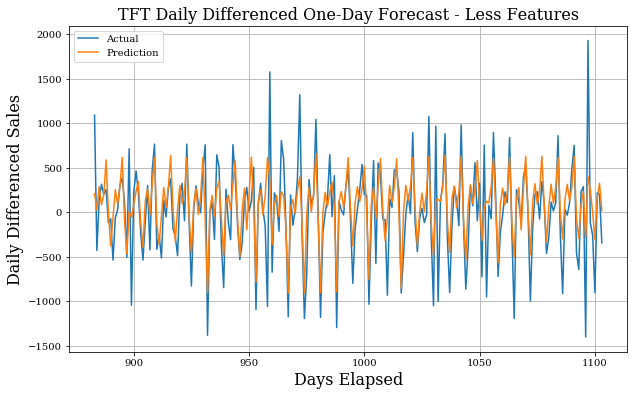

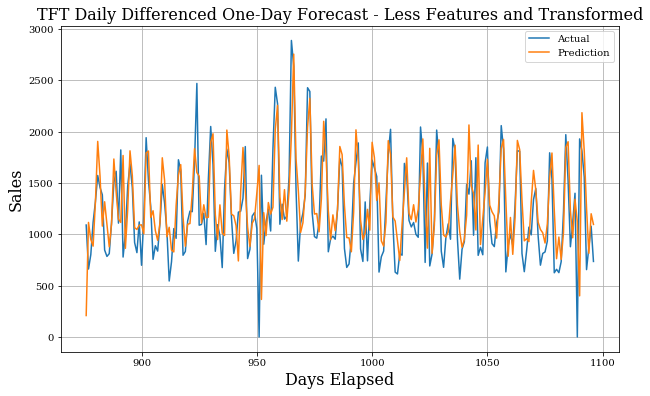

140747.582959819
272.7926668120213


In [308]:
actuals = torch.cat([y[0] for x, y in iter(test_dataloader)])
predictions = tft.predict(test_dataloader)

actuals = actuals.numpy()
predictions = predictions.numpy()
time_series = time[train_time:]
plt.figure(figsize=(10, 6))

plot_series(time_series, actuals.flatten(),label='Actual')
plot_series(time_series, predictions.flatten(),label='Prediction')
plt.title("TFT Daily Differenced One-Day Forecast - Less Features",fontsize=16)
plt.xlabel("Days Elapsed", fontsize=16)
plt.ylabel("Daily Differenced Sales", fontsize=16)
plt.legend(loc="best")
plt.savefig(fname='Charts/TransformerPredictonDailyDiffLessFeats.png',dpi=150)

print(keras.metrics.mean_squared_error(actuals.flatten(), predictions.flatten()).numpy())
print(keras.metrics.mean_absolute_error(actuals.flatten(),predictions.flatten()).numpy())

#Adding predicted difference to get final results.
added_back = price_series[-222:-1] + predictions.flatten()
y_true = price_series[-221:] 
plt.figure(figsize=(10, 6))
plot_series(diff_time[-221:], y_true,label='Actual')
plot_series(diff_time[-221:], added_back,label='Prediction')
plt.title("TFT Daily Differenced One-Day Forecast - Less Features and Transformed",fontsize=16)
plt.xlabel("Days Elapsed", fontsize=16)
plt.ylabel("Sales", fontsize=16)
plt.legend(loc="best")
plt.savefig(fname='Charts/TransformerPredictonDailyDiffLessFeatsAB.png',dpi=150)
plt.show()

print(keras.metrics.mean_squared_error(y_true, added_back).numpy())
print(keras.metrics.mean_absolute_error(y_true, added_back).numpy())

<b> Weekly Difference

In [309]:
dataframe = pd.read_csv('Data/RestaurantDataVets_All_2to5_Differenced.csv')
data = dataframe.drop(columns=['DMY','MissingPrevDays','DailyDifference','DiffDifference','2to5'])

remove=14
df = data.drop([x for x in range(remove)])
df = df.reset_index(drop=True)

#Objects need to be converted to float due to missing values at load time.
df["DailyAvg"] = df.DailyAvg.astype(float)
df["WeeklyAvg"] = df.WeeklyAvg.astype(float)
df["MinSales"] = df.MinSales.astype(float)
df["MaxSales"] = df.MaxSales.astype(float)
df["DailyBusyness"] = df.DailyBusyness.astype(float)
df["WeeklyBusyness"] = df.WeeklyBusyness.astype(float)

df["AvgDailyDiff"] = df.AvgDailyDiff.astype(float)
df["AvgWeeklyDiff"] = df.AvgWeeklyDiff.astype(float)
df["MaxDailyDiff"] = df.MaxDailyDiff.astype(float)
df["MinDailyDiff"] = df.MinDailyDiff.astype(float)
#df["DailyDifference"] = df.DailyDifference.astype(float)
df["WeeklyDifference"] = df.WeeklyDifference.astype(float)

hotdata = onehotholidaydiff(df,'WeeklyDifference')

numcols = len(hotdata.columns)
dataset = hotdata
dataset

Index  Group  Year  Day  January  February  March  April  May  June  \
0        15      0  2016   25        0         0      0      0    0     0   
1        16      0  2016   26        0         0      0      0    0     0   
2        17      0  2016   27        0         0      0      0    0     0   
3        18      0  2016   28        0         0      0      0    0     0   
4        19      0  2016   29        0         0      0      0    0     0   
...     ...    ...   ...  ...      ...       ...    ...    ...  ...   ...   
1092   1107      0  2019    1        0         0      0      0    0     0   
1093   1108      0  2019    2        0         0      0      0    0     0   
1094   1109      0  2019    3        0         0      0      0    0     0   
1095   1110      0  2019    4        0         0      0      0    0     0   
1096   1111      0  2019    5        0         0      0      0    0     0   

      July  August  September  October  November  December  Sunday  Monday  \
0        0       0          1        0         0         0       1       0   
1        0       0          1        0         0         0       0       1   
2        0       0          1        0         0         0       0       0   
3        0       0          1        0         0         0       0       0   
4        0       0          1        0         0         0       0       0   
...    ...     ...        ...      ...       ...       ...     ...     ...   
1092     0       0          0        0         0         1       1       0   
1093     0       0          0        0         0         1       0       1   
1094     0       0          0        0         0         1       0       0   
1095     0       0          0        0         0         1       0       0   
1096     0       0          0        0         0         1       0       0   

      Tuesday  Wednesday  Thursday  Friday  Saturday  Carnival  LentFasting  \
0           0          0         0       0         0         0            0   
1           0          0         0       0         0         0            0   
2           1          0         0       0         0         0            0   
3           0          1         0       0         0         0            0   
4           0          0         1       0         0         0            0   
...       ...        ...       ...     ...       ...       ...          ...   
1092        0          0         0       0         0         0            0   
1093        0          0         0       0         0         0            0   
1094        1          0         0       0         0         0            0   
1095        0          1         0       0         0         0            0   
1096        0          0         1       0         0         0            0   

      Ramadan  ChristmasSeason    DailyAvg   WeeklyAvg  MinSales  MaxSales  \
0           0                0   559.68143   804.69500    320.54    942.94   
1           0                0   581.33600   451.52000    320.54    942.94   
2           0                0   569.84563   349.45000    320.54    942.94   
3           0                0   565.71176   393.29500    320.54    942.94   
4           0                0   558.37000   518.07500    320.54    942.94   
...       ...              ...         ...         ...       ...       ...   
1092        0                1  1028.13505  1445.32063    225.30   2889.23   
1093        0                1  1028.61433   809.81044    225.30   2889.23   
1094        0                1  1028.27840   769.94929    225.30   2889.23   
1095        0                1  1028.14058   839.78481    225.30   2889.23   
1096        0                1  1028.18645   827.57734    225.30   2889.23   

      DailyBusyness  WeeklyBusyness  AvgDailyDiff  AvgWeeklyDiff  \
0           0.38422         0.77788      12.13538     276.490000   
1           0.41902         0.21044      15.57500     -47.940000   
2           0.40056         0.04645     -17.93067     

In [310]:
train_data = dataset[lambda x: x.Index < train_time]

val_data = train_data[-80:]
train_data=train_data[:-80]

test_data = dataset[lambda x: x.Index >= train_time-6]


train_index = np.arange(1,len(train_data)+1, dtype="int")
val_index = np.arange(1,len(val_data)+1, dtype="int")
test_index = np.arange(1,len(test_data)+1, dtype="int")

train_data.Index = train_index
test_data.Index = test_index
val_data.Index = val_index

# create the dataset from the pandas dataframe
training = TimeSeriesDataSet(
     dataset[lambda x: x.Index < train_time-80],
     time_idx="Index",
     target="WeeklyDifference",
     group_ids=["Group"],
     min_encoder_length=14,  # allowing predictions without history
     max_encoder_length=14,
     min_prediction_length=1,
     max_prediction_length=1,
     static_categoricals=[],
     static_reals=[ ],
     time_varying_known_categoricals=[],
     
     time_varying_known_reals=["Index","Year", "Day","January","February","March","April","May","June","July","August",
                               "September","October","November","December", "Sunday","Monday","Tuesday","Wednesday",
                               "Thursday","Friday","Saturday","Carnival","LentFasting","Ramadan",
                               "ChristmasSeason","DailyAvg","WeeklyAvg","MinSales",
                               "MaxSales","DailyBusyness","WeeklyBusyness",
                               "AvgDailyDiff","AvgWeeklyDiff","MaxDailyDiff","MinDailyDiff",
                               "A0","A1","A2", "A3","A4","A5","A6","A7","A8","A9",
                               "A10","A11","A12","A13","A14","A15","A16","A17",
                               "A18","A19","A20","A21","A22","A23","A24","A25","A26","A27"],
     time_varying_unknown_categoricals=[],
     time_varying_unknown_reals=["WeeklyDifference"],
     
 )

validating=TimeSeriesDataSet.from_dataset(training, val_data, stop_randomization=True)
testing=TimeSeriesDataSet.from_dataset(training, test_data, stop_randomization=True)

batch_size = 16

train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validating.to_dataloader(train=False, batch_size=batch_size, num_workers=0)
test_dataloader = testing.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

C:\Users\Austin\Anaconda3\lib\site-packages\pandas\core\generic.py:5489: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [311]:
##Callbacks 
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=15, verbose=False, mode="min")


##Trainer wrapper for training parameters
trainer = pl.Trainer( callbacks=[early_stop_callback], 
                     max_epochs=400,
                     gradient_clip_val=0.02033196551934625)

#Model initialization
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.06640304627449335,
    hidden_size=22,
    attention_head_size=4,
    dropout= 0.15730337668981154,
    hidden_continuous_size=14,
    output_size=7,
    loss=QuantileLoss(),
    log_interval=2,
    reduce_on_plateau_patience=4
)

print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

trainer.fit(tft, train_dataloader=train_dataloader, val_dataloaders=val_dataloader)

GPU available: True, used: False
TPU available: None, using: 0 TPU cores
C:\Users\Austin\Anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:49: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Number of parameters in network: 229.1k



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 1.8 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 103 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 101 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 2.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 2.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 2.1 

1

157325.95
278.7424


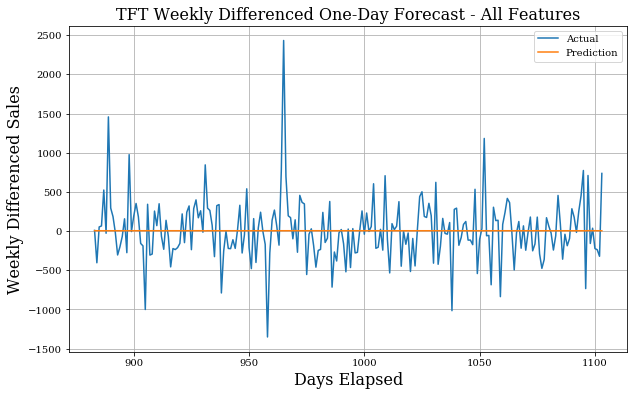

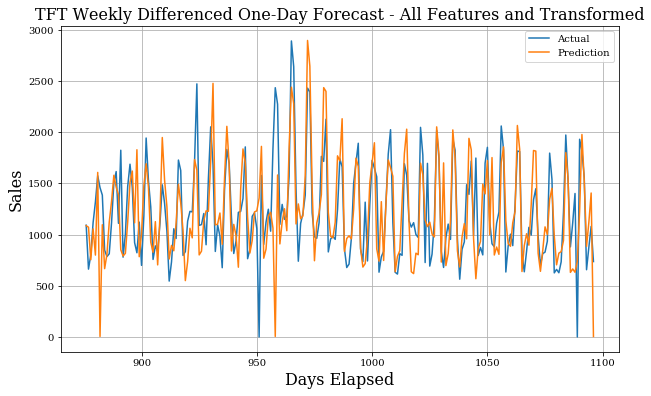

157325.95805029364
278.74238472865176


In [312]:
actuals = torch.cat([y[0] for x, y in iter(test_dataloader)])
predictions = tft.predict(test_dataloader)

actuals = actuals.numpy()
predictions = predictions.numpy()

time_series = time[train_time:]

plt.figure(figsize=(10, 6))
plot_series(time_series, actuals.flatten(),label="Actual")
plot_series(time_series, predictions.flatten(),label="Prediction")
plt.title("TFT Weekly Differenced One-Day Forecast - All Features",fontsize=16)
plt.xlabel("Days Elapsed", fontsize=16)
plt.ylabel("Weekly Differenced Sales", fontsize=16)
plt.legend(loc="best")
plt.savefig(fname='Charts/TransformerPredictonWeeklyDiff.png',dpi=150)
print(keras.metrics.mean_squared_error(actuals.flatten(), predictions.flatten()).numpy())
print(keras.metrics.mean_absolute_error(actuals.flatten(),predictions.flatten()).numpy())

#Adding predicted difference to get final results.
added_back = price_series[-228:-7] + predictions.flatten()
y_true = price_series[-221:] 

plt.figure(figsize=(10, 6))
plot_series(diff_time[-221:], y_true,label="Actual")
plot_series(diff_time[-221:], added_back,label="Prediction")
plt.title("TFT Weekly Differenced One-Day Forecast - All Features and Transformed",fontsize=16)
plt.xlabel("Days Elapsed", fontsize=16)
plt.ylabel("Sales", fontsize=16)
plt.legend(loc="best")
plt.savefig(fname='Charts/TransformerPredictonWeeklyDiffAB.png',dpi=150)
plt.show()

print(keras.metrics.mean_squared_error(y_true, added_back).numpy())
print(keras.metrics.mean_absolute_error(y_true, added_back).numpy())

<b> Week Difference - Less Features

In [313]:
dataframe = pd.read_csv('Data/RestaurantDataVets_All_2to5_Differenced.csv')
data = dataframe.drop(columns=['DMY','MissingPrevDays','DailyDifference','DiffDifference','2to5'])

remove=14
df = data.drop([x for x in range(remove)])
df = df.reset_index(drop=True)

#Objects need to be converted to float due to missing values at load time.
df["DailyAvg"] = df.DailyAvg.astype(float)
df["WeeklyAvg"] = df.WeeklyAvg.astype(float)
df["MinSales"] = df.MinSales.astype(float)
df["MaxSales"] = df.MaxSales.astype(float)
df["DailyBusyness"] = df.DailyBusyness.astype(float)
df["WeeklyBusyness"] = df.WeeklyBusyness.astype(float)

df["AvgDailyDiff"] = df.AvgDailyDiff.astype(float)
df["AvgWeeklyDiff"] = df.AvgWeeklyDiff.astype(float)
df["MaxDailyDiff"] = df.MaxDailyDiff.astype(float)
df["MinDailyDiff"] = df.MinDailyDiff.astype(float)
#df["DailyDifference"] = df.DailyDifference.astype(float)
df["WeeklyDifference"] = df.WeeklyDifference.astype(float)

hotdata = onehotholidaydiff(df,'WeeklyDifference')

numcols = len(hotdata.columns)
dataset = hotdata
dataset

numcols = len(hotdata.columns)
X=hotdata.iloc[:, 0:numcols-1]
y=hotdata.iloc[:, numcols-1]

X_new = SelectKBest(f_regression, k=55).fit(X,y)

dfscores = pd.DataFrame(X_new.scores_)
dfcolumns = pd.DataFrame(X.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(60,'Score'))  #print 10 best features
featureScores.to_csv('weeklydifffeatscores.csv')

C:\Users\Austin\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


              Specs      Score
48              A11  57.296458
63              A26  26.953598
34    AvgWeeklyDiff  23.967553
60              A23  16.344035
43               A6  14.945257
55              A18  10.932097
52              A15   6.864160
64              A27   5.434958
37               A0   5.434757
54              A17   3.212682
45               A8   2.669660
62              A25   2.482104
26  ChristmasSeason   2.027191
3               Day   1.761964
41               A4   1.751050
6             March   1.617099
50              A13   1.200954
44               A7   0.942852
39               A2   0.787587
51              A14   0.602171
24      LentFasting   0.513156
53              A16   0.490658
42               A5   0.423050
11           August   0.405338
5          February   0.384573
25          Ramadan   0.356426
28        WeeklyAvg   0.355412
35     MinDailyDiff   0.335999
27         DailyAvg   0.251915
10             July   0.211090
14         November   0.199972
32   Wee

In [314]:
train_data = dataset[lambda x: x.Index < train_time]

val_data = train_data[-80:]
train_data=train_data[:-80]

test_data = dataset[lambda x: x.Index >= train_time-6]


train_index = np.arange(1,len(train_data)+1, dtype="int")
val_index = np.arange(1,len(val_data)+1, dtype="int")
test_index = np.arange(1,len(test_data)+1, dtype="int")

train_data.Index = train_index
test_data.Index = test_index
val_data.Index = val_index

# create the dataset from the pandas dataframe
training = TimeSeriesDataSet(
     dataset[lambda x: x.Index < train_time-80],
     time_idx="Index",
     target="WeeklyDifference",
     group_ids=["Group"],
     min_encoder_length=14,  # allowing predictions without history
     max_encoder_length=14,
     min_prediction_length=1,
     max_prediction_length=1,
     static_categoricals=[],
     static_reals=[ ],
     time_varying_known_categoricals=[],
     
     time_varying_known_reals=["A11","A26","AvgWeeklyDiff","A23","A6","A18","A15","A27","A0"],
     time_varying_unknown_categoricals=[],
     time_varying_unknown_reals=["WeeklyDifference"],
     
 )

validating=TimeSeriesDataSet.from_dataset(training, val_data, stop_randomization=True)
testing=TimeSeriesDataSet.from_dataset(training, test_data, stop_randomization=True)

batch_size = 16

train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validating.to_dataloader(train=False, batch_size=batch_size, num_workers=0)
test_dataloader = testing.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

print("We batch our data into sizes of "+str(batch_size))
print("In our training dataset, we remove 10% for validation. Additional loss is needed to create a lookback window.")
print("In total, we train with " +str(batch_size*len(train_dataloader))+ " days.")
print("The 10% validation provides us with "+str(batch_size*len(val_dataloader))+" days.")
print("We test after fitting with "+str(batch_size*len(test_dataloader))+" days.")
print("In total, we have "+str(16*(len(train_dataloader) + len(val_dataloader) + len(test_dataloader)))+ " days.")

C:\Users\Austin\Anaconda3\lib\site-packages\pandas\core\generic.py:5489: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


We batch our data into sizes of 16
In our training dataset, we remove 10% for validation. Additional loss is needed to create a lookback window.
In total, we train with 768 days.
The 10% validation provides us with 80 days.
We test after fitting with 224 days.
In total, we have 1072 days.


In [315]:
##Callbacks 
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=15, verbose=False, mode="min")


##Trainer wrapper for training parameters
trainer = pl.Trainer( callbacks=[early_stop_callback], 
                     max_epochs=400,
                     gradient_clip_val=0.07570769472208098)

#Model initialization
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate= 0.07921950280200976,
    hidden_size=121,
    attention_head_size=1,
    dropout= 0.2152768224773502,
    hidden_continuous_size=32,
    output_size=7,
    loss=QuantileLoss(),
    log_interval=2,
    reduce_on_plateau_patience=4
)

print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

trainer.fit(tft, train_dataloader=train_dataloader, val_dataloaders=val_dataloader)

GPU available: True, used: False
TPU available: None, using: 0 TPU cores
C:\Users\Austin\Anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:49: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Number of parameters in network: 968.5k



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 640   
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 112 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 100 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 59.3 K
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 59.3 K
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 59.3

1

151773.47
271.9659


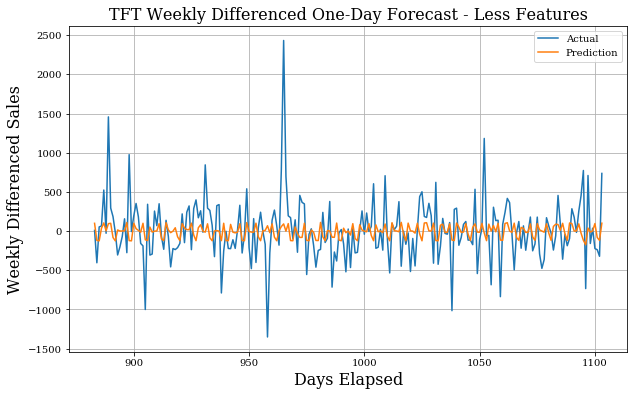

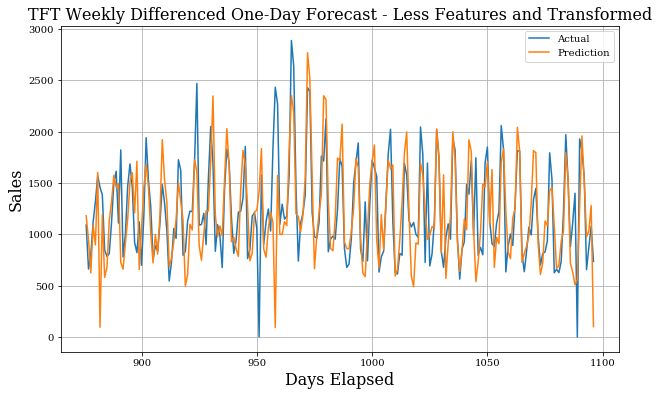

151773.46571214136
271.9659309883571


In [316]:
actuals = torch.cat([y[0] for x, y in iter(test_dataloader)])
predictions = tft.predict(test_dataloader)

actuals = actuals.numpy()
predictions = predictions.numpy()

time_series = time[train_time:]

plt.figure(figsize=(10, 6))
plot_series(time_series, actuals.flatten(),label="Actual")
plot_series(time_series, predictions.flatten(),label="Prediction")
plt.title("TFT Weekly Differenced One-Day Forecast - Less Features",fontsize=16)
plt.xlabel("Days Elapsed", fontsize=16)
plt.ylabel("Weekly Differenced Sales", fontsize=16)
plt.legend(loc="best")
plt.savefig(fname='Charts/TransformerPredictonWeeklyDiffLessFeats.png',dpi=150)
print(keras.metrics.mean_squared_error(actuals.flatten(), predictions.flatten()).numpy())
print(keras.metrics.mean_absolute_error(actuals.flatten(),predictions.flatten()).numpy())

#Adding predicted difference to get final results.
added_back = price_series[-228:-7] + predictions.flatten()
y_true = price_series[-221:] 

plt.figure(figsize=(10, 6))
plot_series(diff_time[-221:], y_true,label="Actual")
plot_series(diff_time[-221:], added_back,label="Prediction")
plt.title("TFT Weekly Differenced One-Day Forecast - Less Features and Transformed",fontsize=16)
plt.xlabel("Days Elapsed", fontsize=16)
plt.ylabel("Sales", fontsize=16)
plt.legend(loc="best")
plt.savefig(fname='Charts/TransformerPredictonWeeklyDiffLessFeatsAB.png',dpi=150)
plt.show()

print(keras.metrics.mean_squared_error(y_true, added_back).numpy())
print(keras.metrics.mean_absolute_error(y_true, added_back).numpy())